1


Iteration 0:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_12249/2976837275.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 2:  18%|█▊        | 175/1000 [00:05<00:23, 35.50it/s, episode=2170, return=541.789]

Episode Return: 1028.4550163003082, Actions: [25, 4, 12, 25, 4, 4, 3, 12, 12, 25, 24, 9, 18, 4, 4, 4, 18, 12, 4, 30, 12, 4, 24, 11, 18, 0, 12, 12, 3, 18, 30, 20, 18, 22, 29, 30, 18, 26, 12, 18, 1, 18, 9, 4, 30, 17, 4, 4, 16, 24, 4, 0, 30, 24, 12, 4, 24, 4, 30, 0, 4, 18, 18, 0, 18, 18, 18, 4, 30, 18, 18, 11, 18, 11, 4, 9, 22, 18, 1, 0, 0, 10, 30, 4, 3, 12, 22, 18, 18, 24, 4, 30, 18, 7, 4, 0, 9, 18, 18, 11, 4, 24, 30, 0, 4, 30, 6, 24, 4, 7, 30, 24, 13, 29, 18, 18, 24, 0, 9, 9, 0, 1, 1, 7, 0, 18, 24, 4, 0, 24, 3, 9, 30, 30, 0, 18, 18, 0, 18, 0, 0, 4, 18, 0, 4, 4, 0, 8, 12, 18, 18, 30, 1, 4, 18, 0, 13, 5, 4, 18, 18, 12, 18, 9, 18, 4, 18, 12, 9, 4, 18, 18, 11, 0, 4, 4, 12, 0, 4, 24, 0, 16, 22, 0, 3, 9, 24, 17, 16, 3, 18, 30, 12, 18, 1, 9, 18, 9, 24, 30]


Iteration 2:  34%|███▍      | 343/1000 [00:11<00:24, 26.62it/s, episode=2340, return=653.011] 

Episode Return: 1012.9070800021457, Actions: [4, 25, 25, 4, 4, 4, 30, 4, 30, 12, 4, 4, 4, 9, 4, 30, 4, 0, 1, 30, 4, 3, 0, 30, 22, 11, 24, 11, 9, 30, 18, 10, 7, 0, 4, 30, 18, 24, 30, 1, 30, 18, 29, 29, 30, 6, 18, 18, 24, 0, 4, 11, 30, 7, 9, 18, 18, 4, 0, 22, 18, 22, 1, 0, 18, 18, 8, 0, 1, 3, 17, 30, 0, 18, 11, 30, 0, 0, 8, 0, 30, 4, 4, 30, 20, 18, 30, 30, 30, 20, 5, 4, 30, 0, 30, 29, 30, 0, 1, 30, 18, 18, 18, 30, 0, 0, 30, 4, 0, 1, 18, 10, 30, 3, 5, 4, 30, 0, 4, 24, 0, 3, 0, 0, 0, 5, 30, 30, 4, 29, 24, 30, 5, 18, 30, 3, 0, 0, 18, 12, 0, 0, 11, 1, 0, 1, 18, 30, 4, 1, 24, 18, 0, 30, 5, 0, 18, 0, 1, 22, 4, 8, 18, 18, 30, 23, 11, 18, 0, 4, 30, 18, 0, 30, 1, 30, 4, 30, 18, 1, 9, 22, 30, 30, 0, 30, 18, 1, 1, 0, 4, 12, 0, 9, 30, 3, 29, 24, 30, 18]


Iteration 2:  69%|██████▉   | 691/1000 [00:20<00:09, 33.00it/s, episode=2690, return=405.674]  

Episode Return: 1036.2495063740512, Actions: [25, 25, 25, 25, 25, 25, 25, 1, 12, 1, 4, 4, 1, 1, 1, 0, 30, 6, 24, 6, 30, 1, 6, 30, 0, 17, 4, 0, 30, 0, 1, 30, 30, 4, 6, 4, 30, 30, 0, 4, 4, 0, 30, 29, 20, 0, 4, 1, 30, 0, 20, 4, 9, 30, 6, 1, 4, 18, 4, 1, 0, 0, 22, 30, 4, 1, 0, 1, 4, 24, 30, 11, 17, 4, 1, 30, 0, 4, 4, 0, 0, 4, 18, 18, 1, 18, 29, 1, 20, 0, 1, 4, 17, 20, 30, 0, 0, 20, 6, 4, 4, 1, 4, 30, 4, 1, 30, 30, 1, 9, 6, 24, 0, 0, 0, 1, 0, 22, 1, 0, 30, 3, 23, 4, 0, 30, 29, 30, 0, 1, 30, 1, 30, 1, 1, 29, 1, 0, 1, 11, 4, 0, 4, 24, 0, 4, 12, 18, 20, 1, 1, 18, 6, 1, 0, 30, 1, 1, 1, 30, 0, 1, 6, 17, 30, 30, 4, 1, 1, 16, 4, 4, 30, 20, 1, 4, 30, 1, 20, 6, 0, 4, 4, 0, 4, 11, 1, 0, 5, 18, 4, 30, 0, 6, 0, 30, 1, 4, 4, 24]


Iteration 2:  74%|███████▍  | 743/1000 [00:22<00:07, 35.33it/s, episode=2740, return=538.737] 

Episode Return: 1010.836188263371, Actions: [25, 25, 25, 25, 1, 4, 4, 4, 4, 1, 4, 30, 1, 30, 4, 30, 1, 1, 30, 1, 1, 6, 30, 4, 4, 30, 4, 18, 30, 1, 4, 30, 1, 1, 4, 9, 4, 0, 4, 1, 24, 1, 0, 20, 3, 30, 17, 3, 30, 4, 18, 1, 18, 4, 25, 1, 4, 30, 4, 1, 1, 0, 0, 11, 0, 0, 30, 30, 1, 6, 18, 30, 4, 0, 4, 1, 1, 4, 4, 0, 1, 24, 6, 11, 4, 30, 6, 23, 0, 4, 30, 1, 0, 1, 30, 1, 1, 4, 0, 4, 4, 29, 4, 30, 30, 4, 1, 4, 1, 0, 1, 20, 30, 30, 4, 4, 4, 0, 4, 30, 30, 0, 30, 4, 10, 1, 4, 30, 1, 1, 30, 22, 0, 30, 30, 4, 30, 24, 0, 29, 5, 1, 30, 4, 1, 1, 1, 4, 1, 30, 1, 4, 1, 30, 0, 0, 30, 30, 1, 30, 0, 4, 11, 1, 1, 6, 30, 4, 1, 0, 0, 4, 30, 1, 4, 1, 1, 1, 20, 4, 6, 1, 30, 0, 23, 1, 4, 0, 4, 4, 30, 30, 0, 5, 1, 1, 4, 6, 0, 30]


Iteration 2:  75%|███████▌  | 751/1000 [00:22<00:06, 35.91it/s, episode=2750, return=-150.820]

Episode Return: 1085.3146825116205, Actions: [25, 25, 25, 1, 1, 1, 1, 12, 23, 30, 0, 4, 30, 1, 22, 4, 1, 18, 30, 4, 0, 1, 22, 1, 0, 1, 30, 1, 6, 1, 15, 0, 4, 1, 29, 5, 4, 30, 4, 30, 30, 4, 0, 0, 1, 18, 30, 18, 1, 4, 24, 1, 0, 30, 0, 30, 0, 17, 0, 1, 4, 4, 1, 6, 18, 0, 4, 0, 4, 0, 30, 0, 30, 4, 1, 30, 1, 30, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 1, 4, 4, 4, 1, 0, 22, 30, 0, 30, 1, 4, 6, 0, 6, 1, 1, 30, 0, 30, 0, 0, 30, 0, 1, 4, 0, 30, 30, 30, 0, 30, 0, 30, 0, 1, 30, 30, 0, 0, 1, 4, 24, 4, 30, 30, 30, 1, 4, 30, 4, 30, 4, 0, 30, 30, 0, 30, 1, 0, 0, 4, 1, 1, 0, 30, 0, 0, 29, 0, 1, 30, 0, 18, 4, 6, 0, 0, 1, 0, 0, 30, 4, 30, 30, 6, 5, 0, 0, 0, 0, 1, 3, 30, 30, 4, 0, 24, 0, 4, 0, 0, 0, 4, 4, 11, 0, 18, 1, 30, 30]


Iteration 2:  85%|████████▌ | 851/1000 [00:25<00:04, 34.37it/s, episode=2850, return=-61.368] 

Episode Return: 1045.622498041574, Actions: [25, 25, 25, 4, 1, 0, 30, 30, 0, 4, 0, 1, 4, 4, 0, 23, 30, 6, 0, 1, 1, 30, 0, 30, 0, 30, 1, 1, 4, 0, 30, 1, 0, 0, 0, 22, 0, 1, 30, 9, 6, 6, 1, 22, 0, 0, 0, 30, 6, 1, 6, 1, 0, 0, 0, 30, 15, 30, 24, 1, 0, 30, 6, 1, 24, 0, 0, 4, 30, 9, 0, 0, 1, 18, 0, 0, 6, 1, 1, 30, 30, 0, 29, 0, 0, 30, 6, 0, 0, 0, 0, 20, 20, 0, 0, 3, 0, 20, 0, 0, 0, 6, 4, 0, 0, 0, 23, 0, 1, 1, 1, 0, 0, 30, 0, 30, 0, 0, 30, 0, 20, 30, 30, 6, 0, 0, 18, 0, 5, 23, 30, 6, 0, 0, 4, 0, 0, 1, 20, 5, 20, 0, 0, 0, 29, 29, 29, 30, 0, 6, 0, 20, 4, 30, 18, 30, 0, 1, 30, 0, 0, 1, 16, 6, 6, 4, 18, 0, 6, 4, 0, 0, 6, 30, 0, 30, 30, 0, 24, 30, 0, 1, 30, 30, 0, 0, 24, 30, 0, 0, 1, 0, 18, 17, 1, 0, 29, 18, 0, 20]
Episode Return: 1093.9272677717875, Actions: [25, 25, 25, 1, 1, 1, 1, 24, 6, 20, 0, 0, 1, 0, 30, 1, 0, 4, 1, 30, 1, 20, 20, 30, 1, 30, 0, 24, 30, 0, 30, 20, 0, 0, 29, 20, 0, 0, 0, 1, 30, 20, 1, 30, 20, 0, 1, 0, 1, 0, 0, 1, 6, 24, 6, 0, 0, 0, 4, 6, 30, 20, 0, 11, 20, 11, 0, 1, 20, 22, 20,

Iteration 4:  41%|████      | 412/1000 [00:10<00:15, 37.71it/s, episode=4410, return=-138.767]

Episode Return: 1044.1076449584652, Actions: [1, 1, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18, 1, 1, 1, 1, 30, 30, 1, 1, 20, 6, 1, 1, 1, 30, 20, 31, 30, 30, 20, 1, 1, 11, 31, 1, 30, 6, 30, 1, 1, 30, 1, 1, 1, 30, 1, 1, 30, 20, 30, 1, 1, 1, 1, 30, 20, 6, 1, 1, 1, 1, 1, 1, 30, 20, 1, 18, 1, 1, 30, 18, 1, 30, 1, 1, 1, 30, 20, 20, 20, 1, 1, 1, 30, 1, 6, 1, 1, 20, 1, 1, 11, 1, 6, 1, 1, 1, 30, 20, 20, 20, 1, 1, 6, 20, 1, 30, 1, 1, 31, 1, 1, 1, 6, 18, 1, 1, 1, 1, 31, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 1, 1, 1, 1, 20, 30, 1, 1, 20, 1, 1, 1, 20, 1, 1, 30, 20, 1, 20, 30, 20, 6, 30, 1, 1, 20, 1, 1, 1, 30, 1, 1, 23, 1, 1, 1, 20, 1, 31, 1, 1, 22, 1, 1, 1, 18, 1, 20, 1, 23, 1, 20, 1, 1, 1, 30, 20, 1, 1, 1]


Iteration 4:  43%|████▎     | 432/1000 [00:11<00:15, 36.69it/s, episode=4430, return=813.025] 

Episode Return: 1003.6827002562388, Actions: [25, 1, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 20, 1, 1, 1, 31, 30, 1, 20, 30, 20, 30, 1, 1, 1, 30, 18, 1, 30, 1, 1, 1, 6, 30, 11, 30, 20, 6, 1, 30, 1, 1, 24, 1, 30, 20, 1, 1, 20, 6, 1, 30, 1, 30, 1, 1, 1, 30, 20, 1, 24, 30, 1, 1, 22, 6, 6, 1, 30, 24, 1, 1, 20, 23, 1, 6, 1, 1, 30, 30, 1, 1, 1, 1, 30, 23, 1, 6, 30, 1, 30, 1, 30, 20, 30, 1, 20, 1, 1, 1, 20, 1, 11, 30, 1, 30, 22, 1, 30, 20, 1, 18, 6, 1, 30, 20, 30, 20, 1, 6, 20, 20, 6, 1, 20, 30, 30, 1, 23, 20, 30, 20, 23, 1, 1, 1, 23, 30, 1, 31, 30, 30, 1, 1, 30, 20, 1, 30, 1, 1, 20, 23, 30, 1, 1, 30, 1, 6, 31, 1, 20, 30, 6, 6, 20, 20, 1, 1, 1, 6, 1, 1, 1, 31, 1, 1, 6, 31, 1, 30, 16, 11, 24, 31, 1, 1, 1, 30, 1, 30, 20, 1, 3, 25, 30, 30, 30]


Iteration 4:  62%|██████▏   | 620/1000 [00:16<00:09, 38.00it/s, episode=4620, return=643.377]

Episode Return: 1004.2066904951802, Actions: [25, 25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 24, 1, 24, 22, 1, 24, 22, 24, 20, 11, 1, 24, 1, 30, 1, 30, 24, 22, 1, 22, 24, 24, 24, 24, 1, 1, 6, 24, 6, 24, 24, 1, 6, 1, 24, 6, 30, 6, 24, 22, 1, 22, 1, 1, 1, 24, 20, 22, 24, 1, 1, 6, 1, 23, 1, 1, 6, 11, 24, 24, 30, 1, 22, 24, 24, 24, 1, 6, 23, 22, 1, 24, 17, 24, 22, 6, 1, 30, 24, 24, 6, 1, 24, 24, 22, 24, 24, 1, 6, 24, 1, 30, 24, 1, 3, 24, 30, 1, 22, 11, 1, 30, 1, 11, 24, 22, 24, 6, 1, 11, 24, 1, 24, 24, 24, 1, 24, 6, 24, 1, 30, 24, 1, 18, 22, 1, 22, 1, 16, 11, 1, 6, 24, 22, 3, 24, 1, 1, 24, 24, 1, 6, 24, 30, 1, 24, 6, 11, 22, 22, 6, 22, 24, 24, 24, 1, 24, 24, 1, 1, 22, 24, 11, 24, 6, 1, 24, 1, 1, 6, 24, 1, 11, 24, 22, 24, 22, 1, 24, 24, 24, 1, 6, 24, 24, 22, 30, 11]


Iteration 4:  77%|███████▋  | 769/1000 [00:20<00:06, 38.03it/s, episode=4770, return=739.136]

Episode Return: 1007.6562111397129, Actions: [25, 25, 1, 1, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 22, 1, 6, 24, 24, 1, 1, 24, 1, 1, 6, 24, 22, 24, 24, 24, 6, 1, 1, 23, 24, 30, 24, 6, 30, 22, 6, 11, 24, 6, 24, 24, 6, 30, 6, 1, 24, 22, 6, 24, 1, 31, 22, 24, 6, 1, 22, 6, 24, 1, 30, 1, 1, 1, 1, 30, 22, 22, 6, 1, 16, 22, 1, 16, 24, 20, 1, 30, 1, 30, 6, 1, 24, 1, 24, 1, 1, 22, 6, 1, 1, 24, 24, 22, 20, 24, 1, 1, 6, 16, 24, 24, 6, 1, 30, 16, 24, 1, 24, 1, 1, 1, 30, 6, 1, 24, 24, 6, 30, 30, 22, 24, 6, 24, 30, 22, 6, 1, 1, 22, 16, 1, 1, 1, 1, 6, 20, 1, 6, 1, 24, 6, 1, 1, 30, 24, 24, 24, 24, 1, 6, 6, 1, 24, 1, 1, 24, 1, 1, 30, 22, 24, 1, 1, 30, 6, 4, 22, 24, 24, 24, 6, 24, 1, 24, 1, 6, 16, 24, 1, 1, 30, 22, 6, 22, 1, 22, 5, 1, 29, 1, 1, 30, 1, 24]


Iteration 5:  14%|█▍        | 140/1000 [00:03<00:22, 38.06it/s, episode=5140, return=613.725]

Episode Return: 1041.2949900087085, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 1, 30, 30, 1, 16, 30, 30, 1, 16, 1, 1, 30, 1, 16, 30, 1, 1, 30, 16, 30, 1, 22, 16, 30, 16, 30, 30, 16, 1, 1, 30, 31, 16, 30, 1, 1, 1, 16, 16, 30, 1, 1, 1, 30, 1, 1, 1, 16, 1, 30, 1, 1, 1, 1, 30, 30, 30, 1, 16, 30, 16, 30, 1, 24, 1, 1, 1, 30, 1, 1, 30, 1, 30, 30, 30, 1, 1, 1, 30, 1, 1, 16, 1, 24, 16, 1, 16, 1, 1, 30, 1, 16, 1, 1, 30, 1, 30, 16, 30, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 30, 17, 16, 16, 1, 1, 16, 30, 1, 1, 30, 1, 16, 1, 16, 1, 1, 30, 30, 16, 1, 30, 1, 30, 1, 30, 1, 6, 1, 30, 1, 1, 24, 30, 16, 1, 16, 30, 1, 16, 30, 30, 30, 1, 1, 30, 30, 1, 1, 1, 30, 16, 30, 30, 30, 1, 1, 24, 1, 30, 1, 30, 30, 16, 1, 1, 24, 30, 16, 24, 16, 1, 22, 30]


Iteration 5:  20%|██        | 200/1000 [00:05<00:21, 37.68it/s, episode=5200, return=528.894]

Episode Return: 1099.1657568114665, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 16, 1, 24, 31, 22, 24, 30, 22, 16, 24, 1, 22, 24, 1, 1, 22, 22, 16, 16, 1, 30, 24, 3, 16, 30, 24, 1, 1, 1, 1, 22, 30, 24, 1, 30, 1, 1, 22, 24, 30, 1, 30, 30, 24, 24, 1, 1, 22, 30, 1, 1, 30, 30, 1, 24, 1, 22, 30, 24, 30, 22, 1, 1, 1, 1, 1, 1, 22, 1, 31, 1, 16, 24, 1, 1, 30, 30, 1, 1, 1, 1, 6, 1, 16, 24, 24, 24, 6, 1, 30, 16, 24, 22, 1, 30, 24, 16, 18, 1, 1, 24, 24, 24, 24, 1, 1, 16, 24, 24, 24, 24, 1, 24, 24, 24, 1, 1, 30, 1, 1, 1, 1, 1, 22, 1, 1, 30, 30, 1, 22, 1, 30, 24, 30, 22, 24, 1, 1, 24, 16, 1, 22, 30, 22, 24, 22, 1, 22, 24, 1, 30, 24, 1, 22, 1, 24, 1, 24, 30, 16, 30, 1, 1, 24, 30, 6, 24, 24, 22, 1, 16, 16, 24, 1, 1, 30, 16, 24, 24, 1, 24, 1, 24, 22, 1, 16, 30, 1]
Episode Return: 1031.7060667940575, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 22, 30, 1, 22, 24, 16, 1, 1, 1, 30, 22, 22, 30, 22, 24, 24, 22, 16, 1, 22, 30, 1, 30, 24, 1, 1, 22, 30, 16, 1, 22, 1, 24, 1, 1, 1, 

Iteration 5:  28%|██▊       | 276/1000 [00:07<00:21, 34.12it/s, episode=5270, return=563.379]

Episode Return: 1006.7185647600512, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 24, 1, 22, 16, 1, 1, 30, 30, 24, 1, 1, 6, 24, 22, 16, 1, 1, 1, 22, 22, 16, 24, 6, 31, 24, 24, 1, 1, 30, 1, 24, 30, 24, 1, 30, 30, 1, 1, 24, 24, 1, 1, 22, 1, 30, 1, 22, 1, 1, 16, 24, 1, 1, 1, 1, 1, 1, 22, 24, 1, 24, 22, 1, 31, 31, 24, 30, 22, 30, 1, 1, 1, 24, 24, 1, 1, 30, 16, 1, 30, 1, 30, 1, 24, 1, 30, 16, 1, 16, 1, 16, 1, 1, 1, 1, 1, 16, 31, 30, 24, 1, 1, 1, 1, 1, 1, 24, 24, 24, 24, 30, 30, 1, 1, 22, 24, 1, 16, 1, 1, 1, 1, 30, 22, 1, 1, 16, 30, 1, 1, 22, 30, 24, 24, 1, 1, 30, 1, 24, 24, 23, 1, 22, 1, 1, 1, 30, 24, 22, 1, 1, 1, 1, 22, 1, 1, 24, 1, 24, 1, 6, 16, 1, 1, 30, 24, 24, 24, 24, 24, 1, 23, 1, 1, 6, 24, 1, 31, 1, 24, 22, 24, 30, 6, 16, 1]
Episode Return: 1018.8755710294033, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 31, 1, 24, 16, 30, 30, 1, 1, 30, 24, 1, 22, 30, 24, 1, 16, 1, 30, 16, 24, 1, 16, 24, 24, 24, 24, 1, 30, 24, 24, 30, 1, 1, 31, 22, 1, 24, 30, 1, 16, 24, 30, 1, 22, 24, 1

Iteration 5:  62%|██████▏   | 620/1000 [00:16<00:09, 38.41it/s, episode=5620, return=717.453] 

Episode Return: 1006.2662894267796, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 16, 30, 4, 16, 30, 31, 31, 30, 30, 30, 30, 16, 1, 30, 30, 30, 16, 16, 30, 30, 16, 30, 30, 16, 30, 30, 31, 16, 30, 31, 31, 16, 16, 16, 16, 16, 16, 4, 11, 30, 16, 31, 30, 30, 4, 16, 16, 16, 16, 25, 4, 9, 16, 30, 16, 16, 16, 16, 16, 30, 30, 30, 30, 30, 30, 23, 30, 16, 30, 16, 16, 16, 30, 30, 3, 16, 4, 31, 16, 30, 16, 16, 4, 16, 16, 30, 16, 16, 16, 16, 24, 1, 30, 16, 16, 16, 16, 16, 30, 25, 30, 16, 16, 16, 16, 25, 16, 30, 16, 16, 16, 16, 30, 30, 16, 31, 16, 31, 30, 16, 16, 16, 3, 3, 16, 3, 16, 16, 16, 30, 16, 3, 16, 30, 30, 16, 30, 16, 16, 16, 16, 30, 3, 30, 30, 24, 16, 30, 30, 4, 1, 30, 30, 16, 30, 16, 30, 16, 16, 31, 30, 16, 16, 31, 30, 30, 16, 16, 16, 24, 16, 16, 30, 16, 16, 30, 30, 16, 16, 16, 16, 16, 3, 16, 9, 30, 30, 16, 16]


Iteration 5:  69%|██████▉   | 692/1000 [00:18<00:08, 38.01it/s, episode=5690, return=467.831]

Episode Return: 1006.8499809776988, Actions: [25, 1, 1, 1, 1, 25, 1, 4, 4, 1, 30, 1, 4, 23, 16, 30, 16, 30, 3, 3, 31, 31, 31, 31, 16, 30, 16, 11, 4, 4, 31, 4, 16, 31, 3, 16, 16, 16, 31, 16, 30, 16, 16, 16, 3, 16, 16, 3, 16, 4, 30, 16, 16, 16, 30, 9, 30, 16, 16, 30, 16, 16, 16, 16, 3, 16, 16, 4, 16, 16, 16, 4, 16, 16, 31, 16, 16, 3, 31, 3, 3, 31, 30, 16, 3, 16, 3, 16, 4, 16, 16, 4, 3, 31, 16, 16, 3, 4, 4, 16, 1, 16, 16, 3, 31, 16, 4, 4, 3, 16, 16, 24, 16, 16, 4, 16, 3, 16, 16, 3, 3, 3, 31, 16, 3, 4, 16, 16, 16, 3, 16, 16, 3, 16, 16, 30, 16, 4, 3, 4, 4, 31, 30, 31, 16, 3, 30, 16, 3, 16, 4, 16, 3, 11, 16, 16, 16, 23, 16, 3, 16, 31, 11, 4, 3, 30, 16, 4, 16, 24, 9, 3, 31, 31, 16, 16, 30, 16, 16, 4, 3, 16, 16, 16, 30, 16, 16, 16, 30, 16, 16, 11, 11, 9, 16, 16, 31, 9, 16, 3]


Iteration 5:  76%|███████▋  | 764/1000 [00:20<00:06, 38.33it/s, episode=5760, return=420.899]

Episode Return: 1067.054992281634, Actions: [25, 25, 25, 25, 25, 25, 25, 4, 0, 4, 0, 4, 0, 30, 0, 3, 10, 4, 3, 30, 31, 3, 0, 4, 4, 0, 0, 31, 25, 4, 30, 4, 4, 30, 20, 4, 4, 30, 30, 16, 4, 0, 16, 0, 3, 25, 3, 30, 30, 4, 4, 4, 3, 16, 0, 3, 24, 22, 30, 9, 3, 4, 16, 1, 25, 4, 0, 4, 25, 4, 4, 4, 3, 3, 16, 16, 24, 16, 10, 4, 30, 4, 24, 4, 0, 3, 0, 30, 4, 4, 0, 0, 10, 3, 16, 16, 30, 25, 1, 3, 3, 0, 0, 31, 16, 9, 30, 4, 31, 0, 4, 0, 1, 0, 3, 31, 16, 30, 3, 4, 30, 0, 4, 30, 4, 16, 1, 16, 0, 4, 4, 4, 4, 25, 1, 4, 16, 3, 4, 5, 0, 25, 3, 4, 0, 0, 4, 4, 0, 30, 3, 16, 24, 16, 16, 25, 4, 16, 9, 4, 30, 16, 3, 0, 9, 4, 16, 4, 25, 16, 4, 16, 16, 4, 25, 3, 4, 3, 3, 4, 3, 0, 4, 4, 0, 4, 4, 30, 0, 23, 16, 4, 4, 4, 0, 25, 25, 3, 4, 3]


Iteration 5:  81%|████████  | 812/1000 [00:21<00:04, 38.08it/s, episode=5810, return=-1131.656]

Episode Return: 1013.9700410378223, Actions: [25, 25, 1, 25, 1, 0, 25, 4, 0, 4, 1, 30, 4, 4, 3, 30, 16, 31, 4, 30, 20, 3, 23, 30, 20, 30, 3, 4, 10, 16, 4, 4, 31, 16, 0, 4, 0, 30, 4, 20, 16, 16, 4, 30, 4, 16, 3, 3, 30, 16, 4, 16, 16, 30, 30, 30, 4, 16, 3, 4, 30, 10, 3, 20, 0, 4, 3, 4, 30, 31, 6, 3, 4, 30, 30, 4, 30, 4, 30, 6, 30, 4, 1, 16, 4, 30, 30, 30, 30, 30, 4, 30, 30, 0, 31, 4, 0, 0, 16, 4, 4, 30, 3, 3, 31, 0, 30, 3, 4, 31, 3, 4, 4, 4, 4, 16, 3, 4, 0, 4, 30, 16, 3, 16, 30, 4, 11, 25, 24, 4, 4, 16, 9, 3, 4, 24, 31, 24, 1, 3, 3, 4, 30, 3, 4, 16, 4, 4, 4, 4, 30, 30, 16, 16, 4, 4, 3, 30, 16, 16, 30, 4, 0, 4, 16, 9, 16, 30, 16, 3, 3, 31, 3, 4, 30, 4, 0, 4, 30, 4, 16, 4, 3, 4, 4, 4, 16, 4, 0, 6, 30, 0, 0, 4, 4, 4, 30, 0, 16, 16]


Iteration 6:  14%|█▍        | 144/1000 [00:03<00:22, 38.18it/s, episode=6140, return=411.480]

Episode Return: 1108.1935445153113, Actions: [25, 1, 1, 25, 1, 1, 1, 1, 4, 16, 1, 4, 31, 4, 16, 31, 4, 30, 31, 1, 30, 0, 30, 4, 30, 3, 3, 4, 30, 31, 1, 4, 16, 16, 1, 16, 4, 16, 30, 16, 24, 30, 31, 1, 16, 4, 11, 30, 30, 4, 30, 4, 25, 30, 1, 16, 31, 16, 3, 4, 4, 4, 16, 30, 3, 16, 4, 16, 24, 30, 30, 30, 30, 11, 4, 16, 30, 30, 3, 16, 0, 16, 3, 4, 10, 30, 4, 16, 4, 30, 4, 1, 3, 0, 4, 4, 30, 4, 4, 3, 4, 4, 30, 0, 0, 4, 1, 3, 4, 16, 3, 3, 1, 30, 6, 4, 4, 30, 30, 3, 4, 16, 9, 4, 31, 4, 30, 30, 30, 17, 3, 24, 4, 0, 0, 1, 4, 4, 30, 16, 16, 4, 1, 3, 16, 30, 30, 16, 3, 6, 31, 3, 4, 3, 3, 3, 16, 24, 4, 11, 24, 30, 3, 4, 4, 16, 0, 31, 4, 30, 16, 16, 4, 1, 16, 30, 31, 4, 21, 4, 3, 4, 4, 16, 16, 31, 30, 4, 1, 3, 4, 30, 16, 1, 16, 4, 30, 16, 16, 1]


Iteration 6:  17%|█▋        | 172/1000 [00:04<00:21, 38.26it/s, episode=6170, return=649.589]

Episode Return: 1064.6904185508724, Actions: [25, 1, 1, 1, 1, 1, 1, 4, 4, 1, 4, 30, 4, 30, 24, 30, 4, 4, 3, 4, 30, 4, 3, 4, 16, 30, 30, 3, 4, 3, 30, 24, 3, 3, 31, 29, 4, 4, 4, 3, 16, 30, 30, 24, 4, 18, 30, 16, 16, 30, 3, 4, 16, 3, 30, 1, 4, 30, 16, 30, 16, 4, 3, 3, 16, 4, 16, 4, 4, 3, 3, 4, 4, 30, 31, 3, 1, 30, 4, 16, 31, 3, 25, 24, 0, 16, 31, 4, 16, 4, 4, 30, 4, 31, 30, 30, 31, 16, 4, 3, 4, 1, 0, 16, 30, 4, 4, 4, 4, 16, 4, 16, 16, 16, 30, 1, 4, 3, 4, 4, 4, 3, 3, 0, 16, 3, 3, 4, 31, 16, 16, 4, 4, 4, 30, 4, 3, 4, 16, 30, 3, 4, 4, 16, 1, 31, 31, 4, 16, 31, 3, 4, 4, 16, 0, 4, 16, 16, 4, 3, 4, 16, 16, 4, 30, 11, 24, 30, 4, 31, 30, 3, 4, 30, 16, 4, 16, 4, 30, 4, 4, 16, 4, 4, 0, 3, 31, 11, 16, 16, 4, 4, 0, 22, 4, 1, 4, 16, 4, 0]


Iteration 6:  43%|████▎     | 428/1000 [00:11<00:14, 38.70it/s, episode=6420, return=696.009] 

Episode Return: 1021.990110750291, Actions: [25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 1, 30, 20, 1, 30, 30, 1, 1, 1, 30, 30, 6, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 6, 30, 1, 1, 1, 30, 30, 30, 1, 1, 30, 30, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1, 1, 30, 6, 1, 30, 1, 1, 1, 30, 30, 30, 30, 1, 1, 30, 30, 6, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 30, 30, 1, 30, 30, 30, 1, 1, 1, 1, 30, 30, 1, 30, 30, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 30, 30, 30, 1, 1, 30, 1, 1, 1, 1, 30, 30, 24, 1, 30, 1, 1, 30, 30, 1, 30, 30, 30, 1, 1, 30, 30, 1, 30, 30, 1, 1, 24, 1, 1, 24, 30, 1, 1, 30, 1, 1, 30, 30, 1, 1, 1, 1, 16, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1, 1, 1]


Iteration 6:  45%|████▌     | 452/1000 [00:11<00:14, 37.05it/s, episode=6450, return=408.076]

Episode Return: 1012.3946892571483, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 30, 1, 1, 30, 1, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 30, 30, 1, 30, 1, 1, 30, 30, 1, 1, 1, 1, 1, 30, 4, 1, 30, 30, 1, 1, 30, 1, 0, 1, 1, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 30, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 30, 30, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 20, 1, 1, 1, 30, 1, 1, 1, 16, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 30, 16, 1, 1, 1, 30, 16, 30, 1, 1, 3, 1, 1, 30, 1, 1, 1, 1, 1, 1]


Iteration 6:  48%|████▊     | 480/1000 [00:12<00:13, 38.24it/s, episode=6480, return=270.693]

Episode Return: 1082.287223827183, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 30, 30, 6, 1, 30, 1, 30, 30, 30, 1, 30, 1, 1, 30, 1, 1, 30, 30, 1, 1, 3, 1, 30, 1, 1, 1, 30, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 1, 24, 1, 16, 1, 1, 30, 30, 1, 1, 1, 24, 30, 30, 1, 1, 1, 30, 1, 1, 30, 1, 30, 1, 1, 30, 30, 1, 1, 30, 30, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 22, 1, 1, 31, 1, 1, 1, 30, 1, 1, 1, 1, 30, 4, 1, 1, 1, 1, 1, 22, 1, 1, 1, 1, 1, 30, 30, 30, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 16, 1, 30, 30, 1, 30, 1, 1, 1, 4, 30, 30, 1, 1, 1, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 30, 30, 30, 1, 1, 3, 1, 11, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 16, 30, 30, 1, 30, 1, 1, 3]


Iteration 6:  50%|█████     | 500/1000 [00:13<00:13, 38.33it/s, episode=6500, return=819.658]

Episode Return: 1029.3677323444435, Actions: [25, 25, 25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 1, 6, 30, 30, 1, 30, 1, 1, 30, 20, 30, 30, 1, 1, 1, 1, 1, 31, 1, 1, 1, 30, 1, 30, 30, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 30, 1, 30, 30, 31, 1, 30, 30, 30, 1, 30, 1, 30, 24, 30, 1, 6, 30, 1, 1, 30, 1, 4, 4, 1, 1, 30, 6, 1, 1, 22, 11, 1, 30, 1, 3, 1, 30, 0, 1, 1, 1, 1, 30, 1, 30, 1, 30, 30, 30, 1, 1, 1, 1, 30, 1, 3, 30, 1, 30, 1, 30, 6, 1, 1, 1, 1, 22, 1, 30, 1, 1, 1, 30, 16, 30, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 6, 1, 30, 1, 1, 31, 30, 1, 1, 30, 1, 30, 1, 1, 30, 1, 30, 1, 16, 30, 16, 1, 1, 16, 1, 30, 1, 1, 30, 6, 1, 1, 30, 16, 20, 1, 1, 30, 30, 6, 1, 30, 1, 30, 1, 30, 30, 30, 1, 1, 24, 16, 1, 1, 1, 16, 1, 30, 4, 1]


Iteration 6:  54%|█████▍    | 544/1000 [00:14<00:11, 38.20it/s, episode=6540, return=357.214]

Episode Return: 1014.1201039338084, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 1, 1, 30, 1, 6, 30, 1, 30, 30, 1, 1, 1, 30, 1, 30, 1, 30, 1, 1, 16, 1, 1, 1, 1, 16, 1, 1, 30, 16, 1, 1, 1, 6, 1, 22, 1, 30, 1, 30, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 30, 1, 1, 30, 1, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 30, 16, 1, 30, 30, 1, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 16, 30, 20, 30, 30, 6, 1, 1, 1, 16, 1, 1, 1, 30, 3, 1, 1, 30, 16, 1, 1, 22, 1, 30, 1, 30, 1, 1, 1, 30, 31, 1, 1, 1, 3, 22, 30, 1, 1, 30, 30, 30, 1, 1, 30, 1, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 24, 16, 1, 1, 16, 30, 1, 1, 1]
Episode Return: 1168.7052885555058, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 16, 30, 1, 30, 30, 1, 30, 30, 3, 30, 1, 1, 1, 30, 1, 1, 30, 1, 30, 1, 30, 1, 1, 1, 16, 1, 30, 30, 1, 30, 31, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 6, 1, 1, 1, 1, 1, 6, 1, 1, 31, 1, 1, 1, 1, 6, 1, 30, 1, 1, 16, 24,

Iteration 6:  66%|██████▌   | 660/1000 [00:17<00:08, 38.12it/s, episode=6660, return=439.482]  

Episode Return: 1010.1210009539818, Actions: [25, 25, 1, 1, 1, 25, 0, 1, 25, 1, 1, 3, 0, 16, 0, 4, 11, 0, 16, 0, 4, 11, 6, 4, 0, 31, 0, 30, 25, 0, 4, 11, 0, 30, 0, 24, 6, 6, 30, 25, 22, 22, 31, 0, 16, 3, 29, 0, 16, 30, 16, 30, 30, 31, 30, 31, 16, 4, 16, 16, 3, 31, 16, 31, 6, 30, 6, 6, 0, 0, 4, 16, 0, 22, 5, 16, 31, 30, 24, 24, 24, 22, 11, 16, 0, 16, 3, 16, 6, 16, 22, 4, 31, 16, 3, 0, 3, 11, 0, 1, 3, 6, 16, 16, 4, 25, 4, 4, 30, 1, 4, 16, 30, 6, 1, 5, 6, 0, 16, 30, 30, 3, 3, 16, 4, 30, 0, 16, 9, 25, 0, 6, 24, 16, 30, 16, 16, 30, 30, 16, 3, 30, 4, 16, 4, 16, 1, 3, 24, 0, 0, 0, 31, 31, 22, 9, 6, 4, 16, 1, 16, 16, 4, 16, 6, 30, 24, 24, 6, 16, 30, 20, 22, 3, 0, 0, 3, 16, 4, 4, 0, 16, 1, 0, 6, 4, 4, 11, 30, 30, 30, 16, 9, 3, 1, 16, 24, 30, 16, 20]


Iteration 6:  68%|██████▊   | 680/1000 [00:17<00:08, 38.20it/s, episode=6680, return=745.686]

Episode Return: 1012.9395481779275, Actions: [25, 25, 25, 25, 25, 1, 1, 1, 1, 1, 0, 1, 1, 1, 16, 30, 30, 30, 0, 16, 16, 1, 30, 31, 24, 30, 0, 4, 3, 30, 16, 16, 3, 30, 30, 4, 11, 1, 6, 24, 6, 30, 29, 1, 20, 4, 16, 1, 30, 30, 30, 0, 4, 25, 16, 30, 16, 4, 1, 16, 25, 30, 1, 1, 16, 25, 6, 4, 3, 16, 4, 25, 1, 16, 1, 30, 1, 16, 4, 16, 1, 25, 16, 24, 4, 29, 0, 30, 16, 4, 16, 4, 24, 1, 4, 11, 25, 25, 4, 1, 6, 0, 3, 16, 30, 16, 20, 31, 24, 1, 16, 16, 30, 16, 16, 25, 22, 16, 1, 6, 24, 30, 24, 30, 24, 0, 30, 30, 1, 16, 0, 1, 11, 6, 6, 16, 30, 16, 11, 16, 4, 25, 16, 3, 30, 16, 30, 3, 24, 1, 30, 11, 1, 25, 24, 25, 11, 16, 1, 16, 31, 20, 30, 16, 6, 16, 16, 16, 16, 6, 1, 30, 16, 1, 31, 30, 16, 30, 4, 1, 1, 4, 16, 30, 6, 3, 24, 11, 30, 16, 0, 16, 4, 16, 9, 16, 31, 6, 30, 29]


Iteration 6:  71%|███████   | 709/1000 [00:18<00:07, 36.79it/s, episode=6710, return=529.858]

Episode Return: 1058.824788491965, Actions: [25, 1, 25, 1, 25, 1, 1, 1, 1, 0, 30, 1, 11, 1, 1, 1, 4, 29, 1, 0, 30, 16, 3, 16, 4, 31, 30, 16, 31, 16, 31, 3, 30, 31, 11, 30, 4, 31, 24, 25, 9, 9, 3, 4, 1, 9, 0, 16, 4, 4, 16, 16, 16, 16, 16, 31, 4, 3, 4, 9, 24, 3, 6, 5, 16, 4, 31, 16, 4, 6, 16, 5, 30, 1, 9, 9, 1, 3, 16, 16, 4, 16, 4, 30, 9, 4, 10, 16, 3, 16, 16, 16, 30, 4, 4, 4, 9, 16, 9, 4, 9, 9, 24, 16, 0, 16, 30, 20, 4, 31, 31, 30, 3, 30, 16, 9, 30, 30, 30, 0, 4, 16, 1, 16, 16, 1, 9, 31, 1, 9, 30, 3, 1, 25, 25, 9, 16, 16, 30, 30, 31, 30, 31, 16, 22, 24, 3, 3, 1, 9, 4, 1, 30, 30, 16, 0, 4, 6, 6, 24, 16, 3, 4, 16, 4, 10, 31, 1, 11, 16, 1, 4, 16, 4, 3, 0, 16, 30, 3, 9, 30, 16, 30, 9, 3, 4, 4, 9, 24, 4, 4, 1, 3, 22, 16, 6, 9, 4, 25, 6]
Episode Return: 1036.7618572635881, Actions: [25, 1, 25, 25, 1, 1, 1, 9, 1, 1, 16, 1, 25, 1, 4, 1, 9, 4, 1, 4, 4, 25, 16, 4, 1, 30, 9, 16, 16, 6, 4, 4, 0, 3, 3, 31, 29, 4, 11, 25, 4, 30, 30, 4, 4, 16, 3, 3, 30, 4, 9, 16, 4, 16, 24, 30, 25, 16, 9, 30, 4, 4, 4,

Iteration 6:  73%|███████▎  | 732/1000 [00:19<00:07, 37.71it/s, episode=6730, return=815.545]

Episode Return: 1014.2251898277907, Actions: [25, 25, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 30, 30, 30, 30, 3, 16, 24, 30, 3, 30, 16, 1, 4, 0, 24, 4, 24, 0, 25, 1, 16, 30, 4, 30, 4, 3, 30, 0, 24, 4, 25, 30, 25, 24, 9, 29, 31, 16, 25, 3, 24, 4, 30, 4, 30, 30, 4, 5, 1, 4, 4, 1, 1, 0, 4, 9, 24, 4, 4, 24, 4, 4, 1, 4, 1, 0, 3, 16, 22, 25, 30, 16, 3, 4, 9, 4, 4, 30, 6, 0, 3, 1, 30, 4, 1, 24, 4, 4, 0, 0, 30, 1, 4, 25, 9, 24, 1, 30, 4, 4, 16, 30, 16, 0, 4, 4, 6, 16, 25, 4, 1, 30, 6, 25, 16, 30, 31, 4, 4, 1, 4, 25, 30, 1, 3, 24, 16, 24, 25, 24, 1, 4, 6, 3, 9, 6, 30, 4, 9, 4, 4, 16, 6, 4, 4, 30, 9, 9, 4, 16, 1, 9, 16, 0, 0, 4, 16, 3, 4, 4, 0, 1, 1, 1, 4, 16, 3, 0, 4, 16, 30, 4, 1, 22, 4, 4, 0, 1, 29, 0, 4, 1, 30, 16, 4, 3, 16, 0]
Episode Return: 1032.4449315387405, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 30, 16, 30, 25, 9, 31, 25, 31, 3, 11, 16, 4, 31, 30, 4, 0, 30, 30, 1, 31, 3, 24, 4, 4, 30, 16, 31, 24, 11, 16, 30, 1, 4, 0, 4, 31, 4, 22, 30, 31, 30, 0, 0, 31, 4, 1, 31, 30, 16, 16, 9, 4, 30, 30

Iteration 6:  76%|███████▌  | 756/1000 [00:19<00:06, 38.21it/s, episode=6750, return=494.157]

Episode Return: 1111.537578613033, Actions: [25, 1, 25, 1, 1, 1, 1, 25, 1, 0, 1, 24, 4, 0, 24, 0, 1, 30, 4, 16, 5, 31, 30, 25, 30, 1, 24, 0, 4, 0, 31, 30, 31, 1, 3, 6, 30, 0, 16, 9, 0, 1, 4, 4, 16, 30, 0, 3, 22, 0, 24, 0, 4, 3, 25, 4, 24, 16, 30, 4, 0, 20, 30, 22, 4, 24, 4, 4, 16, 4, 1, 1, 0, 4, 4, 3, 4, 4, 24, 1, 4, 11, 16, 31, 4, 16, 16, 0, 1, 4, 4, 4, 25, 24, 4, 3, 30, 0, 6, 0, 16, 30, 29, 10, 4, 1, 31, 30, 1, 3, 0, 0, 0, 0, 0, 3, 16, 30, 0, 4, 3, 4, 3, 4, 16, 0, 1, 4, 4, 3, 31, 3, 1, 22, 4, 4, 24, 11, 0, 0, 4, 3, 9, 9, 4, 3, 16, 24, 24, 16, 1, 4, 4, 20, 30, 4, 25, 4, 4, 24, 30, 3, 0, 4, 21, 30, 4, 25, 4, 4, 0, 30, 30, 6, 6, 3, 20, 0, 30, 31, 3, 4, 4, 30, 30, 4, 1, 4, 0, 4, 4, 0, 1, 16, 30, 3, 3, 30, 16, 0]
Episode Return: 1053.57589790518, Actions: [25, 1, 25, 1, 1, 1, 1, 0, 1, 0, 1, 4, 30, 30, 4, 3, 4, 0, 30, 16, 30, 6, 3, 4, 30, 3, 0, 9, 30, 4, 0, 4, 0, 31, 24, 30, 3, 4, 3, 24, 4, 3, 25, 4, 4, 31, 20, 11, 30, 1, 0, 9, 3, 16, 0, 4, 0, 3, 4, 30, 4, 0, 16, 24, 31, 3, 4, 25, 6, 30, 0

Iteration 6:  78%|███████▊  | 776/1000 [00:20<00:05, 38.34it/s, episode=6770, return=542.164]

Episode Return: 1041.214531792841, Actions: [1, 25, 1, 1, 0, 1, 0, 1, 1, 0, 30, 0, 30, 30, 3, 24, 4, 11, 24, 4, 31, 0, 31, 31, 4, 0, 0, 16, 0, 3, 9, 0, 0, 6, 0, 1, 4, 11, 4, 0, 16, 0, 4, 16, 4, 24, 0, 31, 9, 0, 31, 31, 31, 0, 4, 4, 24, 30, 11, 30, 4, 30, 4, 0, 24, 9, 30, 4, 24, 0, 30, 30, 0, 4, 0, 24, 0, 24, 31, 31, 0, 0, 30, 24, 0, 3, 4, 31, 4, 11, 31, 30, 24, 30, 4, 0, 30, 24, 16, 30, 0, 30, 4, 9, 30, 4, 4, 24, 0, 0, 31, 4, 4, 4, 24, 31, 24, 11, 16, 0, 16, 0, 0, 1, 4, 4, 0, 24, 0, 0, 4, 4, 30, 0, 0, 30, 0, 3, 0, 31, 4, 24, 16, 16, 0, 30, 0, 0, 30, 30, 0, 24, 0, 4, 24, 31, 16, 31, 30, 0, 24, 0, 0, 24, 30, 24, 0, 0, 24, 9, 0, 0, 24, 0, 24, 4, 25, 3, 4, 31, 0, 1, 0, 22, 11, 4, 20, 3, 0, 0, 0, 24, 24, 0, 4, 0, 31, 0, 24, 0]


Iteration 6:  79%|███████▉  | 788/1000 [00:20<00:05, 38.04it/s, episode=6780, return=678.126]

Episode Return: 1041.8252555929735, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 0, 1, 0, 30, 30, 4, 30, 3, 31, 24, 6, 4, 1, 0, 0, 0, 1, 30, 0, 0, 4, 31, 24, 0, 30, 22, 24, 24, 22, 24, 16, 3, 20, 30, 20, 3, 24, 9, 30, 11, 4, 24, 4, 3, 11, 3, 31, 24, 1, 0, 4, 0, 0, 4, 24, 0, 30, 11, 24, 0, 9, 0, 0, 4, 3, 1, 24, 24, 24, 0, 6, 4, 30, 30, 0, 11, 20, 24, 16, 4, 1, 30, 3, 0, 24, 20, 4, 24, 16, 31, 22, 31, 16, 0, 0, 0, 4, 0, 6, 3, 1, 31, 24, 30, 0, 16, 24, 24, 4, 0, 4, 1, 4, 24, 31, 25, 0, 0, 4, 4, 16, 3, 10, 4, 3, 24, 24, 29, 0, 6, 24, 11, 0, 24, 16, 0, 30, 25, 0, 24, 4, 6, 16, 4, 0, 3, 31, 0, 16, 24, 24, 31, 4, 0, 1, 11, 30, 3, 30, 30, 4, 30, 0, 11, 30, 0, 24, 0, 4, 30, 31, 24, 16, 0, 24, 1, 4, 1, 4, 24, 10, 30, 4, 31, 4, 9, 0, 11, 4, 0, 0, 0]


Iteration 6:  81%|████████  | 808/1000 [00:21<00:05, 37.19it/s, episode=6800, return=353.663]

Episode Return: 1127.771926429802, Actions: [25, 25, 25, 1, 25, 1, 0, 0, 0, 0, 1, 0, 1, 30, 31, 0, 24, 4, 31, 6, 30, 4, 0, 4, 3, 9, 30, 4, 30, 24, 0, 1, 29, 3, 0, 24, 24, 4, 0, 0, 0, 0, 0, 1, 1, 10, 31, 0, 9, 24, 3, 0, 0, 31, 31, 4, 4, 11, 11, 4, 9, 0, 3, 3, 3, 1, 0, 1, 4, 24, 3, 3, 0, 11, 24, 1, 0, 31, 3, 31, 1, 3, 30, 0, 31, 0, 31, 24, 24, 0, 1, 24, 4, 11, 0, 3, 4, 29, 3, 0, 24, 31, 0, 4, 31, 31, 1, 24, 24, 22, 0, 0, 3, 0, 11, 3, 4, 3, 0, 3, 1, 1, 24, 16, 5, 30, 4, 31, 30, 30, 24, 31, 3, 0, 11, 0, 10, 11, 0, 30, 31, 0, 4, 31, 1, 0, 4, 30, 9, 30, 16, 4, 1, 3, 4, 4, 31, 31, 24, 3, 0, 0, 0, 24, 0, 0, 11, 9, 4, 0, 24, 0, 24, 31, 3, 24, 24, 3, 25, 0, 0, 24, 16, 0, 30, 0, 31, 4, 0, 24, 11, 16, 29, 30, 3, 30, 0, 0, 31, 16]


Iteration 6:  84%|████████▎ | 836/1000 [00:22<00:04, 38.07it/s, episode=6830, return=821.130]

Episode Return: 1011.5898737190096, Actions: [25, 0, 25, 1, 1, 1, 1, 1, 4, 1, 4, 30, 4, 24, 4, 5, 31, 0, 24, 4, 4, 16, 30, 1, 24, 4, 4, 4, 4, 1, 3, 3, 30, 1, 4, 24, 10, 24, 3, 4, 4, 24, 4, 11, 3, 4, 4, 3, 1, 30, 1, 16, 30, 30, 24, 29, 31, 16, 1, 24, 4, 24, 24, 4, 4, 4, 4, 4, 0, 16, 4, 30, 3, 4, 30, 11, 0, 4, 4, 30, 24, 4, 3, 31, 24, 11, 25, 4, 16, 4, 30, 24, 24, 22, 4, 4, 4, 4, 4, 6, 4, 30, 0, 30, 1, 4, 4, 4, 30, 16, 24, 4, 31, 4, 4, 31, 4, 31, 31, 4, 4, 1, 0, 4, 30, 30, 30, 4, 4, 24, 3, 31, 4, 4, 4, 3, 16, 3, 3, 4, 4, 4, 4, 24, 1, 24, 4, 4, 1, 1, 4, 1, 30, 31, 16, 16, 4, 4, 16, 4, 16, 4, 0, 4, 4, 4, 30, 4, 24, 30, 16, 24, 24, 4, 4, 31, 24, 0, 24, 16, 4, 30, 4, 4, 1, 4, 30, 30, 4, 0, 4, 1, 4, 4, 1, 30, 16, 16, 4, 4]


Iteration 6:  86%|████████▋ | 864/1000 [00:22<00:03, 38.41it/s, episode=6860, return=360.670] 

Episode Return: 1039.691680089396, Actions: [25, 25, 0, 25, 25, 1, 25, 0, 1, 1, 4, 4, 24, 1, 4, 0, 30, 24, 4, 21, 4, 30, 4, 0, 11, 24, 24, 11, 9, 3, 0, 30, 25, 24, 25, 4, 30, 24, 31, 4, 4, 11, 4, 6, 3, 9, 30, 0, 4, 16, 24, 4, 3, 4, 0, 4, 9, 4, 3, 29, 4, 31, 4, 0, 4, 4, 4, 3, 3, 0, 22, 4, 11, 6, 30, 1, 4, 1, 0, 1, 0, 24, 11, 29, 31, 30, 4, 16, 0, 0, 4, 0, 4, 9, 31, 30, 6, 30, 9, 0, 29, 4, 4, 0, 1, 9, 24, 24, 11, 0, 30, 3, 4, 24, 1, 11, 4, 24, 30, 4, 0, 24, 31, 24, 30, 0, 22, 0, 4, 24, 11, 24, 11, 4, 11, 1, 4, 31, 1, 0, 4, 20, 4, 24, 4, 4, 24, 9, 4, 6, 1, 0, 3, 4, 0, 30, 1, 1, 4, 4, 29, 29, 24, 4, 1, 30, 0, 20, 24, 24, 11, 4, 24, 4, 30, 4, 0, 24, 24, 11, 3, 16, 30, 4, 0, 29, 3, 0, 24, 30, 3, 24, 30, 1, 4, 30, 11, 29, 24, 4]


Iteration 6:  90%|█████████ | 900/1000 [00:23<00:02, 38.21it/s, episode=6900, return=659.409]

Episode Return: 1075.6619682010153, Actions: [25, 25, 25, 0, 0, 0, 0, 1, 0, 0, 0, 24, 30, 24, 29, 11, 4, 11, 11, 30, 4, 30, 30, 3, 0, 25, 4, 30, 24, 4, 4, 25, 11, 4, 6, 4, 4, 11, 3, 4, 11, 24, 30, 4, 4, 30, 9, 29, 4, 24, 4, 1, 4, 0, 30, 0, 1, 24, 0, 16, 4, 9, 30, 24, 31, 30, 24, 30, 16, 0, 4, 3, 4, 24, 24, 4, 30, 0, 25, 24, 30, 24, 30, 6, 0, 24, 4, 30, 24, 4, 24, 9, 20, 30, 4, 24, 11, 4, 0, 20, 30, 4, 11, 4, 24, 4, 31, 9, 0, 0, 31, 11, 0, 4, 0, 11, 11, 24, 24, 24, 0, 11, 0, 11, 24, 24, 11, 30, 30, 3, 30, 3, 3, 0, 11, 1, 4, 24, 4, 24, 9, 24, 25, 24, 24, 0, 3, 24, 24, 4, 4, 30, 4, 4, 0, 4, 30, 9, 6, 24, 4, 11, 0, 4, 24, 4, 24, 9, 0, 22, 24, 11, 4, 4, 30, 3, 31, 0, 4, 1, 30, 24, 29, 5, 9, 0, 4, 24, 4, 24, 24, 30, 24, 30, 4, 4, 20, 30, 1, 20]


Iteration 6:  92%|█████████▏| 916/1000 [00:24<00:02, 35.99it/s, episode=6910, return=661.127]

Episode Return: 1023.2403546234821, Actions: [25, 0, 0, 25, 1, 1, 1, 1, 0, 24, 4, 1, 24, 30, 30, 30, 4, 4, 16, 0, 3, 9, 6, 11, 5, 9, 0, 1, 22, 24, 24, 4, 24, 4, 30, 11, 30, 4, 24, 3, 30, 11, 30, 24, 4, 30, 1, 3, 30, 4, 24, 0, 3, 30, 0, 30, 3, 3, 24, 3, 31, 4, 24, 30, 29, 0, 9, 4, 30, 24, 24, 11, 11, 16, 4, 24, 30, 11, 4, 3, 0, 1, 30, 30, 3, 4, 1, 6, 1, 24, 4, 30, 0, 24, 20, 30, 24, 0, 3, 4, 24, 4, 0, 4, 1, 11, 0, 24, 11, 3, 4, 1, 30, 24, 30, 3, 4, 16, 4, 0, 30, 16, 4, 4, 4, 1, 1, 1, 30, 4, 0, 4, 16, 9, 4, 24, 4, 6, 4, 16, 16, 29, 30, 16, 6, 30, 4, 4, 3, 4, 0, 16, 4, 4, 22, 0, 24, 0, 30, 11, 31, 24, 30, 4, 1, 4, 4, 0, 4, 11, 30, 30, 3, 1, 31, 30, 24, 11, 4, 24, 31, 4, 24, 4, 0, 30, 4, 24, 4, 4, 24, 4, 4, 0, 4, 4, 0, 4, 3, 4]


Iteration 6:  92%|█████████▏| 924/1000 [00:24<00:02, 37.01it/s, episode=6920, return=444.817]

Episode Return: 1040.9688030619088, Actions: [25, 0, 0, 0, 0, 0, 30, 0, 11, 3, 30, 30, 0, 30, 30, 24, 1, 0, 9, 0, 30, 30, 4, 3, 0, 24, 0, 3, 24, 4, 0, 24, 4, 4, 1, 24, 3, 24, 24, 11, 4, 24, 4, 31, 4, 22, 0, 16, 30, 31, 31, 11, 11, 4, 16, 3, 4, 3, 11, 0, 24, 20, 3, 31, 30, 11, 4, 4, 24, 30, 11, 4, 0, 30, 11, 4, 31, 30, 4, 0, 4, 11, 3, 24, 25, 4, 11, 4, 0, 4, 5, 30, 24, 3, 24, 30, 4, 1, 0, 24, 0, 0, 3, 3, 3, 30, 4, 4, 4, 4, 4, 4, 24, 4, 24, 4, 16, 0, 3, 16, 24, 4, 4, 30, 11, 0, 24, 0, 24, 3, 30, 22, 1, 24, 6, 10, 30, 30, 0, 0, 20, 0, 4, 16, 24, 1, 4, 24, 4, 24, 4, 0, 3, 3, 30, 5, 0, 24, 4, 3, 25, 4, 30, 1, 0, 4, 0, 30, 9, 24, 4, 4, 4, 1, 24, 0, 3, 4, 4, 4, 0, 4, 4, 4, 4, 4, 9, 24, 0, 30, 11, 1, 1, 30, 0, 3, 1, 31, 24, 11]
Episode Return: 1030.357186376266, Actions: [0, 25, 25, 25, 0, 0, 0, 1, 0, 0, 1, 30, 1, 22, 30, 4, 11, 0, 0, 24, 11, 16, 4, 30, 24, 24, 11, 1, 4, 4, 24, 11, 3, 0, 30, 4, 24, 0, 0, 24, 4, 4, 6, 4, 11, 30, 4, 30, 11, 16, 30, 3, 30, 30, 4, 4, 24, 24, 30, 30, 4, 24, 0, 31, 

Iteration 6:  94%|█████████▎| 936/1000 [00:24<00:01, 37.78it/s, episode=6930, return=754.125]

Episode Return: 1059.3125183438435, Actions: [25, 25, 25, 0, 1, 0, 25, 0, 4, 4, 4, 24, 4, 4, 24, 4, 4, 0, 9, 1, 30, 4, 4, 3, 4, 0, 0, 4, 30, 3, 3, 30, 3, 4, 0, 23, 30, 24, 4, 4, 24, 30, 4, 3, 4, 4, 11, 4, 4, 30, 30, 0, 1, 30, 3, 0, 4, 1, 4, 0, 4, 4, 4, 4, 30, 0, 30, 4, 30, 4, 0, 3, 4, 4, 0, 4, 24, 30, 4, 31, 31, 1, 0, 1, 9, 11, 4, 31, 4, 3, 30, 3, 3, 30, 4, 4, 4, 30, 0, 4, 3, 4, 4, 0, 3, 3, 3, 30, 4, 0, 4, 4, 4, 3, 4, 3, 4, 0, 4, 4, 3, 30, 30, 4, 4, 1, 4, 4, 4, 16, 4, 3, 0, 0, 4, 4, 4, 4, 0, 4, 4, 20, 4, 4, 30, 4, 4, 24, 1, 30, 0, 30, 4, 4, 4, 4, 9, 30, 3, 30, 6, 3, 30, 4, 0, 4, 4, 30, 24, 31, 4, 4, 24, 4, 0, 24, 4, 4, 4, 0, 4, 3, 30, 4, 24, 4, 30, 4, 4, 31, 31, 4, 3, 30, 0, 4, 4, 0, 4, 0]


Iteration 6:  95%|█████████▌| 952/1000 [00:25<00:01, 37.87it/s, episode=6950, return=820.513]

Episode Return: 1132.157402207346, Actions: [25, 0, 25, 0, 0, 0, 0, 1, 3, 4, 30, 0, 24, 30, 30, 30, 3, 3, 3, 0, 3, 24, 3, 31, 4, 30, 3, 4, 0, 31, 24, 4, 30, 30, 0, 9, 30, 30, 4, 30, 16, 30, 0, 30, 3, 4, 3, 3, 4, 0, 31, 24, 3, 0, 31, 0, 16, 1, 3, 30, 0, 31, 4, 3, 30, 3, 0, 4, 4, 3, 4, 30, 0, 0, 4, 3, 4, 3, 4, 4, 3, 31, 24, 1, 4, 30, 31, 4, 3, 0, 4, 24, 3, 11, 0, 30, 30, 3, 20, 3, 4, 31, 30, 4, 31, 0, 3, 0, 4, 0, 0, 0, 3, 30, 3, 30, 11, 0, 3, 4, 31, 3, 30, 4, 3, 4, 30, 3, 4, 3, 0, 0, 30, 3, 0, 4, 31, 4, 0, 4, 31, 0, 24, 30, 3, 4, 31, 0, 30, 3, 31, 0, 3, 30, 0, 3, 30, 3, 3, 30, 4, 3, 3, 25, 4, 0, 0, 3, 0, 0, 30, 3, 1, 4, 11, 4, 30, 3, 4, 24, 4, 30, 30, 31, 0, 0, 30, 4, 0, 3, 3, 4, 4, 3, 0, 30, 4, 4, 3, 31]


Iteration 6:  97%|█████████▋| 972/1000 [00:25<00:00, 38.28it/s, episode=6970, return=686.745]

Episode Return: 1018.5365422350708, Actions: [25, 25, 0, 0, 1, 1, 3, 0, 0, 1, 4, 0, 30, 4, 30, 3, 3, 31, 30, 30, 3, 3, 0, 4, 30, 30, 4, 30, 3, 4, 0, 3, 4, 30, 0, 3, 30, 30, 16, 30, 0, 4, 4, 3, 30, 31, 25, 0, 30, 24, 4, 4, 3, 31, 3, 3, 0, 20, 4, 4, 3, 3, 11, 4, 3, 31, 30, 4, 3, 3, 3, 3, 0, 3, 4, 3, 0, 3, 3, 4, 3, 4, 30, 22, 31, 31, 3, 3, 30, 4, 4, 3, 3, 4, 4, 4, 30, 0, 31, 3, 4, 3, 3, 4, 24, 3, 3, 31, 3, 0, 3, 3, 4, 3, 31, 4, 4, 24, 3, 3, 3, 3, 3, 30, 30, 24, 30, 4, 3, 0, 3, 4, 30, 0, 4, 4, 30, 30, 30, 0, 4, 3, 3, 4, 4, 3, 0, 3, 31, 3, 30, 3, 4, 4, 3, 0, 30, 4, 3, 0, 4, 3, 3, 3, 3, 3, 4, 24, 30, 3, 24, 3, 0, 0, 4, 0, 0, 3, 30, 3, 4, 31, 3, 3, 4, 3, 30, 4, 4, 31, 4, 0, 31, 31, 4, 0, 24, 4, 3, 3]


Iteration 7:   3%|▎         | 32/1000 [00:00<00:25, 37.30it/s, episode=7030, return=757.239]

Episode Return: 1001.6818341202044, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 0, 1, 4, 4, 30, 4, 30, 0, 4, 1, 4, 30, 1, 3, 4, 4, 30, 3, 4, 30, 4, 3, 4, 30, 30, 30, 4, 4, 25, 24, 30, 30, 3, 30, 3, 24, 24, 31, 25, 4, 4, 4, 30, 1, 1, 30, 4, 4, 16, 4, 30, 3, 30, 3, 6, 4, 4, 4, 4, 4, 1, 3, 4, 30, 4, 4, 3, 11, 30, 29, 1, 1, 24, 30, 3, 31, 16, 24, 4, 4, 4, 3, 4, 30, 4, 30, 11, 30, 4, 4, 0, 4, 31, 4, 24, 30, 0, 4, 30, 1, 0, 4, 4, 16, 30, 4, 31, 6, 3, 9, 3, 30, 4, 4, 31, 4, 4, 4, 0, 30, 4, 4, 4, 20, 4, 24, 20, 4, 0, 3, 3, 4, 3, 24, 4, 24, 24, 0, 30, 4, 30, 4, 4, 3, 4, 30, 16, 30, 30, 4, 31, 0, 4, 1, 31, 1, 4, 4, 30, 30, 4, 24, 0, 4, 4, 30, 4, 24, 4, 24, 3, 4, 6, 24, 3, 31, 24, 1, 30, 0, 30, 4, 4, 4, 30, 3, 24, 24, 22, 24, 1, 4]


Iteration 7:   4%|▍         | 44/1000 [00:01<00:25, 37.24it/s, episode=7040, return=722.755]

Episode Return: 1028.7554318516127, Actions: [25, 25, 1, 1, 1, 0, 1, 0, 1, 0, 30, 11, 30, 3, 20, 4, 24, 0, 4, 3, 11, 24, 25, 24, 4, 24, 24, 3, 1, 4, 24, 31, 4, 4, 30, 1, 30, 4, 3, 24, 1, 0, 24, 4, 4, 4, 24, 1, 3, 3, 0, 4, 24, 4, 3, 4, 4, 4, 24, 4, 1, 4, 24, 25, 3, 24, 24, 3, 3, 30, 30, 4, 0, 30, 3, 4, 30, 4, 31, 30, 30, 11, 1, 0, 3, 24, 24, 4, 24, 24, 3, 24, 4, 4, 4, 4, 24, 3, 30, 4, 4, 4, 24, 4, 0, 4, 0, 30, 16, 4, 4, 4, 0, 24, 4, 24, 0, 4, 24, 0, 1, 4, 0, 24, 30, 0, 24, 4, 3, 4, 4, 4, 24, 0, 24, 24, 3, 24, 30, 3, 4, 30, 4, 1, 3, 0, 31, 1, 31, 31, 29, 24, 4, 4, 4, 4, 24, 4, 3, 30, 24, 4, 0, 24, 24, 24, 24, 10, 11, 4, 4, 0, 30, 30, 6, 20, 4, 24, 3, 24, 4, 4, 1, 4, 4, 25, 24, 4, 4, 4, 24, 1, 30, 30, 1, 4, 4, 24, 4, 30]
Episode Return: 1055.3153978493922, Actions: [0, 1, 0, 1, 25, 0, 0, 0, 0, 1, 0, 0, 4, 3, 24, 30, 4, 24, 1, 24, 31, 4, 3, 1, 30, 30, 4, 4, 3, 1, 4, 4, 4, 30, 4, 1, 4, 1, 4, 4, 4, 3, 4, 4, 0, 31, 31, 0, 30, 4, 24, 1, 3, 3, 11, 24, 4, 11, 4, 1, 3, 4, 4, 0, 30, 29, 4, 0, 4, 3

Iteration 7:   7%|▋         | 72/1000 [00:01<00:24, 38.23it/s, episode=7070, return=726.158]

Episode Return: 1103.2839990921639, Actions: [25, 25, 0, 1, 25, 0, 1, 1, 1, 30, 4, 30, 3, 6, 30, 30, 0, 30, 30, 4, 1, 24, 30, 31, 4, 30, 11, 4, 0, 1, 3, 4, 1, 30, 1, 24, 4, 4, 4, 3, 0, 24, 3, 11, 4, 30, 3, 0, 0, 3, 3, 30, 16, 30, 4, 1, 24, 31, 30, 3, 30, 4, 4, 4, 3, 4, 4, 24, 4, 4, 4, 4, 24, 4, 6, 24, 24, 24, 3, 30, 4, 0, 24, 30, 4, 4, 4, 24, 24, 4, 31, 4, 0, 0, 4, 0, 4, 3, 24, 3, 16, 4, 3, 4, 4, 4, 3, 30, 24, 4, 30, 4, 1, 0, 4, 4, 4, 4, 4, 24, 24, 4, 4, 3, 0, 24, 3, 30, 4, 3, 1, 30, 4, 31, 4, 4, 0, 24, 30, 24, 4, 3, 0, 30, 1, 4, 3, 4, 4, 24, 4, 0, 24, 31, 3, 4, 24, 0, 30, 30, 24, 30, 30, 21, 0, 30, 0, 24, 4, 24, 1, 4, 30, 4, 4, 4, 4, 4, 4, 4, 1, 0, 31, 4, 20, 31, 4, 25, 4, 3, 4, 20, 4, 4, 4, 24, 0, 3, 4, 24]
Episode Return: 1106.4516957037877, Actions: [25, 1, 0, 1, 0, 4, 1, 0, 30, 30, 30, 30, 0, 30, 4, 25, 4, 3, 30, 1, 4, 4, 3, 3, 3, 31, 4, 30, 30, 4, 30, 0, 3, 25, 3, 0, 4, 6, 30, 4, 24, 4, 30, 4, 3, 30, 24, 3, 30, 16, 4, 24, 30, 24, 4, 3, 4, 24, 30, 4, 0, 4, 22, 4, 3, 1, 4, 3, 4, 4,

Iteration 7:  10%|█         | 100/1000 [00:02<00:23, 38.14it/s, episode=7100, return=723.880]

Episode Return: 1017.5741383967061, Actions: [25, 25, 0, 0, 0, 1, 0, 1, 0, 1, 0, 30, 30, 30, 3, 30, 1, 0, 0, 30, 30, 1, 29, 1, 30, 24, 30, 24, 1, 3, 1, 3, 20, 24, 16, 24, 30, 30, 30, 1, 0, 16, 30, 1, 1, 24, 24, 24, 0, 1, 16, 30, 4, 30, 4, 4, 31, 6, 24, 30, 30, 30, 30, 30, 30, 0, 0, 4, 4, 24, 30, 0, 0, 1, 30, 20, 3, 0, 16, 3, 30, 24, 30, 3, 30, 0, 0, 1, 0, 0, 24, 0, 30, 16, 24, 4, 30, 16, 4, 30, 1, 1, 24, 1, 30, 30, 1, 0, 11, 30, 0, 3, 0, 24, 30, 24, 16, 24, 25, 4, 30, 30, 30, 4, 30, 3, 3, 0, 1, 1, 30, 30, 0, 11, 1, 24, 4, 24, 24, 24, 24, 24, 30, 3, 0, 25, 4, 0, 30, 30, 30, 1, 30, 3, 30, 1, 16, 30, 30, 30, 3, 10, 4, 24, 30, 1, 3, 0, 30, 30, 25, 3, 0, 16, 0, 3, 4, 24, 1, 30, 30, 4, 3, 16, 24, 30, 30, 4, 24, 25, 24, 30, 24, 4, 0, 0, 24, 20, 24, 16]


Iteration 7:  11%|█         | 109/1000 [00:02<00:23, 37.81it/s, episode=7110, return=581.794]

Episode Return: 1002.267811246279, Actions: [25, 25, 0, 25, 0, 0, 0, 0, 0, 30, 0, 31, 30, 24, 20, 4, 3, 3, 0, 30, 0, 3, 0, 20, 30, 20, 31, 0, 24, 3, 0, 0, 0, 30, 9, 30, 0, 30, 24, 30, 30, 31, 11, 30, 20, 4, 4, 24, 0, 24, 0, 16, 0, 4, 0, 0, 11, 25, 24, 0, 30, 0, 1, 3, 6, 4, 0, 4, 0, 0, 30, 4, 30, 4, 1, 30, 0, 3, 1, 30, 30, 30, 3, 24, 24, 0, 30, 30, 24, 4, 3, 20, 11, 1, 1, 4, 3, 0, 30, 0, 4, 16, 20, 24, 24, 31, 30, 30, 30, 30, 30, 30, 30, 11, 4, 30, 3, 4, 0, 30, 3, 3, 3, 30, 30, 11, 0, 1, 0, 24, 4, 24, 30, 0, 0, 1, 25, 25, 0, 0, 20, 20, 30, 30, 31, 30, 30, 31, 16, 30, 24, 1, 30, 3, 0, 24, 24, 0, 30, 0, 0, 4, 16, 30, 3, 0, 30, 30, 30, 30, 30, 20, 30, 1, 31, 24, 31, 16, 24, 24, 4, 30, 4, 30, 20, 16, 11, 24, 4, 0, 24, 24, 1, 0, 24, 3, 24, 0, 20, 0]


Iteration 7:  15%|█▌        | 152/1000 [00:04<00:22, 37.73it/s, episode=7150, return=402.067] 

Episode Return: 1047.8984258912844, Actions: [25, 25, 25, 25, 25, 25, 0, 0, 0, 0, 0, 25, 1, 1, 30, 30, 0, 1, 0, 1, 0, 0, 0, 30, 0, 30, 1, 0, 0, 0, 16, 0, 1, 24, 30, 0, 1, 4, 30, 0, 0, 0, 0, 0, 1, 0, 30, 0, 0, 0, 30, 1, 0, 25, 0, 30, 1, 30, 30, 1, 31, 30, 0, 30, 0, 0, 0, 30, 0, 30, 1, 0, 1, 30, 0, 3, 0, 0, 30, 0, 20, 0, 30, 0, 30, 30, 0, 16, 1, 1, 1, 0, 1, 1, 0, 0, 0, 30, 4, 30, 30, 0, 30, 0, 24, 0, 0, 0, 30, 30, 0, 30, 0, 30, 0, 1, 0, 0, 0, 0, 30, 1, 0, 1, 20, 0, 30, 30, 0, 1, 11, 30, 1, 0, 0, 0, 0, 30, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 30, 30, 4, 0, 1, 0, 30, 4, 30, 30, 0, 0, 0, 0, 0, 0, 30, 30, 1, 30, 0, 1, 4, 30, 3, 31, 4, 0, 1, 0, 0, 1, 0, 30, 1, 30, 30, 30, 0, 30, 30, 1, 0, 0, 30, 1, 30, 16, 0, 1, 0, 0]


Iteration 7:  17%|█▋        | 168/1000 [00:04<00:22, 37.66it/s, episode=7160, return=619.086]

Episode Return: 1057.5401611011516, Actions: [25, 25, 25, 25, 0, 0, 0, 0, 0, 1, 1, 30, 30, 1, 30, 30, 0, 0, 0, 0, 1, 30, 30, 0, 1, 0, 0, 0, 30, 0, 30, 1, 0, 30, 30, 0, 30, 30, 30, 3, 1, 1, 0, 1, 0, 11, 30, 1, 0, 16, 1, 30, 1, 30, 1, 1, 24, 31, 1, 1, 30, 4, 30, 4, 30, 1, 1, 0, 30, 0, 30, 30, 20, 30, 1, 0, 24, 29, 30, 0, 30, 30, 0, 30, 16, 1, 30, 0, 1, 0, 16, 30, 0, 30, 30, 29, 1, 30, 1, 0, 0, 24, 1, 30, 1, 30, 1, 30, 1, 0, 0, 31, 1, 0, 1, 4, 24, 30, 30, 1, 1, 1, 0, 30, 30, 16, 0, 1, 1, 4, 24, 1, 30, 0, 0, 1, 30, 0, 11, 31, 1, 0, 4, 30, 30, 30, 1, 30, 30, 30, 30, 1, 30, 24, 0, 1, 30, 30, 24, 0, 30, 1, 0, 30, 30, 0, 0, 24, 0, 1, 0, 30, 0, 1, 30, 4, 30, 0, 30, 1, 1, 30, 0, 16, 30, 1, 30, 1, 30, 30, 0, 30, 30, 1, 3, 1, 16, 30, 30, 4]


Iteration 7:  20%|██        | 200/1000 [00:05<00:21, 37.70it/s, episode=7200, return=415.156]

Episode Return: 1214.5568748982143, Actions: [25, 25, 25, 0, 0, 1, 0, 1, 0, 0, 1, 30, 30, 0, 1, 29, 30, 0, 0, 0, 0, 0, 30, 30, 0, 0, 30, 1, 1, 30, 1, 0, 24, 30, 30, 1, 30, 1, 30, 30, 30, 30, 30, 1, 0, 0, 4, 1, 0, 30, 30, 3, 1, 0, 0, 16, 30, 0, 0, 20, 16, 1, 16, 30, 0, 3, 1, 30, 30, 30, 0, 1, 0, 24, 30, 30, 1, 6, 1, 0, 0, 30, 1, 16, 0, 30, 0, 0, 1, 24, 0, 0, 1, 31, 30, 0, 0, 1, 0, 30, 30, 0, 0, 30, 4, 1, 0, 1, 0, 0, 0, 1, 30, 30, 3, 3, 0, 0, 0, 0, 0, 30, 0, 0, 30, 0, 0, 3, 1, 1, 0, 0, 4, 0, 29, 30, 0, 10, 0, 25, 20, 0, 1, 3, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 11, 0, 16, 16, 1, 0, 30, 0, 0, 30, 3, 30, 16, 0, 0, 24, 0, 0, 1, 0, 30, 3, 30, 3, 0, 0, 10, 30, 1, 30, 4, 30, 0, 30, 30, 16, 0, 1, 24, 0, 1, 1, 30, 1, 0, 0]
Episode Return: 1103.2417636058676, Actions: [25, 25, 25, 1, 25, 0, 0, 1, 0, 0, 1, 0, 30, 24, 16, 1, 3, 3, 0, 1, 1, 22, 30, 1, 0, 0, 0, 1, 30, 30, 0, 30, 1, 30, 30, 0, 30, 1, 0, 16, 24, 4, 30, 0, 30, 16, 30, 0, 30, 0, 0, 0, 0, 30, 24, 1, 30, 1, 30, 1, 11, 0, 0, 0, 30, 0, 0, 0, 24, 0

Iteration 7:  21%|██        | 209/1000 [00:05<00:20, 37.91it/s, episode=7210, return=-166.281]

Episode Return: 1111.804054055005, Actions: [25, 25, 25, 25, 25, 0, 0, 25, 0, 0, 1, 0, 0, 0, 0, 0, 31, 0, 31, 29, 4, 31, 31, 31, 31, 0, 3, 3, 30, 0, 0, 4, 31, 0, 31, 24, 0, 30, 1, 0, 3, 0, 31, 30, 0, 1, 0, 4, 16, 0, 0, 24, 0, 30, 0, 1, 31, 1, 30, 0, 0, 16, 16, 30, 0, 0, 4, 16, 0, 1, 0, 4, 30, 1, 1, 0, 20, 31, 0, 3, 0, 4, 0, 30, 1, 30, 30, 30, 4, 0, 31, 24, 24, 4, 0, 0, 20, 1, 0, 1, 0, 0, 30, 0, 0, 1, 31, 30, 1, 4, 0, 30, 0, 0, 0, 0, 0, 0, 16, 31, 0, 0, 3, 0, 4, 0, 0, 31, 0, 0, 4, 16, 4, 30, 1, 0, 0, 0, 0, 1, 3, 0, 0, 16, 25, 0, 0, 0, 1, 0, 0, 31, 31, 0, 0, 1, 30, 4, 24, 0, 1, 0, 30, 1, 16, 0, 0, 4, 30, 0, 0, 1, 31, 0, 31, 16, 0, 16, 3, 31, 0, 4, 0, 3, 0, 1, 16, 16, 0, 1, 0, 0, 30, 0, 0, 0, 0, 0, 4, 3]


Iteration 7:  22%|██▏       | 216/1000 [00:05<00:20, 38.00it/s, episode=7210, return=-166.281]

Episode Return: 1002.7598248798358, Actions: [25, 25, 25, 25, 25, 0, 25, 1, 0, 1, 0, 0, 0, 1, 0, 0, 30, 30, 4, 3, 24, 31, 3, 25, 16, 4, 3, 16, 4, 31, 4, 31, 24, 3, 3, 4, 30, 3, 1, 30, 31, 30, 1, 3, 30, 30, 31, 10, 30, 31, 31, 1, 31, 30, 30, 30, 0, 0, 9, 3, 4, 31, 4, 0, 3, 0, 3, 0, 30, 30, 0, 0, 30, 3, 30, 30, 0, 31, 1, 30, 0, 0, 0, 0, 4, 0, 0, 30, 30, 0, 31, 16, 0, 4, 1, 4, 4, 0, 24, 4, 31, 0, 1, 31, 0, 1, 4, 31, 4, 30, 0, 0, 1, 31, 3, 0, 3, 0, 31, 3, 0, 31, 0, 0, 25, 0, 0, 0, 0, 31, 0, 0, 0, 4, 0, 0, 20, 3, 20, 20, 30, 3, 4, 31, 1, 31, 3, 4, 24, 24, 3, 30, 31, 0, 16, 4, 4, 0, 0, 0, 30, 0, 4, 0, 0, 31, 3, 0, 20, 0, 3, 4, 30, 3, 0, 1, 30, 30, 30, 0, 0, 30, 4, 4, 0, 4, 1, 30, 30, 0, 3, 0, 30, 4, 4, 0, 30, 3, 0, 30]
Episode Return: 1015.9535338726978, Actions: [25, 25, 25, 25, 25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 30, 4, 30, 4, 31, 1, 30, 0, 1, 4, 24, 30, 0, 30, 31, 1, 30, 20, 11, 3, 24, 0, 29, 3, 1, 0, 31, 0, 16, 4, 10, 0, 0, 0, 1, 4, 4, 4, 0, 1, 0, 0, 4, 11, 0, 0, 31, 0, 30, 0, 29, 4, 3

Iteration 7:  23%|██▎       | 229/1000 [00:06<00:21, 35.70it/s, episode=7230, return=873.763] 

Episode Return: 1108.9286162770045, Actions: [25, 25, 25, 25, 25, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 29, 31, 31, 30, 31, 0, 31, 4, 0, 30, 0, 4, 4, 0, 0, 0, 31, 0, 4, 11, 3, 0, 4, 0, 0, 3, 0, 0, 3, 31, 4, 30, 30, 4, 31, 30, 30, 0, 20, 4, 0, 30, 0, 11, 24, 4, 0, 4, 30, 0, 30, 30, 0, 4, 4, 4, 0, 0, 4, 4, 0, 31, 4, 3, 30, 31, 0, 1, 4, 4, 30, 4, 1, 24, 24, 4, 0, 0, 0, 31, 31, 0, 31, 4, 3, 30, 0, 3, 30, 3, 24, 0, 0, 4, 11, 0, 4, 30, 30, 0, 1, 30, 11, 16, 31, 0, 30, 0, 30, 3, 0, 29, 29, 30, 0, 4, 4, 30, 0, 16, 1, 0, 31, 0, 0, 4, 30, 3, 1, 0, 1, 30, 0, 0, 0, 4, 0, 4, 0, 10, 0, 4, 0, 4, 4, 31, 0, 0, 4, 31, 0, 30, 4, 4, 0, 30, 4, 9, 31, 0, 0, 1, 4, 0, 0, 30, 0, 0, 4, 0, 4, 0, 29, 4, 3, 3, 0, 30, 30, 0, 31, 31, 30, 0]


Iteration 7:  24%|██▍       | 244/1000 [00:06<00:20, 37.51it/s, episode=7240, return=637.942]

Episode Return: 1012.81951737898, Actions: [25, 25, 25, 0, 0, 0, 25, 0, 0, 0, 0, 3, 0, 0, 31, 0, 31, 31, 0, 30, 4, 31, 30, 0, 16, 31, 4, 4, 4, 31, 30, 4, 3, 31, 4, 0, 3, 30, 0, 0, 4, 3, 4, 0, 4, 0, 0, 0, 0, 4, 3, 30, 31, 30, 0, 0, 4, 0, 0, 31, 0, 31, 0, 31, 4, 0, 0, 30, 31, 29, 0, 4, 31, 0, 0, 31, 4, 0, 0, 4, 30, 4, 30, 4, 1, 30, 0, 31, 0, 4, 0, 1, 0, 31, 30, 0, 0, 30, 4, 0, 0, 0, 30, 0, 31, 4, 0, 31, 3, 0, 0, 0, 4, 0, 0, 4, 30, 0, 0, 0, 4, 30, 0, 0, 0, 0, 30, 0, 0, 0, 31, 4, 0, 4, 0, 3, 31, 0, 0, 4, 0, 31, 1, 0, 0, 0, 30, 30, 31, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 30, 31, 6, 30, 30, 0, 0, 0, 31, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 4, 4, 31, 0, 3, 0, 4, 0, 30, 0, 31, 0, 0, 0, 0, 4, 0, 20, 31, 1, 30, 1]
Episode Return: 1069.2431851569397, Actions: [25, 25, 0, 0, 1, 0, 0, 0, 0, 0, 30, 0, 29, 24, 31, 11, 31, 31, 0, 0, 31, 0, 31, 30, 30, 0, 31, 30, 0, 4, 30, 4, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 30, 0, 0, 0, 24, 4, 4, 1, 30, 0, 0, 4, 4, 31, 31, 0, 0, 31, 31, 3, 0, 4, 0, 0, 0, 31, 4, 1, 0, 0, 0, 0, 30, 

Iteration 7:  25%|██▌       | 252/1000 [00:06<00:19, 37.95it/s, episode=7250, return=892.888]

Episode Return: 1095.6779422500897, Actions: [25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 30, 31, 31, 0, 0, 31, 4, 4, 31, 4, 4, 31, 31, 0, 0, 4, 0, 24, 31, 31, 31, 0, 31, 3, 16, 3, 0, 4, 25, 4, 0, 0, 31, 1, 31, 4, 0, 30, 0, 30, 31, 31, 30, 0, 30, 0, 4, 4, 0, 0, 0, 0, 31, 0, 31, 31, 0, 3, 0, 0, 3, 4, 16, 3, 3, 0, 30, 0, 0, 0, 30, 1, 0, 20, 0, 0, 30, 31, 0, 0, 3, 0, 3, 4, 4, 0, 31, 31, 0, 4, 0, 30, 25, 4, 1, 4, 0, 0, 0, 0, 30, 4, 0, 0, 0, 3, 0, 10, 31, 1, 30, 4, 1, 3, 0, 4, 31, 31, 4, 31, 9, 0, 31, 0, 30, 0, 0, 0, 0, 1, 3, 0, 0, 31, 4, 0, 0, 0, 0, 0, 0, 1, 4, 3, 0, 4, 31, 0, 0, 0, 0, 30, 31, 29, 4, 0, 0, 31, 31, 0, 0, 0, 31, 0, 0, 3, 30, 0, 31, 0, 1, 29, 0, 16, 30, 3, 30, 4, 0, 0, 0, 16, 24, 0, 0, 0, 0, 0]
Episode Return: 1220.3837985739374, Actions: [25, 25, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 30, 30, 0, 30, 31, 4, 3, 30, 31, 0, 4, 0, 30, 4, 30, 1, 4, 30, 0, 30, 30, 0, 1, 3, 0, 0, 0, 31, 30, 30, 31, 4, 0, 0, 4, 0, 0, 4, 24, 31, 31, 0, 0, 0, 31, 3, 0, 0, 0, 0, 0, 4, 1, 3, 4, 30, 30, 4, 30, 3, 0, 0, 

Iteration 7:  26%|██▋       | 264/1000 [00:07<00:19, 37.47it/s, episode=7260, return=445.155]

Episode Return: 1038.0631650845332, Actions: [25, 25, 1, 1, 0, 0, 1, 0, 1, 0, 0, 30, 0, 30, 0, 0, 11, 4, 30, 31, 4, 30, 1, 31, 1, 31, 31, 30, 20, 0, 16, 0, 0, 4, 30, 31, 30, 31, 31, 31, 0, 0, 31, 0, 0, 0, 24, 24, 31, 30, 1, 0, 30, 31, 0, 0, 0, 30, 1, 0, 0, 0, 30, 4, 31, 0, 0, 30, 0, 4, 0, 30, 0, 4, 0, 0, 0, 0, 16, 30, 31, 4, 0, 0, 0, 30, 4, 31, 0, 25, 0, 31, 31, 0, 0, 0, 30, 30, 0, 0, 0, 1, 0, 0, 0, 30, 0, 24, 0, 0, 31, 31, 30, 4, 1, 0, 0, 30, 0, 1, 30, 0, 1, 30, 30, 0, 0, 30, 0, 0, 0, 0, 16, 0, 0, 0, 30, 4, 0, 30, 30, 0, 30, 1, 0, 31, 24, 24, 30, 0, 1, 0, 30, 0, 0, 16, 1, 0, 0, 4, 0, 16, 0, 0, 0, 0, 30, 31, 0, 31, 4, 30, 31, 3, 4, 0, 0, 4, 0, 0, 0, 30, 4, 0, 4, 1, 30, 0, 0, 30, 0, 0, 30, 1, 31, 4, 1, 0, 31, 1]
Episode Return: 1057.481939628687, Actions: [25, 25, 25, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 3, 30, 30, 1, 30, 0, 0, 30, 22, 16, 30, 31, 0, 30, 30, 0, 31, 0, 16, 31, 0, 31, 0, 30, 0, 1, 3, 0, 3, 0, 0, 1, 24, 0, 30, 31, 31, 0, 0, 4, 1, 30, 30, 0, 30, 0, 30, 3, 30, 0, 0, 30, 0, 30, 4, 0

Iteration 7:  30%|██▉       | 296/1000 [00:07<00:18, 38.62it/s, episode=7290, return=765.563]

Episode Return: 1092.656434054343, Actions: [25, 0, 25, 1, 0, 0, 1, 0, 0, 0, 1, 1, 30, 30, 30, 0, 1, 1, 30, 30, 4, 0, 31, 30, 0, 30, 4, 31, 1, 4, 30, 24, 0, 30, 0, 1, 4, 0, 0, 0, 1, 1, 1, 24, 4, 4, 30, 1, 1, 30, 24, 0, 0, 0, 24, 0, 1, 0, 31, 30, 30, 1, 0, 1, 4, 16, 1, 30, 0, 30, 30, 1, 30, 30, 30, 30, 1, 30, 0, 4, 30, 30, 1, 30, 0, 1, 0, 0, 0, 30, 4, 1, 30, 0, 3, 29, 30, 1, 30, 4, 30, 1, 0, 24, 4, 0, 0, 30, 0, 30, 0, 30, 0, 0, 0, 4, 0, 0, 0, 0, 30, 24, 0, 0, 4, 0, 0, 31, 1, 1, 1, 0, 0, 30, 0, 30, 0, 0, 16, 0, 0, 0, 0, 4, 0, 0, 30, 30, 0, 30, 30, 0, 0, 30, 1, 29, 0, 1, 1, 30, 1, 0, 30, 0, 1, 30, 1, 30, 30, 1, 30, 4, 0, 29, 1, 4, 0, 4, 0, 11, 30, 0, 1, 30, 30, 1, 0, 0, 31, 16, 4, 1, 29, 1, 1, 0, 4, 30, 16, 30]
Episode Return: 1035.3073660871858, Actions: [25, 25, 0, 0, 1, 1, 0, 1, 1, 30, 1, 4, 4, 30, 4, 30, 1, 1, 24, 31, 0, 31, 30, 31, 1, 1, 0, 0, 11, 31, 31, 1, 31, 4, 1, 1, 30, 30, 25, 30, 1, 1, 24, 1, 31, 1, 30, 1, 0, 0, 16, 1, 11, 30, 1, 30, 4, 1, 4, 1, 0, 1, 30, 30, 30, 1, 31, 24, 30

Iteration 7:  31%|███       | 312/1000 [00:08<00:18, 38.18it/s, episode=7310, return=706.177]

Episode Return: 1144.7580405158305, Actions: [25, 25, 0, 1, 0, 0, 1, 0, 1, 1, 1, 30, 30, 0, 1, 30, 4, 30, 1, 30, 30, 24, 30, 4, 16, 31, 4, 30, 0, 0, 24, 31, 1, 4, 30, 4, 30, 4, 1, 30, 16, 0, 1, 0, 1, 4, 1, 6, 30, 31, 4, 10, 16, 0, 4, 31, 1, 10, 1, 0, 3, 30, 30, 0, 0, 0, 1, 0, 4, 24, 11, 30, 31, 4, 0, 0, 24, 0, 0, 0, 0, 31, 29, 3, 24, 0, 0, 0, 31, 24, 31, 30, 0, 4, 1, 4, 30, 30, 0, 1, 0, 1, 1, 31, 0, 4, 4, 0, 0, 30, 4, 4, 30, 20, 0, 4, 31, 30, 0, 4, 1, 4, 4, 30, 31, 16, 30, 0, 4, 24, 4, 24, 1, 31, 0, 30, 0, 4, 30, 24, 0, 30, 30, 1, 24, 0, 30, 30, 4, 0, 30, 30, 30, 31, 30, 30, 4, 30, 30, 30, 0, 3, 4, 30, 24, 30, 4, 31, 24, 1, 0, 4, 0, 4, 0, 4, 0, 16, 4, 10, 4, 0, 4, 1, 30, 1, 30, 1, 0, 30, 4, 31, 0, 4, 0, 16, 24, 30, 24, 1]
Episode Return: 1027.4990306801515, Actions: [25, 0, 1, 1, 1, 30, 1, 0, 0, 30, 1, 1, 4, 30, 4, 4, 30, 30, 4, 1, 30, 0, 30, 0, 4, 1, 24, 0, 4, 24, 31, 0, 1, 30, 24, 31, 30, 4, 0, 30, 0, 4, 3, 0, 0, 0, 29, 1, 0, 0, 30, 0, 30, 30, 4, 30, 1, 4, 24, 31, 0, 0, 4, 1, 4, 3, 3

Iteration 7:  35%|███▌      | 352/1000 [00:09<00:17, 37.43it/s, episode=7350, return=785.668]

Episode Return: 1004.3123787725958, Actions: [25, 25, 25, 1, 0, 1, 1, 1, 1, 1, 21, 30, 1, 1, 30, 31, 30, 0, 1, 3, 0, 1, 30, 1, 4, 9, 0, 16, 16, 1, 30, 1, 29, 0, 4, 24, 31, 16, 30, 4, 16, 3, 16, 30, 4, 24, 11, 4, 30, 1, 1, 0, 24, 30, 0, 29, 24, 29, 31, 30, 31, 4, 1, 1, 1, 24, 10, 29, 1, 31, 30, 0, 4, 29, 1, 4, 11, 24, 30, 31, 0, 30, 31, 0, 24, 24, 30, 24, 24, 30, 1, 1, 30, 0, 3, 4, 0, 0, 0, 0, 1, 0, 30, 1, 16, 1, 4, 4, 29, 31, 0, 16, 16, 1, 24, 24, 1, 0, 31, 29, 30, 31, 31, 31, 3, 4, 0, 1, 24, 4, 1, 16, 0, 1, 4, 0, 24, 24, 1, 4, 31, 30, 0, 0, 24, 24, 29, 24, 1, 30, 24, 0, 1, 0, 4, 16, 11, 16, 24, 4, 10, 4, 4, 0, 24, 0, 0, 24, 1, 4, 4, 16, 0, 1, 1, 0, 1, 31, 31, 4, 1, 30, 10, 1, 1, 1, 24, 0, 16, 30, 1, 16, 10, 31, 1, 29, 24, 1, 29, 16]
Episode Return: 1096.0471310237667, Actions: [25, 1, 25, 25, 0, 1, 0, 0, 0, 0, 0, 30, 0, 0, 10, 0, 24, 3, 31, 4, 16, 30, 16, 30, 16, 16, 1, 31, 1, 1, 4, 31, 11, 31, 4, 0, 30, 0, 30, 5, 16, 3, 1, 0, 3, 30, 24, 31, 1, 0, 22, 31, 0, 4, 1, 0, 1, 0, 30, 24, 16,

Iteration 7:  36%|███▌      | 360/1000 [00:09<00:17, 37.49it/s, episode=7360, return=654.465]

Episode Return: 1214.2629249702852, Actions: [25, 0, 0, 0, 0, 0, 0, 1, 0, 10, 16, 1, 1, 30, 30, 3, 16, 4, 31, 1, 4, 0, 0, 30, 0, 31, 16, 4, 31, 1, 16, 0, 0, 0, 20, 24, 4, 30, 31, 0, 31, 4, 4, 24, 16, 30, 0, 0, 16, 10, 30, 0, 0, 16, 6, 0, 4, 4, 0, 0, 1, 29, 4, 4, 3, 4, 24, 30, 0, 0, 30, 24, 0, 0, 3, 0, 30, 0, 3, 31, 4, 1, 0, 29, 0, 0, 16, 1, 0, 29, 16, 4, 16, 4, 0, 4, 10, 0, 1, 0, 0, 0, 4, 24, 10, 24, 24, 16, 4, 30, 1, 0, 1, 20, 4, 16, 0, 31, 20, 0, 1, 1, 0, 31, 1, 0, 4, 0, 1, 4, 0, 16, 0, 4, 16, 1, 29, 31, 9, 16, 24, 4, 0, 10, 10, 1, 4, 4, 29, 0, 4, 0, 4, 29, 0, 4, 31, 0, 1, 0, 31, 0, 4, 0, 0, 3, 0, 0, 31, 0, 0, 0, 0, 0, 0, 4, 16, 4, 1, 16, 0, 30, 3, 0, 31, 0, 0, 16, 10, 1, 0, 0, 24, 0, 30, 30, 0, 0, 0, 31]
Episode Return: 1036.3380565893794, Actions: [0, 25, 0, 0, 0, 0, 0, 1, 0, 0, 4, 30, 30, 29, 24, 1, 11, 4, 31, 16, 0, 31, 31, 11, 30, 0, 4, 16, 24, 0, 1, 0, 0, 24, 0, 29, 30, 10, 30, 0, 0, 4, 31, 0, 4, 4, 31, 30, 0, 0, 0, 4, 30, 0, 0, 1, 0, 31, 0, 24, 0, 16, 30, 24, 1, 30, 3, 29, 3, 

Iteration 7:  37%|███▋      | 372/1000 [00:09<00:16, 37.46it/s, episode=7370, return=814.970]

Episode Return: 1130.857314740167, Actions: [25, 0, 0, 0, 0, 0, 1, 1, 0, 30, 0, 30, 30, 16, 0, 0, 31, 31, 16, 31, 0, 30, 24, 31, 4, 16, 30, 10, 9, 24, 4, 31, 30, 16, 24, 30, 31, 0, 30, 0, 24, 31, 4, 0, 24, 30, 31, 24, 1, 30, 4, 30, 31, 0, 0, 31, 0, 0, 30, 0, 0, 4, 0, 0, 0, 24, 1, 0, 0, 31, 0, 24, 0, 31, 0, 22, 24, 0, 4, 0, 4, 0, 0, 16, 1, 31, 31, 10, 0, 4, 16, 4, 0, 30, 0, 4, 0, 1, 30, 30, 4, 0, 0, 29, 31, 31, 0, 30, 0, 1, 31, 0, 4, 1, 24, 10, 24, 31, 0, 31, 1, 0, 0, 30, 4, 1, 3, 0, 4, 30, 24, 29, 30, 31, 31, 30, 22, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 30, 0, 4, 30, 0, 30, 4, 30, 11, 0, 31, 0, 24, 4, 0, 4, 0, 16, 0, 30, 0, 0, 25, 30, 31, 31, 0, 0, 30, 1, 4, 31, 31, 0, 0, 31, 0, 0, 30, 0, 0, 31, 4, 0, 30, 0, 0, 16, 20, 31, 16, 0, 31]
Episode Return: 1183.0027031932702, Actions: [25, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 30, 30, 30, 1, 29, 30, 31, 16, 0, 0, 0, 0, 31, 16, 30, 31, 11, 0, 30, 24, 0, 31, 1, 0, 31, 0, 31, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 31, 30, 0, 1, 0, 31, 10, 30, 0, 4, 0, 4, 10, 0, 4, 16, 

Iteration 7:  38%|███▊      | 384/1000 [00:10<00:16, 38.13it/s, episode=7380, return=584.714]

Episode Return: 1065.2382165680165, Actions: [25, 25, 0, 0, 0, 0, 1, 0, 30, 3, 0, 0, 1, 31, 0, 0, 31, 31, 0, 31, 16, 24, 0, 31, 31, 0, 31, 0, 0, 31, 0, 0, 4, 0, 30, 31, 10, 0, 31, 31, 31, 30, 0, 0, 30, 0, 31, 31, 4, 10, 0, 0, 31, 0, 31, 0, 31, 0, 0, 31, 0, 0, 31, 0, 0, 11, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 30, 31, 0, 0, 0, 1, 31, 0, 0, 0, 31, 4, 0, 0, 0, 4, 30, 0, 0, 0, 31, 0, 31, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 31, 30, 0, 0, 0, 0, 0, 0, 4, 0, 4, 31, 31, 0, 0, 0, 30, 0, 1, 0, 0, 0, 0, 31, 0, 10, 30, 0, 0, 0, 0, 31, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 1, 31, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 24, 3, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 4, 31, 0, 0, 0, 10, 30, 31, 0, 0, 1, 31, 1, 31, 0, 31]
Episode Return: 1146.4849442615596, Actions: [25, 0, 0, 1, 0, 0, 0, 0, 0, 0, 30, 1, 31, 31, 4, 0, 0, 31, 31, 31, 0, 16, 1, 0, 0, 0, 31, 31, 0, 0, 30, 31, 24, 31, 4, 0, 0, 0, 29, 0, 0, 31, 0, 31, 0, 4, 4, 31, 0, 0, 0, 0, 10, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 31, 31, 0, 16, 31, 0, 1, 30, 0, 0,

Iteration 7:  40%|████      | 400/1000 [00:10<00:15, 37.57it/s, episode=7400, return=319.156]

Episode Return: 1140.8061164580563, Actions: [25, 25, 0, 1, 1, 1, 1, 1, 0, 1, 4, 30, 0, 30, 4, 0, 0, 4, 0, 31, 10, 31, 30, 1, 11, 31, 10, 0, 31, 0, 1, 3, 30, 1, 30, 31, 0, 4, 0, 0, 4, 0, 4, 0, 31, 0, 31, 5, 4, 30, 3, 4, 0, 20, 1, 30, 0, 4, 0, 0, 1, 0, 4, 4, 0, 30, 0, 0, 0, 4, 0, 30, 0, 0, 30, 0, 4, 4, 30, 9, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 4, 24, 0, 31, 31, 30, 31, 3, 0, 0, 1, 0, 4, 4, 1, 10, 0, 0, 4, 0, 31, 31, 0, 0, 10, 30, 0, 0, 4, 0, 31, 31, 0, 0, 0, 16, 0, 0, 4, 0, 10, 30, 4, 1, 0, 30, 0, 10, 4, 4, 30, 30, 0, 1, 31, 31, 0, 31, 30, 0, 30, 0, 4, 31, 0, 30, 0, 0, 0, 0, 31, 0, 1, 3, 4, 0, 4, 4, 0, 0, 30, 0, 0, 0, 0, 0, 4, 24, 0, 4, 31, 0, 0, 0, 31, 30, 31, 0, 29, 0, 0, 4, 0, 0, 1, 4, 0, 31, 0, 0]
Episode Return: 1091.4408086989329, Actions: [25, 1, 0, 25, 0, 1, 1, 1, 0, 1, 0, 0, 31, 30, 30, 0, 16, 0, 31, 31, 30, 0, 0, 31, 4, 0, 0, 30, 4, 4, 0, 0, 31, 31, 4, 0, 4, 4, 31, 30, 30, 0, 4, 31, 4, 4, 30, 4, 30, 31, 0, 4, 30, 16, 4, 4, 0, 0, 30, 0, 31, 4, 0, 0, 1, 4, 31, 0, 16, 31, 4, 31, 1, 4,

Iteration 7:  42%|████▏     | 424/1000 [00:11<00:15, 37.98it/s, episode=7420, return=790.414]

Episode Return: 1098.1223105265076, Actions: [25, 25, 25, 1, 0, 1, 1, 0, 1, 4, 30, 31, 30, 0, 0, 0, 16, 1, 1, 31, 24, 0, 1, 0, 30, 3, 0, 0, 4, 30, 30, 31, 30, 0, 11, 1, 31, 0, 0, 0, 0, 31, 31, 30, 1, 3, 0, 0, 10, 30, 0, 31, 30, 4, 4, 0, 0, 0, 10, 4, 0, 1, 0, 0, 0, 0, 0, 3, 31, 4, 0, 4, 0, 0, 1, 0, 0, 30, 0, 0, 31, 0, 3, 4, 4, 4, 0, 31, 0, 0, 0, 4, 10, 0, 0, 0, 10, 4, 0, 16, 4, 4, 30, 0, 31, 0, 0, 30, 0, 0, 0, 0, 0, 30, 0, 31, 30, 0, 10, 0, 1, 0, 0, 1, 0, 30, 1, 4, 4, 0, 0, 0, 30, 0, 31, 0, 0, 30, 0, 1, 1, 0, 31, 4, 0, 0, 1, 30, 0, 0, 4, 1, 0, 10, 0, 4, 0, 30, 0, 0, 31, 0, 30, 10, 0, 30, 0, 0, 0, 4, 4, 30, 1, 4, 31, 0, 31, 0, 0, 10, 30, 0, 0, 4, 1, 4, 0, 30, 0, 0, 0, 0, 4, 0, 0, 4, 30, 0, 0, 24]


Iteration 7:  46%|████▌     | 456/1000 [00:12<00:14, 38.40it/s, episode=7450, return=704.901]

Episode Return: 1014.1960965269197, Actions: [25, 0, 1, 1, 1, 1, 0, 0, 4, 30, 0, 0, 30, 30, 1, 30, 30, 1, 31, 24, 16, 31, 30, 30, 4, 1, 4, 31, 16, 1, 31, 30, 0, 0, 0, 30, 0, 31, 0, 0, 0, 30, 31, 0, 0, 0, 4, 0, 30, 30, 24, 0, 1, 1, 30, 0, 31, 31, 0, 0, 0, 31, 0, 30, 0, 0, 1, 30, 1, 30, 0, 30, 0, 1, 1, 30, 0, 0, 0, 0, 31, 1, 0, 0, 0, 0, 0, 30, 4, 4, 30, 1, 4, 31, 1, 3, 0, 1, 30, 4, 0, 0, 0, 4, 30, 31, 0, 0, 31, 1, 30, 30, 0, 3, 0, 30, 0, 4, 0, 31, 4, 30, 30, 0, 31, 1, 30, 1, 31, 30, 0, 0, 0, 4, 30, 0, 30, 30, 1, 30, 1, 0, 1, 1, 1, 31, 0, 0, 1, 0, 0, 30, 0, 30, 0, 1, 0, 4, 1, 31, 0, 0, 0, 0, 4, 0, 31, 0, 0, 1, 0, 30, 30, 0, 1, 0, 30, 0, 0, 1, 0, 1, 0, 30, 1, 30, 0, 4, 30, 0, 0, 0, 30, 30, 30, 1, 31, 1, 30, 0]
Episode Return: 1011.0440624066193, Actions: [1, 1, 25, 25, 1, 1, 1, 0, 1, 1, 0, 1, 0, 30, 30, 30, 1, 0, 1, 0, 30, 0, 30, 0, 0, 30, 0, 30, 0, 1, 0, 30, 0, 0, 4, 1, 0, 30, 0, 30, 30, 1, 31, 0, 24, 1, 30, 0, 0, 1, 4, 30, 4, 1, 1, 1, 30, 0, 0, 0, 1, 0, 0, 0, 30, 1, 4, 30, 31, 3, 0, 0, 3

Iteration 7:  48%|████▊     | 480/1000 [00:12<00:13, 37.73it/s, episode=7480, return=723.199]

Episode Return: 1023.493872860277, Actions: [25, 25, 25, 25, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 30, 31, 0, 1, 30, 1, 30, 0, 1, 0, 3, 1, 1, 1, 0, 0, 30, 0, 30, 1, 31, 1, 1, 10, 1, 0, 0, 0, 30, 31, 0, 30, 0, 31, 4, 1, 31, 3, 3, 0, 30, 31, 3, 0, 30, 30, 30, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 4, 1, 0, 30, 0, 31, 11, 9, 0, 0, 1, 31, 0, 1, 31, 1, 0, 4, 0, 30, 0, 0, 31, 0, 0, 0, 31, 0, 1, 0, 0, 30, 3, 0, 1, 0, 1, 0, 4, 0, 31, 3, 31, 0, 31, 0, 31, 31, 4, 11, 0, 1, 1, 0, 0, 0, 4, 1, 0, 0, 31, 0, 1, 30, 0, 1, 0, 0, 0, 16, 30, 0, 31, 30, 31, 31, 31, 31, 1, 0, 0, 0, 0, 0, 0, 31, 0, 1, 0, 31, 30, 0, 3, 0, 0, 0, 0, 30, 3, 1, 11, 1, 3, 30, 31, 31, 1, 1, 0, 1, 0, 3, 0, 0, 0, 31, 0, 3, 0, 3, 0, 1, 0, 31, 0]


Iteration 7:  49%|████▉     | 489/1000 [00:13<00:13, 37.70it/s, episode=7490, return=488.032]

Episode Return: 1042.5029537833263, Actions: [25, 25, 25, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 30, 30, 0, 0, 31, 1, 0, 0, 31, 31, 30, 31, 31, 0, 0, 30, 3, 1, 0, 31, 30, 30, 1, 31, 10, 0, 0, 3, 0, 4, 0, 0, 0, 0, 30, 0, 1, 4, 1, 0, 3, 30, 0, 0, 31, 0, 3, 0, 29, 0, 11, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 31, 31, 0, 30, 0, 31, 0, 30, 1, 0, 30, 31, 1, 0, 3, 31, 11, 3, 0, 3, 0, 4, 25, 0, 0, 0, 31, 31, 0, 0, 0, 24, 3, 0, 4, 0, 16, 1, 30, 4, 0, 1, 30, 1, 30, 0, 31, 0, 0, 31, 0, 0, 1, 0, 1, 0, 31, 0, 0, 0, 3, 0, 30, 11, 1, 0, 31, 30, 0, 0, 3, 0, 4, 0, 0, 0, 31, 0, 0, 3, 31, 0, 30, 0, 0, 1, 0, 3, 31, 0, 4, 0, 0, 30, 24, 0, 0, 1, 0, 31, 0, 0, 0, 31, 0, 31, 31, 31, 0, 1, 0, 0, 3, 0, 0, 0, 31, 11, 3, 30, 0, 31, 0, 1, 1]
Episode Return: 1118.5299050397707, Actions: [25, 1, 1, 1, 1, 1, 1, 30, 1, 0, 30, 0, 0, 30, 31, 31, 30, 3, 30, 30, 31, 0, 30, 0, 1, 30, 3, 0, 0, 31, 4, 1, 0, 3, 1, 4, 24, 4, 0, 0, 3, 3, 31, 4, 0, 4, 3, 1, 0, 1, 1, 31, 1, 30, 0, 1, 0, 31, 31, 4, 0, 0, 31, 0, 1, 0, 31, 1, 30, 3, 0, 0, 1, 0, 1

Iteration 7:  50%|████▉     | 496/1000 [00:13<00:14, 34.61it/s, episode=7490, return=488.032]

Episode Return: 1368.8039372455414, Actions: [25, 25, 1, 1, 1, 1, 0, 1, 0, 1, 0, 30, 0, 30, 31, 0, 31, 0, 31, 0, 30, 0, 31, 0, 31, 30, 0, 31, 30, 0, 0, 0, 0, 0, 31, 0, 31, 31, 0, 0, 10, 0, 0, 0, 0, 30, 0, 0, 0, 9, 31, 0, 0, 1, 0, 0, 4, 0, 0, 0, 30, 0, 0, 31, 1, 31, 1, 0, 1, 30, 0, 31, 1, 11, 1, 1, 0, 0, 0, 0, 0, 31, 0, 31, 0, 1, 0, 30, 0, 3, 0, 1, 1, 0, 1, 31, 0, 0, 30, 0, 3, 31, 3, 31, 0, 0, 0, 0, 1, 30, 0, 0, 31, 0, 1, 10, 0, 0, 0, 0, 1, 30, 30, 0, 0, 0, 31, 0, 4, 0, 0, 1, 0, 0, 0, 31, 0, 0, 0, 0, 1, 4, 1, 31, 0, 31, 0, 0, 0, 0, 0, 0, 31, 1, 31, 0, 30, 0, 30, 3, 24, 0, 30, 3, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 31, 0, 3, 0, 30, 3, 0, 0, 0, 31, 1, 0, 4, 0, 0, 31, 0, 1, 0, 0, 30, 31, 0, 0, 1, 3]


Iteration 7:  51%|█████     | 508/1000 [00:13<00:13, 36.40it/s, episode=7500, return=471.495]

Episode Return: 1010.0798424366039, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 30, 0, 1, 1, 30, 30, 30, 30, 31, 31, 0, 1, 1, 30, 30, 30, 1, 0, 30, 30, 30, 3, 0, 30, 1, 31, 0, 0, 1, 4, 30, 31, 1, 31, 31, 30, 30, 0, 31, 31, 0, 30, 0, 0, 0, 31, 31, 4, 0, 0, 31, 0, 1, 0, 1, 4, 31, 30, 30, 4, 0, 1, 30, 30, 0, 1, 11, 0, 3, 11, 30, 1, 0, 0, 0, 0, 30, 0, 0, 0, 3, 31, 0, 1, 0, 31, 0, 30, 30, 30, 30, 30, 30, 3, 31, 0, 31, 0, 0, 30, 0, 4, 1, 0, 0, 0, 0, 30, 31, 31, 0, 0, 0, 30, 0, 30, 30, 30, 0, 0, 4, 0, 1, 0, 0, 31, 0, 4, 0, 1, 31, 0, 0, 30, 30, 0, 0, 0, 0, 31, 0, 0, 0, 30, 31, 1, 31, 1, 0, 0, 0, 0, 31, 31, 0, 0, 1, 0, 31, 0, 31, 31, 31, 1, 31, 1, 30, 31, 31, 31, 0, 4, 0, 31, 0, 31, 0, 31, 30, 0, 0, 31, 0, 30, 0, 0, 0, 31, 0, 31, 0, 0]
Episode Return: 1022.9995501449712, Actions: [25, 25, 1, 0, 1, 1, 0, 0, 1, 0, 30, 30, 30, 1, 30, 25, 0, 0, 31, 0, 31, 0, 30, 4, 30, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 30, 0, 4, 0, 0, 1, 0, 30, 30, 0, 31, 30, 0, 31, 31, 0, 0, 0, 0, 4, 0, 0, 31, 0, 1, 31, 0, 0, 0, 0, 10,

Iteration 7:  53%|█████▎    | 529/1000 [00:14<00:12, 38.05it/s, episode=7530, return=53.378] 

Episode Return: 1127.4250267013085, Actions: [25, 25, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 30, 30, 0, 0, 0, 31, 0, 31, 0, 0, 3, 0, 0, 29, 0, 30, 0, 31, 0, 31, 4, 30, 0, 30, 31, 0, 0, 1, 0, 0, 30, 0, 0, 0, 0, 0, 31, 1, 0, 0, 0, 31, 31, 0, 31, 1, 0, 30, 0, 1, 0, 0, 1, 11, 0, 0, 30, 30, 0, 1, 24, 0, 3, 0, 0, 31, 0, 1, 0, 0, 0, 0, 31, 30, 1, 31, 30, 30, 0, 31, 4, 31, 0, 1, 1, 0, 0, 0, 30, 30, 0, 30, 0, 1, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 30, 0, 1, 30, 0, 0, 30, 0, 0, 30, 0, 0, 0, 1, 0, 0, 0, 31, 30, 31, 0, 0, 0, 0, 0, 4, 0, 30, 31, 0, 30, 1, 0, 31, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 31, 31, 31, 0, 30, 0, 0, 31, 31, 31, 0, 1, 0, 30, 0, 0, 3, 0, 30, 0, 30, 11, 0, 31, 0, 0, 31, 0, 0, 30, 0, 31, 0, 0, 0, 0, 0, 1, 0]


Iteration 7:  54%|█████▎    | 536/1000 [00:14<00:12, 38.16it/s, episode=7530, return=53.378]

Episode Return: 1013.9536552106752, Actions: [25, 25, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 30, 0, 24, 0, 30, 0, 0, 31, 31, 0, 31, 0, 0, 30, 0, 0, 0, 0, 31, 30, 1, 11, 16, 31, 0, 1, 30, 1, 0, 30, 0, 0, 1, 0, 0, 0, 0, 30, 0, 31, 0, 0, 30, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 31, 0, 30, 0, 0, 11, 1, 0, 31, 0, 0, 24, 30, 11, 30, 30, 30, 0, 31, 30, 0, 0, 30, 29, 11, 0, 3, 0, 31, 1, 30, 0, 0, 30, 0, 0, 31, 11, 30, 31, 31, 31, 31, 0, 0, 0, 30, 0, 30, 0, 0, 0, 0, 11, 31, 0, 0, 1, 0, 0, 30, 31, 24, 30, 31, 0, 1, 0, 0, 0, 30, 0, 31, 31, 1, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 30, 0, 0, 0, 0, 31, 0, 0, 30, 0, 0, 11, 30, 0, 1, 1, 11, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 16, 0, 0, 0, 0, 0, 30, 30, 0, 0, 31, 0, 0, 30, 0, 0, 0, 0, 0]
Episode Return: 1102.6322956100744, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 30, 1, 30, 30, 31, 0, 0, 16, 11, 31, 31, 0, 0, 1, 1, 31, 0, 4, 30, 31, 1, 0, 31, 0, 31, 0, 30, 0, 0, 30, 0, 0, 0, 0, 1, 11, 0, 30, 0, 31, 0, 31, 0, 31, 0, 0, 0, 0, 30, 30, 0, 30, 0, 0, 0, 0, 1, 0, 31, 1

Iteration 7:  54%|█████▍    | 544/1000 [00:14<00:12, 37.70it/s, episode=7540, return=355.849]

Episode Return: 1298.680695272014, Actions: [25, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 30, 30, 0, 1, 31, 31, 30, 0, 0, 0, 31, 1, 0, 1, 0, 0, 29, 0, 31, 0, 30, 0, 30, 30, 0, 3, 0, 0, 0, 3, 0, 30, 30, 30, 30, 0, 31, 0, 0, 0, 31, 0, 1, 0, 30, 30, 0, 0, 0, 31, 0, 0, 0, 1, 0, 1, 0, 1, 30, 0, 31, 0, 0, 30, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 16, 30, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 31, 3, 30, 0, 0, 0, 0, 0, 0, 30, 31, 0, 30, 31, 0, 31, 30, 0, 3, 1, 30, 0, 3, 0, 30, 24, 0, 24, 0, 0, 0, 31, 1, 3, 0, 31, 0, 0, 0, 31, 30, 1, 24, 31, 0, 31, 0, 0, 30, 0, 31, 0, 0, 31, 0, 1, 0, 1, 30, 30, 0, 1, 0, 30, 30, 0, 30, 0, 0, 0, 31, 0, 0, 0, 0, 1, 0, 30, 0, 0, 0, 0, 3, 0, 30, 31, 0, 0, 1, 1, 0, 0, 0, 0]
Episode Return: 1056.2620161477653, Actions: [25, 25, 1, 1, 1, 0, 1, 1, 0, 30, 1, 30, 0, 0, 0, 31, 0, 0, 30, 29, 0, 1, 0, 31, 30, 0, 30, 0, 1, 0, 4, 0, 1, 31, 0, 0, 31, 30, 30, 1, 30, 1, 29, 0, 0, 30, 30, 0, 0, 4, 0, 0, 0, 16, 30, 31, 0, 30, 0, 0, 31, 30, 30, 25, 0, 31, 30, 0, 3, 0, 31, 1, 1, 

Iteration 7:  55%|█████▌    | 552/1000 [00:14<00:12, 37.30it/s, episode=7550, return=253.649]

Episode Return: 1012.291767317677, Actions: [25, 25, 25, 1, 1, 1, 1, 0, 1, 30, 0, 0, 1, 0, 30, 30, 16, 0, 3, 0, 1, 3, 0, 31, 31, 1, 31, 31, 0, 31, 30, 10, 0, 0, 4, 0, 30, 31, 30, 0, 0, 30, 30, 31, 30, 0, 0, 30, 30, 31, 0, 0, 1, 30, 0, 30, 0, 0, 0, 31, 0, 31, 0, 1, 1, 0, 31, 31, 0, 31, 30, 0, 0, 31, 1, 30, 0, 31, 0, 0, 0, 0, 1, 0, 0, 11, 0, 0, 0, 3, 20, 0, 0, 30, 0, 30, 30, 0, 1, 31, 30, 3, 0, 31, 31, 0, 30, 30, 30, 0, 1, 0, 31, 31, 0, 30, 30, 31, 0, 0, 24, 0, 1, 0, 4, 0, 31, 0, 1, 6, 0, 0, 0, 31, 31, 11, 0, 1, 0, 1, 30, 31, 31, 0, 0, 1, 30, 29, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 25, 1, 0, 0, 0, 0, 30, 30, 0, 0, 30, 30, 1, 0, 0, 1, 11, 31, 0, 4, 0, 1, 1, 0, 30, 0, 1, 0, 30, 31, 4, 1, 1]
Episode Return: 1011.4969521503709, Actions: [25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 0, 30, 30, 1, 0, 30, 24, 31, 0, 0, 1, 0, 0, 24, 1, 24, 16, 30, 0, 0, 0, 0, 0, 24, 0, 1, 0, 0, 31, 0, 1, 3, 1, 0, 0, 31, 1, 31, 0, 1, 30, 0, 31, 0, 1, 31, 1, 0, 0, 0, 31, 0, 31, 31, 0, 3, 31, 0, 0,

Iteration 7:  57%|█████▋    | 569/1000 [00:15<00:11, 37.55it/s, episode=7570, return=529.639]

Episode Return: 1174.6954373222918, Actions: [1, 25, 25, 25, 1, 25, 1, 0, 0, 1, 1, 0, 1, 0, 0, 31, 30, 30, 29, 0, 1, 11, 31, 1, 31, 3, 0, 11, 0, 31, 31, 0, 31, 0, 0, 1, 0, 1, 29, 30, 0, 31, 0, 4, 31, 31, 31, 0, 31, 1, 3, 0, 4, 0, 30, 0, 31, 30, 0, 10, 0, 0, 25, 0, 0, 30, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 16, 30, 0, 31, 0, 1, 1, 0, 0, 0, 4, 3, 0, 30, 0, 30, 0, 24, 25, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 30, 0, 0, 31, 16, 0, 0, 31, 31, 0, 30, 0, 31, 0, 3, 16, 1, 0, 0, 4, 30, 0, 31, 3, 0, 3, 1, 1, 1, 0, 0, 1, 0, 31, 0, 30, 0, 1, 31, 0, 0, 4, 1, 0, 0, 4, 0, 0, 0, 0, 30, 0, 0, 1, 1, 0, 1, 31, 31, 0, 0, 11, 0, 1, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 30, 1, 11, 31, 0, 1, 0, 1, 0, 0, 0, 4, 0]
Episode Return: 1000.4586867295518, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 0, 1, 30, 30, 1, 0, 0, 0, 0, 31, 0, 31, 4, 0, 0, 4, 4, 0, 30, 0, 31, 0, 0, 1, 0, 30, 30, 0, 0, 0, 0, 11, 0, 31, 0, 0, 31, 4, 30, 0, 0, 9, 31, 31, 1, 0, 0, 31, 30, 0, 0, 0, 30, 0, 0, 0, 0, 30, 1, 31, 20, 0, 0, 0, 31, 3

Iteration 7:  59%|█████▉    | 588/1000 [00:15<00:10, 37.48it/s, episode=7580, return=488.698]

Episode Return: 1022.9498144473646, Actions: [25, 25, 25, 25, 1, 9, 0, 1, 1, 0, 10, 1, 0, 0, 1, 3, 30, 0, 31, 0, 0, 0, 0, 31, 31, 31, 0, 31, 31, 0, 0, 0, 0, 31, 1, 31, 30, 1, 30, 0, 31, 0, 0, 0, 10, 31, 0, 31, 0, 30, 31, 1, 0, 0, 31, 0, 0, 0, 31, 0, 1, 31, 0, 0, 4, 0, 0, 31, 11, 1, 0, 1, 1, 0, 1, 1, 1, 1, 31, 4, 0, 0, 3, 0, 1, 31, 31, 31, 3, 31, 0, 31, 31, 0, 0, 31, 0, 31, 0, 0, 31, 0, 31, 30, 0, 30, 0, 31, 0, 11, 11, 31, 1, 0, 0, 31, 0, 0, 0, 4, 0, 31, 30, 31, 0, 31, 31, 0, 31, 0, 0, 11, 1, 0, 0, 31, 31, 0, 0, 31, 0, 1, 1, 24, 11, 0, 31, 0, 0, 0, 16, 31, 0, 0, 24, 0, 0, 0, 0, 0, 0, 1, 24, 11, 0, 11, 31, 11, 3, 0, 1, 0, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 31, 3, 0, 4, 1, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 11, 31, 0]
Episode Return: 1046.3660404637162, Actions: [25, 25, 25, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 30, 24, 0, 31, 31, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 1, 0, 31, 31, 31, 31, 1, 0, 31, 0, 0, 0, 24, 31, 31, 0, 10, 0, 31, 0, 0, 0, 31, 31, 0, 20, 0, 31, 0, 0, 31, 1, 31, 0, 31, 1, 31, 3, 0, 31

Iteration 7:  60%|█████▉    | 596/1000 [00:15<00:10, 37.14it/s, episode=7590, return=238.485]

Episode Return: 1076.9708194657605, Actions: [25, 25, 25, 25, 25, 1, 0, 0, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0, 4, 0, 0, 31, 24, 31, 0, 0, 0, 31, 31, 31, 10, 31, 31, 0, 0, 0, 31, 0, 1, 0, 0, 0, 31, 0, 24, 1, 0, 0, 31, 0, 0, 31, 0, 31, 0, 0, 31, 0, 0, 31, 0, 31, 0, 31, 30, 1, 0, 0, 0, 0, 4, 0, 0, 0, 31, 4, 0, 0, 0, 0, 0, 1, 31, 0, 0, 0, 0, 0, 31, 0, 31, 31, 31, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 4, 4, 0, 31, 10, 0, 0, 0, 31, 0, 24, 0, 0, 10, 31, 0, 0, 0, 31, 0, 4, 0, 0, 0, 0, 31, 0, 4, 0, 31, 0, 0, 0, 0, 0, 4, 25, 0, 31, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 31, 4, 0, 31, 4, 31, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 31, 11, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 4, 0, 0, 0, 31, 30, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 24, 0]


Iteration 7:  61%|██████    | 608/1000 [00:16<00:10, 37.95it/s, episode=7600, return=468.490]

Episode Return: 1064.3292646682617, Actions: [25, 25, 25, 25, 0, 1, 1, 1, 0, 1, 0, 0, 30, 0, 0, 31, 0, 31, 10, 11, 0, 0, 31, 0, 31, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 0, 31, 31, 1, 0, 25, 31, 3, 31, 4, 0, 0, 31, 0, 0, 3, 0, 0, 0, 31, 31, 31, 31, 0, 31, 0, 0, 1, 1, 0, 31, 31, 0, 0, 31, 31, 4, 10, 0, 0, 0, 31, 0, 10, 31, 4, 31, 0, 0, 30, 0, 0, 31, 0, 0, 0, 3, 0, 31, 31, 0, 31, 0, 1, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 30, 0, 0, 0, 0, 16, 0, 0, 31, 0, 31, 0, 31, 0, 0, 31, 0, 24, 0, 0, 0, 0, 0, 0, 4, 1, 31, 0, 31, 0, 3, 0, 31, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 31, 31, 0, 0, 0, 31, 31, 0, 31, 0, 31, 31, 0, 3, 31, 24, 0, 11, 31, 31, 24, 30, 0, 0, 9, 31, 0, 31, 1, 31, 0, 30, 0, 0, 24, 31, 0, 31, 0, 10, 0, 31, 0, 0, 0, 31, 0, 0]
Episode Return: 1020.5254117414818, Actions: [25, 25, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 16, 31, 31, 0, 0, 31, 31, 31, 10, 31, 31, 0, 24, 0, 31, 0, 31, 0, 31, 0, 0, 0, 0, 31, 0, 31, 31, 0, 0, 31, 31, 0, 0, 0, 31, 0, 11, 0, 0, 24, 31, 0, 0, 0, 31, 0, 24, 0, 31, 0, 

Iteration 7:  63%|██████▎   | 628/1000 [00:16<00:09, 38.09it/s, episode=7620, return=-424.988]

Episode Return: 1003.2370156933462, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 30, 0, 24, 0, 1, 30, 31, 4, 24, 31, 0, 0, 0, 0, 0, 16, 9, 4, 0, 31, 0, 0, 0, 31, 31, 4, 0, 31, 0, 31, 3, 0, 0, 11, 0, 0, 31, 0, 4, 4, 0, 0, 16, 31, 0, 31, 0, 24, 0, 31, 30, 9, 31, 0, 11, 31, 0, 0, 0, 10, 1, 0, 4, 31, 31, 31, 31, 4, 0, 0, 0, 0, 0, 3, 4, 0, 31, 0, 0, 0, 31, 0, 10, 0, 4, 31, 0, 31, 31, 4, 24, 0, 0, 0, 0, 4, 0, 31, 24, 0, 31, 0, 9, 31, 0, 31, 31, 0, 31, 0, 0, 0, 0, 0, 0, 9, 31, 3, 31, 0, 4, 31, 16, 0, 0, 4, 0, 31, 0, 16, 0, 0, 31, 31, 1, 31, 31, 0, 31, 31, 31, 0, 0, 0, 0, 11, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 16, 31, 0, 11, 4, 0, 4, 31, 31, 0, 31, 31, 0, 31, 0, 31, 0, 4, 31, 0, 9, 31, 0, 9, 0, 31, 0, 31, 0, 0, 0, 1, 0]
Episode Return: 1053.2375898458174, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 4, 30, 0, 31, 31, 24, 31, 0, 0, 4, 31, 31, 0, 31, 0, 10, 9, 1, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 31, 31, 0, 31, 0, 4, 31, 31, 11, 31, 0, 31, 31, 31, 31, 0, 0, 0, 31, 11, 0, 0, 25, 0, 0, 0, 31, 24, 3,

Iteration 7:  64%|██████▎   | 636/1000 [00:17<00:09, 38.28it/s, episode=7630, return=783.822] 

Episode Return: 1018.0261514624948, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 0, 0, 30, 30, 0, 30, 0, 0, 1, 31, 10, 1, 1, 0, 1, 0, 31, 1, 0, 31, 0, 11, 30, 0, 0, 0, 31, 31, 0, 0, 25, 0, 0, 31, 31, 30, 1, 9, 3, 0, 16, 0, 4, 0, 0, 4, 0, 4, 30, 0, 0, 31, 0, 4, 31, 31, 0, 0, 3, 9, 31, 0, 30, 0, 31, 0, 4, 31, 0, 1, 4, 0, 0, 31, 0, 10, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 30, 0, 0, 9, 31, 0, 31, 0, 16, 0, 0, 30, 4, 0, 31, 1, 0, 0, 0, 0, 0, 4, 0, 31, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 3, 29, 31, 0, 0, 0, 0, 31, 31, 0, 0, 11, 0, 1, 11, 0, 31, 0, 1, 31, 4, 0, 1, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 4, 0, 9, 0, 20, 0, 0, 0, 9, 31, 1]
Episode Return: 1017.4656683153219, Actions: [25, 1, 25, 1, 1, 1, 25, 1, 0, 1, 0, 0, 31, 0, 0, 9, 4, 0, 0, 4, 0, 30, 0, 0, 31, 0, 30, 11, 31, 0, 0, 9, 31, 31, 31, 0, 31, 31, 0, 31, 0, 31, 0, 0, 3, 0, 0, 0, 31, 0, 31, 0, 3, 31, 0, 0, 9, 31, 0, 9, 0, 0, 0, 31, 0, 0, 4, 0, 0, 31, 31, 31, 0, 0, 11, 0, 0,

Iteration 7:  64%|██████▍   | 644/1000 [00:17<00:09, 38.32it/s, episode=7640, return=238.169]

Episode Return: 1089.3950959017814, Actions: [25, 25, 1, 1, 1, 1, 1, 0, 0, 1, 0, 30, 4, 31, 0, 31, 16, 31, 0, 0, 0, 31, 0, 3, 30, 30, 4, 0, 31, 9, 0, 31, 0, 0, 0, 0, 31, 31, 31, 31, 31, 31, 31, 0, 0, 31, 0, 31, 31, 3, 4, 31, 31, 9, 31, 31, 31, 0, 0, 4, 31, 4, 31, 31, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 31, 3, 0, 31, 0, 31, 0, 9, 31, 0, 9, 31, 31, 0, 0, 31, 0, 0, 4, 31, 0, 31, 0, 0, 0, 31, 0, 0, 0, 31, 4, 0, 31, 31, 31, 31, 0, 0, 31, 3, 0, 0, 1, 31, 0, 0, 0, 31, 3, 0, 0, 1, 3, 31, 0, 0, 31, 0, 0, 31, 11, 0, 0, 31, 0, 31, 0, 0, 31, 4, 1, 0, 0, 31, 31, 0, 0, 0, 0, 0, 31, 31, 4, 0, 0, 31, 9, 31, 0, 0, 0, 0, 31, 31, 0, 0, 31, 0, 9, 31, 0, 31, 0, 0, 0, 1, 1, 31, 31, 0, 31, 11, 31, 31, 0, 31, 0, 0, 4, 30, 1, 31, 0, 0, 31]


Iteration 7:  66%|██████▌   | 656/1000 [00:17<00:09, 35.38it/s, episode=7650, return=675.461]

Episode Return: 1011.7490072729329, Actions: [25, 25, 1, 25, 1, 0, 9, 1, 0, 1, 1, 0, 0, 31, 1, 31, 0, 0, 31, 31, 31, 0, 31, 0, 0, 4, 0, 0, 31, 0, 0, 31, 31, 31, 31, 0, 31, 0, 0, 0, 31, 31, 0, 31, 31, 0, 3, 1, 31, 0, 31, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 4, 31, 3, 0, 31, 0, 0, 4, 31, 0, 0, 0, 30, 31, 0, 0, 3, 31, 0, 0, 4, 31, 0, 0, 31, 31, 0, 0, 31, 0, 0, 31, 31, 0, 4, 31, 31, 4, 24, 31, 31, 31, 0, 31, 4, 0, 0, 0, 0, 4, 4, 31, 31, 0, 4, 3, 0, 11, 0, 31, 31, 31, 31, 31, 0, 0, 31, 4, 4, 0, 31, 0, 31, 31, 0, 4, 31, 0, 31, 0, 0, 0, 24, 4, 31, 0, 11, 31, 31, 0, 9, 4, 4, 0, 0, 0, 0, 0, 31, 0, 31, 31, 0, 4, 0, 0, 4, 31, 0, 31, 31, 1, 0, 3, 31, 0, 4, 31, 31, 0, 31, 31, 0, 0, 0, 0, 0, 31, 9, 31, 31, 31, 31, 31]


Iteration 7:  67%|██████▋   | 669/1000 [00:17<00:08, 36.86it/s, episode=7670, return=-150.203]

Episode Return: 1056.2819619439988, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 16, 31, 31, 11, 4, 31, 0, 4, 3, 31, 0, 31, 0, 30, 0, 0, 10, 0, 31, 31, 0, 31, 31, 31, 31, 1, 0, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 30, 31, 0, 31, 0, 0, 0, 31, 0, 31, 31, 31, 0, 0, 0, 0, 0, 31, 4, 31, 0, 4, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 0, 1, 0, 0, 31, 0, 0, 20, 0, 31, 31, 0, 0, 31, 0, 0, 31, 0, 0, 4, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 31, 0, 31, 31, 31, 31, 4, 11, 31, 0, 0, 0, 31, 0, 0, 31, 31, 0, 31, 0, 1, 31, 31, 0, 31, 30, 4, 0, 0, 0, 0, 4, 31, 31, 31, 0, 31, 0, 0, 0, 31, 0, 31, 31, 4, 0, 31, 3, 0, 0, 31, 0, 31, 0, 31, 31, 0, 31, 31, 31, 0, 0, 0, 31, 0, 31, 0, 0, 31, 31, 0, 0, 0, 0]
Episode Return: 1109.4897574534934, Actions: [25, 1, 25, 1, 1, 1, 0, 1, 1, 1, 1, 0, 31, 0, 31, 31, 31, 31, 31, 0, 31, 1, 0, 0, 11, 31, 4, 0, 1, 0, 3, 0, 0, 0, 0, 0, 4, 3, 31, 0, 31, 31, 0, 31, 0, 30, 0, 0, 0, 0, 0, 0, 31, 31, 0, 31, 0, 31, 0, 31, 0, 31, 0, 31, 31, 0, 0, 31, 0,

Iteration 7:  68%|██████▊   | 680/1000 [00:18<00:08, 35.66it/s, episode=7680, return=-429.424]

Episode Return: 1014.1619967027797, Actions: [25, 25, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 30, 31, 0, 0, 9, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 31, 31, 25, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 31, 31, 31, 31, 31, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 31, 31, 31, 31, 3, 1, 31, 0, 31, 0, 4, 0, 0, 31, 0, 31, 0, 0, 0, 31, 0, 4, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 1, 0, 0, 31, 31, 0, 31, 3, 0, 0, 0, 0, 10, 30, 30, 0, 0, 31, 31, 0, 16, 31, 0, 0, 3, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 3, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 31, 31, 0, 31, 0, 3, 0, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 3, 0, 30, 0, 31, 31, 0, 0, 0, 1, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 10, 0, 0, 0, 30]
Episode Return: 1008.5048487898847, Actions: [25, 25, 25, 25, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 31, 31, 0, 31, 3, 0, 30, 0, 31, 1, 0, 31, 31, 0, 0, 0, 0, 0, 31, 31, 31, 31, 0, 31, 0, 0, 4, 0, 0, 31, 0, 31, 0, 0, 0, 31, 31, 31, 0, 30, 0, 31, 31, 31, 31, 31, 31, 0, 0, 0, 31, 4, 31, 0, 0, 0, 31, 4

Iteration 7:  70%|███████   | 700/1000 [00:18<00:07, 37.53it/s, episode=7700, return=212.891]  

Episode Return: 1059.2906885010375, Actions: [25, 25, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 4, 31, 24, 31, 31, 0, 0, 31, 0, 31, 31, 0, 0, 31, 0, 31, 0, 0, 31, 24, 0, 4, 0, 31, 31, 0, 3, 0, 0, 0, 31, 31, 31, 0, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 31, 0, 31, 31, 1, 0, 0, 0, 31, 0, 0, 0, 9, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 31, 31, 0, 31, 0, 0, 31, 31, 3, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 31, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 31, 31, 0, 1, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 31, 31, 0, 0, 31, 0, 0, 1, 0, 4, 0, 0, 0, 31, 0, 31, 0, 0, 0, 31, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 31, 31, 31]
Episode Return: 1005.7158774669984, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 30, 0, 0, 31, 31, 31, 0, 0, 31, 0, 31, 0, 31, 0, 0, 31, 3, 31, 0, 0, 0, 0, 31, 0, 0, 0, 31, 31, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 3, 0, 30, 0, 31, 31, 0, 31, 0, 31, 0, 0, 31, 31, 0, 0, 31, 31,

Iteration 7:  72%|███████▏  | 716/1000 [00:19<00:07, 37.57it/s, episode=7710, return=-887.092]

Episode Return: 1054.59260182352, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 30, 0, 1, 31, 0, 31, 31, 31, 30, 0, 1, 0, 1, 0, 31, 0, 31, 0, 24, 0, 1, 0, 0, 1, 1, 0, 31, 1, 0, 1, 0, 1, 31, 0, 31, 0, 31, 31, 31, 24, 1, 31, 0, 31, 31, 0, 1, 0, 1, 0, 31, 6, 1, 0, 0, 31, 0, 31, 0, 31, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 31, 3, 0, 3, 0, 4, 31, 0, 0, 0, 1, 31, 1, 0, 1, 0, 1, 0, 1, 0, 0, 31, 1, 31, 0, 0, 31, 0, 0, 0, 4, 31, 0, 31, 0, 5, 0, 0, 0, 0, 1, 16, 0, 0, 31, 24, 31, 31, 0, 0, 0, 31, 31, 31, 0, 1, 31, 0, 0, 31, 31, 0, 30, 1, 31, 0, 0, 0, 0, 31, 31, 0, 0, 31, 31, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 31, 4, 0, 0, 0, 0, 1, 11, 1, 0, 0, 0, 0, 31, 0, 31, 31, 31, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Iteration 7:  74%|███████▎  | 736/1000 [00:19<00:06, 38.17it/s, episode=7730, return=359.956] 

Episode Return: 1081.7913287661654, Actions: [25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 31, 24, 31, 0, 31, 31, 31, 0, 31, 0, 0, 9, 31, 0, 1, 31, 0, 0, 1, 31, 31, 0, 31, 31, 1, 4, 31, 0, 31, 0, 0, 0, 4, 31, 0, 0, 0, 0, 1, 31, 31, 0, 0, 4, 31, 0, 31, 0, 1, 0, 31, 31, 31, 0, 24, 0, 9, 0, 31, 0, 31, 0, 0, 0, 31, 31, 31, 0, 1, 0, 3, 0, 0, 0, 31, 0, 24, 31, 0, 0, 1, 0, 4, 24, 0, 0, 0, 0, 0, 0, 0, 31, 31, 1, 31, 0, 0, 31, 0, 0, 1, 0, 0, 31, 0, 31, 0, 0, 31, 0, 31, 0, 0, 30, 1, 0, 3, 0, 31, 0, 1, 31, 1, 0, 0, 0, 24, 0, 31, 0, 0, 24, 31, 24, 0, 0, 1, 31, 0, 0, 1, 0, 0, 0, 31, 0, 0, 29, 0, 1, 0, 31, 0, 24, 0, 0, 31, 16, 31, 1, 0, 0, 1, 0, 4, 0, 0, 1, 0, 1, 0, 31, 0, 1, 0, 0, 0, 0, 31, 0, 0, 0, 0, 1, 0, 0]


Iteration 7:  78%|███████▊  | 780/1000 [00:20<00:05, 38.09it/s, episode=7780, return=828.290]  

Episode Return: 1046.6914290997433, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 30, 4, 1, 1, 0, 1, 31, 31, 31, 0, 30, 31, 4, 1, 31, 31, 30, 30, 0, 1, 0, 0, 1, 1, 0, 30, 1, 30, 31, 1, 1, 1, 1, 0, 1, 1, 31, 20, 31, 1, 0, 4, 1, 1, 1, 0, 30, 0, 0, 1, 31, 1, 1, 31, 1, 1, 1, 25, 4, 31, 0, 30, 1, 0, 1, 30, 1, 4, 1, 0, 30, 0, 31, 1, 31, 6, 1, 30, 0, 30, 1, 31, 30, 31, 1, 1, 0, 0, 0, 1, 0, 30, 1, 29, 31, 30, 1, 24, 0, 1, 1, 0, 30, 1, 16, 31, 24, 31, 0, 0, 31, 1, 1, 1, 0, 30, 24, 30, 0, 4, 30, 30, 1, 31, 1, 31, 1, 1, 31, 30, 0, 31, 1, 30, 31, 31, 30, 0, 31, 0, 31, 30, 30, 4, 31, 31, 1, 1, 0, 1, 1, 31, 30, 1, 30, 1, 30, 1, 0, 24, 0, 1, 0, 30, 16, 30, 1, 31, 0, 0, 0, 0, 1, 30, 30, 31, 30, 0, 1, 1, 30, 31, 0, 30, 1, 30]
Episode Return: 1001.7490493515786, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 30, 31, 16, 0, 4, 24, 31, 1, 30, 30, 1, 0, 1, 3, 0, 30, 1, 1, 1, 1, 1, 31, 30, 31, 1, 30, 31, 1, 0, 1, 30, 0, 30, 1, 31, 31, 1, 31, 30, 4, 0, 31, 0, 0, 16, 0, 31, 0, 0, 

Iteration 7:  83%|████████▎ | 832/1000 [00:22<00:04, 37.94it/s, episode=7830, return=836.889]

Episode Return: 1071.2687441233645, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 30, 30, 1, 6, 24, 1, 1, 30, 24, 1, 4, 1, 30, 4, 1, 1, 0, 30, 1, 1, 1, 1, 31, 30, 30, 20, 30, 31, 4, 24, 6, 30, 4, 1, 0, 4, 31, 31, 30, 31, 0, 1, 0, 4, 1, 30, 30, 30, 30, 1, 0, 0, 30, 30, 1, 24, 1, 0, 30, 30, 1, 30, 1, 0, 4, 1, 0, 30, 30, 30, 30, 1, 29, 31, 1, 24, 4, 1, 1, 1, 24, 0, 0, 0, 1, 1, 16, 1, 1, 24, 1, 0, 24, 0, 30, 31, 0, 1, 0, 1, 6, 30, 30, 0, 1, 30, 1, 6, 1, 1, 30, 31, 1, 29, 31, 0, 1, 24, 1, 30, 30, 6, 31, 1, 6, 1, 6, 1, 0, 1, 30, 31, 0, 1, 6, 4, 1, 31, 24, 0, 31, 30, 1, 1, 24, 1, 0, 6, 1, 31, 0, 1, 1, 1, 16, 4, 1, 6, 4, 6, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 31, 30, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 6]
Episode Return: 1076.7195874249155, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 24, 30, 1, 1, 30, 31, 4, 30, 1, 30, 1, 0, 24, 20, 1, 31, 4, 1, 4, 0, 1, 1, 30, 30, 4, 1, 31, 0, 4, 0, 1, 31, 0, 24, 1, 31, 1, 1, 1, 30, 6, 1, 1, 0, 1, 29, 6, 1, 29, 24, 6, 1, 30, 30, 6, 0, 1, 30, 0,

Iteration 7:  84%|████████▍ | 840/1000 [00:22<00:04, 37.98it/s, episode=7840, return=676.617]

Episode Return: 1062.7567062816497, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 1, 24, 0, 31, 1, 1, 31, 1, 30, 31, 31, 1, 0, 6, 1, 1, 30, 31, 1, 1, 0, 24, 4, 6, 0, 1, 0, 0, 4, 1, 30, 1, 0, 31, 0, 3, 24, 6, 0, 1, 1, 30, 6, 1, 31, 1, 3, 30, 6, 0, 1, 6, 0, 1, 0, 1, 1, 31, 4, 0, 3, 4, 1, 1, 1, 31, 0, 24, 1, 4, 0, 6, 0, 1, 31, 1, 1, 31, 31, 1, 24, 0, 1, 6, 1, 30, 1, 31, 1, 1, 6, 30, 31, 0, 0, 1, 0, 1, 30, 31, 1, 30, 4, 0, 1, 0, 30, 1, 31, 16, 31, 30, 0, 1, 0, 0, 3, 1, 6, 6, 1, 29, 0, 3, 31, 1, 29, 1, 0, 0, 6, 0, 1, 30, 1, 1, 1, 1, 1, 0, 6, 1, 1, 30, 0, 1, 1, 1, 1, 1, 0, 30, 6, 30, 0, 0, 30, 0, 0, 0, 0, 30, 1, 0, 1, 6, 1, 1, 0, 1, 0, 1, 30, 1, 30, 30, 1, 4, 0, 31, 1, 6, 4]


Iteration 7:  88%|████████▊ | 880/1000 [00:23<00:03, 38.24it/s, episode=7880, return=847.236]

Episode Return: 1035.554886961692, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 31, 4, 0, 31, 0, 31, 0, 4, 24, 30, 1, 24, 4, 6, 6, 31, 30, 4, 1, 24, 4, 31, 24, 30, 24, 0, 31, 1, 30, 4, 30, 1, 24, 0, 30, 30, 4, 6, 1, 1, 1, 24, 16, 4, 30, 1, 30, 20, 4, 0, 24, 0, 4, 24, 30, 1, 4, 4, 4, 30, 24, 16, 31, 24, 30, 4, 16, 24, 30, 31, 4, 30, 31, 31, 4, 24, 0, 31, 31, 6, 1, 0, 30, 1, 30, 4, 4, 4, 0, 1, 4, 1, 30, 24, 0, 30, 0, 4, 31, 24, 1, 1, 1, 0, 16, 0, 1, 16, 6, 31, 1, 6, 30, 6, 30, 24, 30, 1, 0, 1, 0, 1, 4, 24, 6, 16, 0, 30, 31, 0, 31, 30, 31, 30, 31, 6, 6, 24, 0, 4, 4, 31, 16, 4, 1, 0, 0, 0, 1, 4, 0, 30, 4, 1, 31, 30, 30, 16, 3, 24, 0, 4, 4, 31, 1, 1, 30, 24, 31, 30, 24, 31, 31, 0, 24, 1, 16, 30, 30, 30, 1, 4, 4, 0, 4]


Iteration 7:  89%|████████▉ | 892/1000 [00:23<00:02, 38.53it/s, episode=7890, return=870.528]

Episode Return: 1100.3197592959505, Actions: [1, 25, 25, 1, 1, 25, 1, 1, 1, 1, 1, 1, 30, 4, 4, 31, 30, 9, 30, 4, 1, 4, 31, 30, 0, 3, 0, 31, 30, 0, 4, 0, 30, 31, 0, 30, 24, 0, 24, 31, 6, 1, 30, 1, 30, 30, 3, 6, 4, 4, 31, 30, 30, 24, 24, 4, 4, 30, 24, 1, 30, 0, 4, 0, 30, 30, 0, 4, 4, 1, 4, 24, 30, 30, 4, 3, 24, 30, 0, 24, 1, 31, 4, 24, 31, 3, 0, 31, 4, 0, 0, 4, 4, 4, 31, 3, 0, 31, 16, 0, 1, 4, 4, 1, 30, 30, 30, 0, 4, 31, 30, 0, 4, 4, 30, 4, 31, 0, 31, 4, 1, 1, 31, 3, 4, 30, 4, 30, 0, 1, 4, 31, 4, 30, 0, 3, 30, 24, 30, 0, 30, 4, 0, 1, 1, 30, 3, 4, 1, 4, 4, 30, 3, 4, 30, 4, 0, 0, 30, 0, 1, 4, 30, 4, 4, 31, 0, 30, 6, 30, 24, 4, 4, 30, 16, 1, 4, 16, 3, 4, 0, 31, 3, 4, 4, 30, 4, 24, 29, 0, 0, 30, 4, 30, 4, 16, 0, 4, 30, 4]


Iteration 7:  93%|█████████▎| 932/1000 [00:24<00:01, 37.95it/s, episode=7930, return=848.508]

Episode Return: 1021.7573106087859, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 24, 0, 24, 31, 16, 30, 0, 3, 31, 20, 0, 30, 0, 0, 0, 0, 31, 16, 31, 1, 0, 24, 31, 31, 24, 20, 31, 1, 6, 30, 0, 0, 31, 4, 1, 31, 31, 16, 16, 31, 31, 16, 4, 24, 4, 0, 0, 0, 0, 0, 24, 1, 16, 24, 4, 0, 1, 30, 0, 24, 1, 24, 24, 6, 20, 31, 16, 4, 0, 4, 31, 1, 0, 0, 9, 31, 4, 31, 4, 4, 24, 0, 0, 31, 1, 30, 0, 6, 31, 31, 0, 4, 1, 24, 0, 0, 0, 0, 31, 1, 24, 30, 24, 31, 4, 24, 0, 20, 31, 31, 24, 24, 24, 24, 0, 0, 4, 24, 0, 4, 0, 31, 20, 16, 4, 30, 0, 24, 6, 0, 31, 31, 24, 24, 1, 31, 24, 0, 4, 24, 31, 0, 3, 4, 6, 0, 0, 0, 24, 6, 0, 0, 1, 4, 31, 0, 0, 30, 16, 31, 1, 3, 0, 4, 3, 0, 31, 0, 0, 31, 4, 0, 30, 1, 16, 4, 6, 0, 31, 0, 0, 24, 0, 0, 0, 0]


Iteration 7:  94%|█████████▍| 944/1000 [00:25<00:01, 38.24it/s, episode=7940, return=758.512]

Episode Return: 1125.2338219225035, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 30, 4, 1, 30, 4, 20, 0, 31, 24, 30, 31, 0, 20, 0, 31, 4, 3, 3, 31, 0, 24, 0, 31, 0, 4, 1, 31, 30, 0, 4, 31, 0, 0, 0, 0, 3, 24, 0, 31, 4, 1, 0, 4, 30, 31, 1, 0, 20, 16, 0, 0, 0, 31, 31, 31, 30, 31, 0, 0, 0, 30, 0, 0, 0, 30, 0, 16, 6, 31, 31, 4, 24, 0, 4, 0, 0, 0, 0, 4, 6, 31, 0, 4, 0, 0, 0, 0, 1, 0, 24, 0, 30, 30, 0, 31, 0, 30, 4, 4, 0, 31, 1, 31, 16, 0, 0, 0, 3, 4, 4, 31, 31, 1, 4, 0, 0, 0, 0, 4, 1, 4, 0, 0, 0, 0, 4, 31, 9, 31, 20, 30, 6, 1, 1, 0, 24, 0, 0, 31, 4, 4, 31, 1, 0, 31, 0, 24, 4, 1, 0, 4, 0, 0, 0, 31, 0, 31, 24, 3, 0, 31, 0, 0, 4, 24, 31, 0, 3, 0, 0, 0, 1, 4, 24, 31, 0, 24, 0, 31, 0, 6, 0, 31, 4, 4, 0, 0, 0, 0, 0, 0, 4]


Iteration 7:  98%|█████████▊| 984/1000 [00:26<00:00, 37.15it/s, episode=7980, return=549.243]

Episode Return: 1085.4640565805894, Actions: [1, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 30, 0, 31, 0, 16, 31, 0, 3, 20, 0, 31, 24, 9, 0, 31, 20, 4, 0, 4, 31, 31, 0, 0, 0, 31, 4, 0, 20, 0, 0, 31, 4, 1, 4, 31, 31, 31, 0, 31, 0, 31, 0, 31, 0, 0, 1, 31, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 0, 1, 4, 6, 0, 1, 0, 31, 0, 31, 31, 0, 29, 0, 0, 4, 29, 0, 0, 0, 0, 0, 0, 31, 3, 3, 30, 0, 0, 1, 20, 0, 0, 0, 24, 0, 31, 0, 0, 0, 0, 0, 0, 4, 4, 24, 0, 4, 0, 0, 31, 0, 0, 3, 0, 3, 0, 0, 4, 0, 4, 4, 31, 4, 30, 0, 31, 0, 24, 4, 0, 6, 30, 0, 1, 0, 1, 0, 24, 16, 0, 31, 24, 0, 31, 3, 31, 0, 31, 31, 0, 3, 0, 0, 0, 0, 31, 0, 0, 31, 1, 30, 0, 31, 0, 4, 0, 4, 0, 0, 31, 24, 0, 24, 4, 0, 3, 31, 0, 0, 4, 1, 0, 4, 31, 0, 3, 0, 4]
Episode Return: 1127.8666685910173, Actions: [25, 1, 1, 25, 1, 1, 1, 1, 0, 30, 0, 1, 0, 31, 1, 0, 31, 0, 0, 0, 31, 31, 4, 0, 0, 0, 31, 0, 24, 24, 0, 0, 30, 3, 31, 31, 24, 0, 0, 9, 0, 0, 31, 31, 31, 3, 31, 1, 0, 0, 0, 30, 0, 31, 0, 0, 0, 0, 0, 0, 4, 31, 0, 4, 0, 29, 0, 24, 1, 0, 0, 16, 0, 0, 0,

Iteration 7:  99%|█████████▉| 992/1000 [00:26<00:00, 37.34it/s, episode=7990, return=676.713]

Episode Return: 1242.2083434146773, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 0, 1, 0, 30, 24, 30, 31, 0, 0, 0, 0, 4, 0, 31, 31, 4, 31, 31, 3, 0, 31, 31, 31, 31, 0, 0, 31, 0, 9, 31, 0, 1, 31, 4, 31, 24, 1, 20, 0, 4, 1, 0, 31, 0, 20, 20, 4, 10, 0, 0, 0, 0, 0, 20, 31, 0, 31, 31, 0, 3, 0, 0, 0, 31, 4, 0, 0, 1, 31, 0, 0, 0, 4, 31, 10, 31, 31, 4, 31, 9, 0, 0, 0, 0, 4, 4, 1, 0, 0, 3, 9, 31, 0, 0, 0, 24, 1, 4, 0, 31, 24, 1, 0, 0, 0, 30, 0, 1, 31, 4, 9, 0, 0, 0, 0, 0, 0, 0, 31, 24, 30, 24, 0, 0, 0, 4, 0, 31, 0, 0, 1, 0, 0, 0, 0, 0, 0, 31, 0, 0, 4, 0, 0, 24, 4, 20, 3, 20, 0, 0, 0, 31, 0, 31, 0, 0, 3, 0, 31, 0, 16, 9, 0, 4, 4, 0, 0, 0, 0, 4, 31, 3, 0, 0, 0, 0, 0, 0, 3, 24, 4, 24, 0, 31, 0, 0, 29, 31, 9, 0, 31, 24]
Episode Return: 1150.5513932154174, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 0, 1, 0, 24, 31, 24, 31, 0, 31, 0, 31, 4, 0, 0, 0, 31, 0, 0, 31, 24, 0, 0, 0, 31, 31, 0, 11, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 31, 0, 4, 4, 0, 30, 31, 0, 24, 0, 0, 4, 0, 0, 31, 31, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0,

Iteration 7: 100%|██████████| 1000/1000 [00:26<00:00, 37.39it/s, episode=8000, return=531.276]


Episode Return: 1062.1298942927253, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 3, 1, 30, 0, 4, 0, 1, 31, 31, 4, 20, 31, 24, 31, 4, 31, 0, 24, 31, 31, 0, 31, 0, 0, 4, 11, 31, 0, 4, 0, 31, 4, 0, 3, 24, 31, 0, 31, 31, 0, 0, 3, 31, 0, 0, 24, 0, 4, 24, 31, 3, 4, 1, 0, 31, 0, 0, 31, 0, 4, 0, 31, 24, 0, 3, 4, 0, 29, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 31, 3, 30, 4, 0, 0, 0, 4, 3, 3, 0, 4, 0, 0, 0, 31, 0, 31, 31, 4, 0, 0, 9, 0, 31, 31, 0, 0, 0, 4, 0, 0, 0, 0, 4, 24, 31, 31, 0, 0, 0, 4, 24, 0, 31, 31, 0, 24, 0, 31, 31, 0, 0, 0, 0, 0, 30, 0, 24, 0, 0, 3, 0, 4, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 9, 0, 0, 0, 31, 0, 31, 0, 31, 0, 4, 4, 0, 0, 31, 0, 1, 1, 4, 0, 31, 31, 30, 31, 0, 0, 0, 4, 0, 31, 0, 0, 0, 0, 0, 24]
Episode Return: 1034.7754837482712, Actions: [25, 25, 25, 25, 1, 1, 1, 1, 1, 0, 0, 0, 1, 31, 0, 16, 3, 20, 31, 31, 24, 31, 31, 31, 24, 4, 4, 0, 31, 0, 0, 0, 0, 31, 0, 4, 0, 0, 24, 31, 31, 3, 31, 31, 0, 0, 0, 0, 0, 30, 0, 0, 31, 31, 31, 0, 11, 0, 31, 0, 0, 0, 4, 0, 0, 0, 31, 31, 4, 0, 31, 31, 

Iteration 8:   1%|          | 12/1000 [00:00<00:26, 37.85it/s, episode=8010, return=228.262]

Episode Return: 1027.904954037972, Actions: [25, 25, 1, 1, 1, 1, 1, 0, 0, 1, 30, 30, 30, 0, 30, 0, 0, 16, 31, 16, 4, 24, 1, 31, 30, 31, 31, 31, 31, 4, 1, 30, 31, 0, 30, 9, 0, 30, 0, 24, 0, 0, 4, 6, 0, 0, 31, 30, 30, 0, 30, 30, 0, 4, 1, 16, 1, 31, 0, 29, 4, 30, 30, 0, 31, 0, 4, 31, 4, 3, 31, 0, 4, 0, 30, 9, 0, 0, 9, 24, 0, 24, 1, 0, 30, 31, 0, 0, 30, 24, 29, 0, 30, 30, 0, 24, 0, 0, 31, 24, 0, 16, 4, 24, 4, 31, 0, 0, 9, 1, 9, 0, 30, 0, 4, 31, 31, 30, 4, 4, 30, 0, 31, 31, 4, 0, 4, 0, 31, 4, 6, 31, 31, 0, 31, 31, 4, 4, 4, 30, 31, 24, 3, 1, 0, 0, 1, 0, 4, 0, 1, 4, 0, 0, 30, 31, 0, 3, 0, 9, 4, 30, 0, 31, 4, 6, 11, 30, 30, 0, 0, 4, 31, 0, 0, 30, 4, 0, 0, 31, 31, 4, 30, 4, 24, 30, 31, 30, 4, 30, 30, 0, 0, 0, 4, 0, 0, 0, 30, 24]
Episode Return: 1013.3472710990482, Actions: [25, 25, 25, 1, 1, 1, 29, 1, 1, 1, 30, 1, 30, 0, 1, 1, 0, 0, 31, 31, 0, 30, 9, 0, 20, 0, 4, 4, 0, 6, 0, 0, 0, 0, 4, 30, 24, 4, 31, 31, 4, 4, 4, 0, 0, 31, 0, 0, 30, 0, 4, 0, 31, 30, 30, 30, 31, 0, 4, 4, 30, 24, 0, 1, 0, 4, 4, 

Iteration 8:   2%|▏         | 24/1000 [00:00<00:25, 37.74it/s, episode=8020, return=819.555]

Episode Return: 1046.393769114064, Actions: [25, 25, 1, 25, 1, 1, 1, 1, 1, 0, 0, 0, 31, 0, 0, 24, 24, 24, 11, 0, 31, 31, 20, 0, 20, 31, 16, 31, 4, 0, 31, 24, 4, 31, 0, 0, 24, 0, 0, 0, 0, 0, 0, 31, 4, 31, 30, 0, 31, 0, 11, 30, 30, 30, 24, 0, 24, 4, 0, 24, 20, 31, 24, 31, 9, 24, 4, 31, 0, 0, 11, 0, 20, 0, 0, 0, 0, 0, 4, 24, 0, 0, 0, 11, 0, 30, 31, 0, 0, 24, 4, 31, 0, 0, 24, 0, 0, 0, 0, 30, 30, 31, 24, 0, 16, 0, 0, 0, 31, 4, 30, 4, 30, 11, 0, 0, 4, 31, 24, 30, 0, 4, 0, 0, 0, 0, 31, 0, 4, 4, 30, 0, 30, 0, 31, 16, 3, 0, 30, 11, 11, 4, 4, 0, 0, 31, 30, 30, 30, 30, 24, 30, 20, 0, 1, 31, 30, 0, 11, 0, 30, 0, 0, 6, 0, 0, 30, 31, 0, 0, 0, 24, 0, 0, 31, 30, 4, 30, 24, 9, 24, 0, 0, 0, 0, 16, 4, 31, 6, 24, 0, 0, 4, 4, 0, 24, 20, 0, 4, 0]


Iteration 8:   3%|▎         | 32/1000 [00:00<00:25, 37.64it/s, episode=8030, return=757.528]

Episode Return: 1126.4340496695759, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 0, 30, 0, 6, 9, 24, 31, 24, 30, 31, 0, 31, 30, 31, 24, 0, 0, 31, 0, 0, 31, 24, 0, 0, 0, 0, 4, 31, 31, 31, 24, 24, 4, 0, 0, 5, 31, 20, 0, 9, 31, 0, 30, 24, 0, 0, 24, 11, 30, 30, 16, 0, 31, 31, 30, 31, 24, 9, 0, 0, 24, 20, 4, 30, 31, 11, 11, 0, 20, 0, 24, 0, 0, 4, 20, 24, 31, 31, 0, 20, 30, 0, 4, 0, 0, 4, 4, 31, 31, 24, 24, 29, 0, 0, 4, 24, 0, 0, 30, 31, 4, 0, 0, 31, 30, 4, 0, 31, 0, 4, 24, 0, 31, 24, 0, 0, 0, 4, 31, 0, 4, 30, 0, 24, 0, 31, 30, 0, 0, 0, 0, 24, 0, 0, 0, 0, 24, 24, 31, 0, 0, 3, 0, 4, 31, 0, 0, 31, 11, 0, 4, 0, 4, 1, 4, 0, 30, 0, 31, 0, 0, 24, 30, 0, 4, 31, 30, 31, 0, 31, 24, 0, 0, 31, 0, 4, 24, 0, 24, 0, 0, 1, 24, 24, 0, 24, 9, 1, 24, 30]


Iteration 8:   4%|▍         | 44/1000 [00:01<00:26, 36.61it/s, episode=8040, return=780.444]

Episode Return: 1033.7824511632357, Actions: [25, 1, 25, 1, 1, 1, 1, 30, 1, 1, 30, 1, 30, 31, 0, 24, 0, 30, 1, 0, 0, 0, 30, 24, 3, 0, 24, 0, 30, 24, 4, 31, 4, 0, 0, 0, 4, 0, 24, 30, 4, 31, 30, 0, 16, 31, 31, 0, 24, 24, 30, 30, 31, 30, 0, 30, 31, 30, 11, 1, 0, 4, 0, 0, 4, 30, 4, 30, 0, 0, 0, 24, 24, 31, 31, 0, 30, 4, 31, 6, 4, 24, 31, 0, 16, 1, 24, 0, 1, 24, 30, 0, 31, 30, 0, 0, 4, 30, 30, 20, 0, 4, 0, 1, 30, 0, 4, 0, 0, 0, 0, 30, 0, 0, 6, 31, 4, 0, 6, 1, 30, 24, 4, 0, 16, 0, 0, 30, 31, 4, 30, 0, 0, 31, 0, 31, 30, 30, 22, 0, 0, 31, 0, 24, 24, 0, 1, 30, 30, 0, 0, 4, 0, 4, 24, 31, 20, 20, 11, 6, 0, 0, 4, 0, 11, 9, 29, 0, 31, 0, 4, 0, 0, 30, 11, 0, 20, 0, 1, 30, 1, 0, 4, 0, 0, 0, 0, 0, 31, 30, 24, 30, 0, 0, 24, 0, 30, 0, 30, 9]


Iteration 8:   6%|▌         | 60/1000 [00:01<00:24, 37.74it/s, episode=8060, return=281.495]

Episode Return: 1050.531602937824, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 30, 4, 24, 0, 31, 0, 31, 4, 24, 4, 11, 31, 11, 0, 30, 0, 24, 0, 31, 0, 4, 31, 11, 0, 0, 31, 31, 0, 24, 31, 30, 0, 0, 24, 24, 31, 4, 4, 16, 0, 0, 11, 0, 11, 0, 31, 30, 31, 0, 0, 30, 0, 31, 31, 0, 24, 0, 0, 1, 0, 0, 0, 24, 9, 31, 4, 0, 31, 4, 31, 0, 0, 11, 0, 0, 0, 0, 24, 24, 0, 11, 0, 31, 4, 31, 30, 30, 0, 30, 0, 20, 31, 31, 0, 24, 0, 0, 0, 31, 0, 4, 11, 0, 11, 0, 0, 31, 24, 1, 24, 0, 31, 0, 0, 0, 31, 0, 24, 0, 0, 0, 30, 24, 30, 6, 0, 0, 24, 0, 0, 24, 0, 11, 31, 24, 11, 0, 0, 0, 31, 31, 0, 11, 0, 31, 31, 30, 0, 24, 0, 0, 0, 30, 0, 31, 4, 6, 30, 16, 24, 0, 30, 0, 0, 31, 0, 24, 24, 0, 4, 0, 0, 0, 24, 0, 0, 0, 11, 31, 24, 0, 0, 0, 0, 31, 0, 0]
Episode Return: 1218.584953699748, Actions: [25, 25, 25, 25, 1, 1, 1, 1, 1, 1, 0, 1, 1, 31, 1, 0, 31, 0, 31, 31, 0, 0, 31, 31, 31, 0, 31, 0, 31, 31, 0, 0, 0, 0, 24, 0, 0, 3, 30, 31, 1, 24, 6, 0, 31, 0, 0, 1, 0, 31, 0, 0, 31, 0, 0, 0, 0, 4, 31, 24, 31, 0, 0, 31, 31,

Iteration 8:   9%|▉         | 92/1000 [00:02<00:23, 38.30it/s, episode=8090, return=473.088]

Episode Return: 1000.0196779779012, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 0, 29, 4, 30, 16, 1, 24, 0, 31, 4, 29, 24, 4, 0, 0, 5, 6, 1, 24, 24, 0, 0, 31, 1, 31, 0, 4, 4, 1, 4, 0, 0, 11, 0, 0, 6, 29, 30, 1, 0, 0, 0, 31, 4, 31, 30, 0, 0, 31, 1, 24, 31, 0, 4, 4, 31, 4, 11, 31, 0, 4, 0, 0, 31, 0, 31, 0, 29, 1, 31, 4, 9, 16, 24, 31, 30, 31, 3, 30, 0, 31, 31, 0, 31, 24, 29, 4, 29, 9, 30, 0, 31, 24, 0, 0, 24, 31, 0, 24, 11, 0, 0, 0, 4, 0, 31, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 4, 1, 31, 0, 4, 31, 0, 4, 24, 0, 0, 0, 0, 30, 0, 0, 24, 24, 31, 0, 9, 11, 31, 0, 0, 16, 0, 30, 31, 1, 0, 31, 4, 24, 0, 1, 0, 0, 4, 0, 4, 1, 0, 1, 0, 1, 0, 0, 1, 0, 31, 0, 0, 1, 24, 24, 0, 0, 0, 24, 0, 4, 0, 0, 0, 31, 30, 31]


Iteration 8:  14%|█▍        | 140/1000 [00:03<00:22, 38.00it/s, episode=8140, return=762.623] 

Episode Return: 1000.5116740975047, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 24, 1, 0, 30, 24, 6, 20, 4, 31, 11, 24, 6, 0, 0, 30, 24, 1, 11, 4, 24, 30, 31, 1, 0, 16, 0, 0, 0, 31, 24, 0, 6, 6, 24, 1, 16, 24, 24, 20, 11, 24, 31, 24, 31, 24, 6, 0, 0, 6, 6, 0, 31, 31, 31, 20, 0, 24, 1, 10, 24, 0, 0, 24, 31, 11, 0, 31, 0, 4, 6, 4, 20, 4, 11, 24, 0, 24, 20, 0, 20, 11, 16, 0, 24, 4, 0, 4, 6, 0, 0, 31, 24, 0, 4, 0, 9, 24, 24, 20, 30, 31, 24, 31, 4, 9, 24, 24, 0, 24, 4, 16, 0, 0, 24, 24, 29, 0, 0, 29, 30, 11, 4, 0, 3, 4, 24, 0, 11, 0, 20, 0, 0, 0, 11, 0, 24, 0, 0, 31, 0, 0, 29, 0, 0, 16, 0, 31, 24, 4, 0, 24, 31, 0, 24, 0, 24, 0, 24, 31, 31, 24, 4, 31, 24, 29, 0, 1, 30, 0, 4, 0, 11, 0, 31, 0, 0, 11, 11, 0, 30, 4, 24, 0, 0, 1, 0, 20, 11, 31, 0]


Iteration 8:  15%|█▌        | 152/1000 [00:04<00:23, 36.16it/s, episode=8150, return=458.795]

Episode Return: 1029.5212640347024, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 31, 1, 1, 11, 0, 0, 11, 30, 4, 4, 20, 24, 0, 31, 0, 0, 31, 24, 0, 0, 11, 31, 30, 0, 0, 31, 0, 29, 0, 0, 31, 0, 0, 11, 0, 30, 24, 0, 31, 4, 30, 0, 4, 6, 30, 31, 0, 24, 29, 0, 0, 0, 0, 20, 24, 24, 0, 31, 11, 0, 4, 24, 0, 24, 0, 11, 0, 24, 0, 0, 0, 0, 31, 0, 0, 1, 0, 24, 0, 31, 31, 31, 1, 11, 0, 0, 0, 31, 0, 1, 0, 0, 31, 30, 0, 31, 0, 31, 0, 0, 0, 0, 0, 29, 30, 24, 20, 0, 20, 31, 0, 31, 24, 6, 6, 11, 31, 0, 4, 24, 0, 0, 0, 0, 29, 4, 4, 0, 0, 0, 29, 4, 24, 0, 0, 0, 0, 31, 0, 0, 11, 1, 0, 29, 0, 0, 31, 0, 0, 30, 0, 0, 11, 6, 0, 31, 11, 31, 4, 11, 0, 24, 29, 0, 0, 0, 0, 24, 4, 3, 0, 0, 0, 24, 4, 0, 0, 24, 0, 6, 4, 0, 6, 0, 6, 20, 30, 0, 0, 0, 0]


Iteration 8:  16%|█▌        | 160/1000 [00:04<00:22, 37.03it/s, episode=8160, return=592.816]

Episode Return: 1069.3318648285804, Actions: [25, 25, 25, 1, 1, 1, 1, 0, 1, 30, 1, 30, 0, 29, 0, 0, 30, 0, 31, 31, 30, 30, 0, 30, 30, 30, 4, 0, 4, 0, 0, 0, 11, 0, 24, 0, 4, 0, 0, 30, 4, 30, 0, 11, 30, 11, 20, 0, 24, 0, 20, 11, 31, 0, 0, 4, 31, 30, 0, 0, 0, 30, 0, 11, 20, 0, 11, 0, 0, 30, 30, 0, 1, 0, 0, 11, 30, 20, 0, 0, 0, 1, 0, 0, 29, 0, 0, 31, 0, 4, 0, 0, 0, 0, 30, 0, 11, 31, 0, 31, 29, 0, 11, 0, 29, 0, 24, 20, 0, 0, 0, 0, 0, 0, 0, 30, 0, 11, 0, 24, 0, 16, 0, 0, 31, 0, 0, 0, 30, 0, 31, 24, 4, 0, 6, 0, 6, 11, 0, 31, 0, 0, 0, 0, 1, 0, 11, 0, 0, 4, 1, 0, 0, 6, 30, 1, 0, 30, 1, 0, 0, 31, 30, 16, 11, 0, 0, 24, 0, 30, 0, 0, 0, 11, 0, 31, 0, 0, 0, 31, 1, 0, 0, 0, 0, 31, 30, 6, 0, 31, 0, 0, 31, 0, 0, 0, 30, 0, 30, 0]
Episode Return: 1043.8396918379303, Actions: [25, 25, 25, 1, 25, 1, 1, 1, 0, 0, 0, 1, 0, 4, 30, 16, 9, 24, 30, 0, 31, 11, 31, 31, 0, 0, 0, 0, 31, 0, 0, 24, 6, 24, 24, 0, 30, 0, 0, 0, 29, 30, 30, 11, 30, 30, 6, 0, 0, 0, 11, 30, 20, 0, 0, 0, 30, 0, 0, 11, 0, 0, 31, 30, 0, 0, 1, 1

Iteration 8:  22%|██▎       | 225/1000 [00:05<00:20, 38.19it/s, episode=8220, return=476.760]

Episode Return: 1005.1800677417384, Actions: [25, 25, 1, 1, 25, 1, 1, 25, 1, 1, 0, 0, 0, 0, 0, 31, 30, 0, 0, 30, 16, 0, 31, 0, 31, 0, 11, 31, 0, 30, 11, 31, 0, 4, 4, 31, 0, 4, 4, 30, 31, 24, 0, 0, 11, 30, 0, 0, 0, 31, 6, 0, 4, 30, 24, 0, 30, 10, 0, 16, 4, 31, 0, 0, 0, 30, 24, 11, 24, 11, 11, 0, 0, 30, 9, 0, 0, 0, 11, 4, 11, 6, 0, 30, 31, 11, 31, 0, 16, 0, 0, 0, 0, 11, 11, 0, 11, 11, 4, 11, 29, 0, 4, 0, 11, 0, 0, 0, 31, 31, 31, 24, 0, 4, 0, 30, 30, 4, 0, 30, 0, 0, 0, 0, 31, 0, 31, 30, 11, 9, 30, 11, 31, 30, 30, 0, 0, 11, 4, 0, 0, 0, 9, 11, 0, 31, 30, 0, 0, 30, 0, 0, 30, 0, 24, 4, 1, 30, 30, 4, 11, 30, 0, 30, 0, 0, 30, 6, 4, 0, 0, 0, 6, 0, 0, 0, 0, 30, 11, 0, 0, 0, 30, 30, 31, 0, 0, 0, 0, 0, 4, 0, 0, 0, 30, 1, 0, 24, 30, 0]


Iteration 8:  24%|██▍       | 241/1000 [00:06<00:20, 37.93it/s, episode=8240, return=818.112]

Episode Return: 1105.3519332648666, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 0, 30, 30, 11, 1, 0, 30, 30, 30, 0, 30, 1, 30, 0, 31, 0, 0, 0, 1, 30, 0, 0, 0, 0, 0, 9, 0, 0, 30, 4, 4, 30, 29, 6, 31, 24, 0, 11, 31, 0, 4, 30, 11, 1, 0, 0, 11, 1, 0, 0, 0, 0, 0, 1, 20, 20, 11, 11, 30, 30, 0, 0, 24, 30, 4, 11, 31, 0, 30, 0, 30, 30, 0, 0, 0, 0, 30, 0, 0, 0, 6, 0, 4, 30, 30, 30, 1, 30, 1, 0, 20, 29, 0, 0, 11, 11, 4, 11, 0, 0, 4, 0, 0, 0, 31, 0, 24, 0, 0, 0, 0, 4, 30, 30, 0, 0, 20, 11, 30, 4, 0, 0, 24, 0, 0, 0, 4, 4, 4, 30, 30, 11, 11, 0, 31, 4, 30, 9, 0, 30, 0, 30, 3, 4, 1, 6, 0, 30, 4, 4, 0, 0, 0, 0, 0, 3, 24, 0, 11, 4, 30, 31, 0, 30, 0, 0, 0, 4, 24, 30, 0, 11, 20, 0, 0, 20, 30, 0, 11, 30, 30, 0, 11, 4, 9, 0, 24, 0, 11, 11, 0, 0]
Episode Return: 1101.0713748607207, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 0, 0, 20, 0, 6, 31, 4, 31, 11, 30, 20, 30, 24, 0, 20, 30, 0, 9, 4, 30, 1, 31, 0, 9, 11, 31, 11, 11, 4, 0, 1, 0, 29, 0, 4, 0, 0, 30, 11, 31, 0, 0, 0, 0, 0, 31, 0, 11, 0, 4, 30, 4, 11, 29, 24, 11, 30,

Iteration 8:  25%|██▌       | 253/1000 [00:06<00:20, 35.58it/s, episode=8250, return=463.244]

Episode Return: 1107.2015855058416, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 29, 30, 30, 0, 30, 6, 30, 0, 11, 11, 11, 11, 0, 0, 1, 0, 0, 24, 9, 30, 20, 0, 4, 0, 0, 4, 0, 31, 11, 0, 30, 31, 30, 4, 24, 11, 31, 30, 0, 30, 0, 11, 0, 0, 0, 24, 0, 0, 0, 0, 11, 0, 0, 0, 11, 24, 0, 0, 24, 11, 30, 20, 6, 0, 24, 31, 0, 4, 4, 11, 11, 0, 11, 4, 0, 20, 30, 0, 6, 0, 30, 0, 0, 30, 30, 0, 30, 30, 30, 4, 0, 31, 4, 0, 0, 0, 0, 11, 11, 0, 0, 0, 6, 9, 0, 0, 30, 1, 0, 4, 4, 11, 31, 0, 3, 4, 0, 30, 4, 0, 30, 0, 0, 0, 0, 4, 4, 11, 30, 11, 0, 0, 11, 4, 24, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 0, 0, 0, 4, 0, 30, 4, 16, 0, 20, 9, 0, 11, 0, 0, 30, 11, 4, 0, 0, 31, 0, 31, 0, 0, 4, 11, 24, 30, 31, 0, 30, 29, 0, 30, 0, 0, 0, 6, 0, 30, 30, 1]


Iteration 8:  28%|██▊       | 277/1000 [00:07<00:19, 38.00it/s, episode=8270, return=54.205] 

Episode Return: 1064.7590239307324, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 0, 30, 30, 0, 0, 11, 6, 31, 30, 6, 0, 30, 11, 30, 30, 0, 1, 31, 0, 6, 30, 0, 20, 6, 6, 4, 1, 30, 6, 0, 30, 0, 1, 30, 29, 30, 6, 4, 30, 24, 0, 6, 0, 1, 6, 30, 1, 29, 24, 0, 0, 6, 30, 30, 6, 6, 6, 6, 6, 6, 30, 0, 6, 6, 0, 11, 0, 6, 6, 31, 30, 6, 0, 30, 6, 9, 6, 4, 30, 0, 0, 6, 6, 6, 31, 31, 6, 0, 6, 0, 0, 0, 0, 11, 6, 0, 31, 0, 0, 29, 30, 1, 1, 24, 0, 4, 1, 0, 30, 6, 30, 31, 6, 1, 24, 24, 29, 6, 31, 30, 30, 11, 30, 0, 29, 30, 30, 24, 0, 30, 29, 0, 0, 6, 6, 30, 6, 6, 1, 30, 6, 0, 16, 6, 6, 30, 30, 6, 0, 0, 6, 0, 29, 11, 0, 30, 6, 0, 30, 6, 31, 30, 6, 29, 0, 0, 29, 0, 6, 30, 30, 0, 6, 0, 30, 24, 0, 0, 30, 0, 6, 0, 30, 6, 6, 29, 0, 29, 6, 1]
Episode Return: 1085.0886211914196, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 6, 31, 30, 4, 6, 31, 6, 6, 6, 1, 30, 30, 0, 0, 29, 6, 1, 30, 30, 30, 30, 1, 6, 30, 30, 0, 0, 11, 31, 30, 6, 6, 6, 0, 6, 6, 6, 0, 0, 30, 11, 4, 6, 6, 0, 11, 6, 6, 0, 6, 6, 1, 11, 24, 31, 6, 6, 30, 

Iteration 8:  31%|███       | 309/1000 [00:08<00:17, 38.41it/s, episode=8310, return=726.654] 

Episode Return: 1027.1031771874157, Actions: [25, 1, 1, 1, 1, 1, 1, 0, 0, 30, 29, 30, 30, 20, 0, 0, 6, 0, 30, 9, 31, 0, 11, 29, 31, 0, 31, 30, 1, 31, 24, 30, 20, 0, 24, 9, 29, 31, 16, 16, 31, 6, 4, 0, 6, 0, 0, 24, 30, 0, 1, 0, 24, 0, 1, 30, 1, 0, 0, 6, 29, 30, 4, 0, 31, 6, 0, 0, 30, 11, 0, 4, 6, 0, 6, 30, 30, 11, 0, 25, 30, 0, 29, 24, 4, 0, 16, 0, 0, 0, 0, 0, 31, 0, 29, 24, 30, 20, 31, 24, 6, 30, 0, 0, 0, 30, 0, 24, 31, 0, 24, 0, 1, 6, 0, 20, 11, 0, 24, 0, 0, 6, 31, 31, 4, 0, 0, 0, 30, 29, 24, 6, 6, 24, 0, 0, 0, 0, 0, 6, 6, 0, 0, 29, 31, 4, 6, 31, 0, 11, 0, 11, 30, 0, 24, 30, 9, 16, 0, 0, 1, 0, 11, 0, 0, 0, 30, 4, 24, 30, 24, 9, 29, 0, 0, 30, 24, 30, 6, 30, 30, 0, 11, 24, 4, 31, 30, 16, 29, 0, 11, 0, 29, 0, 9, 0, 6, 30, 0, 0]
Episode Return: 1050.3459404018695, Actions: [25, 25, 25, 1, 25, 1, 1, 1, 1, 0, 1, 1, 0, 31, 0, 30, 0, 31, 0, 0, 6, 0, 31, 24, 0, 24, 11, 24, 0, 30, 0, 0, 29, 30, 4, 29, 11, 0, 29, 30, 0, 6, 31, 0, 20, 30, 0, 0, 31, 0, 0, 6, 30, 31, 0, 9, 11, 31, 30, 0, 4, 30, 0, 

Iteration 8:  32%|███▏      | 319/1000 [00:08<00:17, 38.48it/s, episode=8320, return=863.268]

Episode Return: 1209.8003635637838, Actions: [25, 25, 1, 1, 1, 25, 1, 1, 1, 0, 1, 30, 6, 0, 31, 30, 6, 11, 4, 0, 0, 31, 30, 11, 4, 0, 31, 0, 0, 30, 29, 30, 30, 11, 0, 31, 30, 0, 20, 11, 0, 0, 29, 29, 9, 16, 29, 0, 9, 9, 0, 0, 0, 0, 0, 0, 31, 30, 11, 6, 0, 0, 0, 0, 31, 6, 0, 0, 30, 24, 0, 6, 1, 0, 30, 0, 1, 29, 0, 1, 11, 29, 0, 0, 0, 30, 0, 0, 0, 20, 0, 0, 30, 6, 0, 1, 6, 6, 6, 0, 31, 29, 0, 30, 4, 0, 6, 31, 0, 24, 0, 6, 0, 30, 6, 11, 24, 0, 11, 24, 0, 0, 31, 0, 6, 0, 0, 6, 0, 0, 30, 0, 0, 0, 1, 1, 0, 11, 1, 11, 30, 6, 29, 0, 0, 0, 6, 0, 0, 0, 0, 0, 24, 0, 0, 11, 31, 6, 0, 0, 31, 0, 0, 20, 11, 16, 0, 0, 0, 0, 0, 30, 0, 0, 29, 1, 11, 1, 0, 30, 0, 0, 0, 0, 30, 4, 31, 6, 0, 0, 0, 0, 0, 0, 30, 30, 30, 1, 30, 1]
Episode Return: 1087.3327322013504, Actions: [25, 25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 6, 29, 30, 30, 30, 30, 0, 29, 1, 1, 0, 1, 0, 30, 30, 30, 30, 1, 30, 30, 11, 0, 31, 1, 29, 20, 0, 11, 0, 9, 31, 0, 1, 6, 0, 31, 0, 0, 1, 6, 0, 11, 6, 0, 0, 30, 0, 0, 30, 29, 0, 30, 29, 30, 0, 

Iteration 8:  33%|███▎      | 329/1000 [00:08<00:17, 37.56it/s, episode=8320, return=863.268]

Episode Return: 1012.0957008685061, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 30, 30, 0, 30, 29, 0, 0, 0, 0, 0, 6, 11, 0, 1, 30, 0, 30, 0, 24, 0, 30, 29, 1, 0, 0, 0, 0, 30, 1, 31, 30, 0, 31, 30, 6, 6, 30, 0, 30, 31, 0, 30, 11, 0, 0, 0, 0, 30, 0, 0, 0, 30, 29, 0, 0, 6, 0, 31, 29, 0, 30, 0, 30, 0, 0, 0, 0, 0, 6, 30, 1, 1, 30, 0, 29, 0, 0, 0, 29, 1, 11, 0, 30, 0, 0, 0, 0, 4, 0, 0, 9, 29, 0, 11, 0, 29, 31, 0, 31, 6, 31, 6, 1, 0, 0, 6, 0, 29, 30, 0, 11, 29, 29, 0, 0, 4, 0, 0, 6, 0, 30, 0, 29, 0, 0, 1, 29, 31, 29, 0, 0, 30, 0, 0, 0, 29, 0, 30, 29, 30, 30, 0, 0, 1, 6, 0, 30, 0, 0, 24, 0, 1, 1, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 30, 30, 29, 30, 0, 0, 0, 29, 30, 1, 0, 0, 6, 30, 1, 0, 30, 29, 0, 31, 0, 0, 30]


Iteration 8:  34%|███▍      | 341/1000 [00:09<00:18, 35.41it/s, episode=8340, return=799.052]

Episode Return: 1010.0114046116662, Actions: [1, 25, 1, 25, 1, 1, 1, 0, 1, 1, 29, 1, 29, 0, 6, 29, 30, 0, 29, 30, 6, 31, 30, 1, 0, 6, 1, 30, 29, 0, 0, 0, 0, 0, 0, 6, 31, 0, 30, 24, 0, 0, 6, 29, 29, 0, 30, 0, 6, 0, 0, 30, 0, 0, 4, 0, 1, 0, 29, 11, 6, 0, 1, 11, 0, 1, 0, 0, 29, 0, 29, 30, 29, 0, 30, 11, 29, 30, 0, 6, 24, 30, 0, 29, 6, 29, 0, 0, 11, 29, 6, 30, 0, 0, 29, 0, 0, 0, 16, 20, 0, 29, 29, 29, 0, 29, 30, 30, 0, 0, 30, 6, 0, 0, 30, 6, 30, 11, 29, 1, 0, 30, 1, 6, 9, 1, 0, 6, 29, 1, 30, 29, 0, 24, 29, 0, 30, 29, 0, 0, 11, 0, 6, 0, 0, 4, 24, 0, 0, 29, 0, 29, 29, 0, 30, 29, 0, 0, 0, 30, 31, 29, 31, 29, 29, 6, 29, 0, 30, 0, 30, 29, 29, 29, 4, 24, 6, 6, 30, 0, 29, 1, 0, 20, 11, 0, 6, 0, 29, 29, 0, 31, 29, 0, 29, 11, 0, 0, 1, 29]


Iteration 8:  36%|███▌      | 361/1000 [00:09<00:17, 37.52it/s, episode=8360, return=840.895]

Episode Return: 1002.063762416705, Actions: [25, 25, 25, 25, 1, 1, 1, 1, 1, 1, 0, 1, 6, 0, 0, 1, 30, 30, 4, 0, 29, 16, 29, 0, 11, 0, 1, 0, 0, 30, 0, 31, 0, 0, 0, 0, 31, 30, 29, 31, 0, 29, 0, 31, 31, 11, 30, 11, 31, 0, 0, 0, 24, 0, 0, 6, 0, 0, 0, 31, 0, 29, 0, 30, 0, 24, 0, 29, 0, 0, 11, 0, 11, 29, 29, 11, 1, 0, 0, 0, 0, 0, 29, 24, 0, 0, 30, 11, 0, 0, 0, 30, 31, 31, 11, 29, 29, 29, 0, 29, 11, 0, 0, 0, 31, 0, 6, 31, 0, 29, 1, 31, 0, 30, 0, 0, 24, 0, 0, 0, 11, 6, 1, 0, 0, 0, 30, 0, 29, 0, 30, 0, 30, 0, 0, 24, 0, 0, 29, 0, 16, 6, 11, 0, 11, 6, 24, 31, 0, 0, 30, 0, 1, 0, 29, 11, 0, 29, 29, 0, 31, 29, 0, 0, 1, 0, 6, 11, 0, 6, 0, 1, 6, 0, 30, 0, 0, 0, 1, 0, 11, 0, 0, 0, 0, 31, 0, 0, 3, 31, 0, 6, 0, 0, 31, 31, 6, 0, 30, 31]


Iteration 8:  37%|███▋      | 373/1000 [00:09<00:16, 37.77it/s, episode=8370, return=769.568]

Episode Return: 1020.4707109647118, Actions: [25, 25, 25, 0, 1, 1, 1, 1, 1, 0, 0, 1, 29, 30, 0, 0, 0, 30, 6, 0, 29, 11, 0, 31, 0, 0, 0, 0, 0, 0, 31, 6, 11, 0, 0, 0, 0, 29, 11, 0, 6, 30, 31, 6, 11, 29, 30, 0, 30, 11, 0, 0, 9, 0, 6, 11, 0, 30, 6, 30, 6, 30, 0, 1, 0, 0, 0, 30, 0, 0, 6, 0, 6, 6, 1, 4, 0, 0, 31, 30, 0, 0, 0, 6, 11, 11, 11, 29, 6, 6, 11, 30, 6, 6, 30, 24, 31, 0, 31, 29, 30, 0, 0, 6, 3, 6, 0, 29, 30, 30, 0, 6, 11, 29, 6, 30, 0, 29, 0, 0, 0, 0, 9, 6, 29, 0, 0, 0, 0, 30, 0, 11, 9, 24, 0, 0, 29, 11, 0, 30, 11, 11, 11, 0, 30, 0, 11, 0, 6, 0, 20, 30, 0, 6, 4, 0, 20, 3, 20, 29, 11, 29, 0, 0, 0, 0, 0, 0, 30, 6, 29, 24, 30, 6, 4, 24, 0, 0, 30, 0, 29, 6, 11, 24, 0, 0, 11, 24, 30, 29, 30, 31, 29, 0, 0, 0, 0, 0, 30, 11]


Iteration 8:  38%|███▊      | 385/1000 [00:10<00:16, 37.29it/s, episode=8380, return=504.311]

Episode Return: 1026.0382978777425, Actions: [1, 25, 25, 1, 1, 1, 1, 1, 1, 1, 0, 0, 30, 30, 1, 0, 0, 0, 31, 31, 0, 30, 31, 11, 0, 31, 6, 0, 0, 0, 0, 0, 30, 0, 29, 29, 11, 30, 31, 0, 0, 31, 9, 11, 0, 6, 0, 11, 0, 0, 0, 6, 29, 11, 11, 0, 9, 29, 0, 30, 0, 31, 0, 30, 1, 11, 0, 31, 9, 0, 6, 30, 0, 0, 30, 0, 0, 31, 6, 6, 11, 0, 11, 6, 0, 29, 11, 0, 31, 30, 11, 29, 4, 29, 9, 6, 31, 0, 0, 31, 31, 31, 0, 9, 4, 1, 6, 0, 30, 0, 0, 0, 0, 30, 30, 1, 1, 24, 29, 0, 11, 6, 0, 0, 31, 31, 1, 30, 11, 0, 11, 30, 0, 11, 0, 6, 4, 30, 1, 0, 29, 6, 0, 0, 30, 0, 0, 0, 0, 30, 29, 0, 0, 0, 0, 31, 31, 0, 30, 0, 30, 11, 0, 0, 30, 0, 0, 6, 30, 0, 0, 0, 0, 6, 30, 29, 30, 0, 6, 0, 0, 30, 30, 0, 0, 6, 0, 9, 30, 30, 31, 0, 31, 31, 0, 0, 6, 9, 0, 6]
Episode Return: 1063.8634557068526, Actions: [25, 25, 1, 25, 1, 1, 1, 1, 0, 1, 30, 1, 0, 30, 0, 30, 0, 31, 30, 30, 6, 1, 20, 0, 0, 11, 31, 11, 30, 11, 0, 9, 0, 0, 31, 0, 0, 0, 0, 30, 0, 6, 30, 0, 6, 11, 30, 0, 30, 11, 0, 0, 6, 30, 0, 30, 0, 0, 30, 0, 6, 1, 0, 6, 6, 30, 31, 3

Iteration 8:  40%|███▉      | 397/1000 [00:10<00:15, 37.89it/s, episode=8390, return=930.613]

Episode Return: 1054.83166908812, Actions: [25, 1, 1, 1, 1, 1, 1, 0, 1, 1, 30, 29, 30, 0, 30, 0, 30, 9, 0, 0, 29, 11, 6, 0, 11, 6, 0, 0, 1, 30, 0, 0, 6, 31, 0, 0, 30, 6, 30, 0, 30, 24, 31, 6, 0, 0, 31, 0, 0, 30, 0, 31, 6, 30, 0, 31, 29, 0, 0, 9, 0, 0, 0, 0, 0, 30, 0, 30, 11, 0, 0, 0, 31, 0, 11, 6, 0, 29, 0, 0, 30, 9, 11, 6, 0, 9, 31, 16, 29, 1, 6, 0, 31, 6, 6, 0, 6, 0, 31, 30, 6, 30, 0, 30, 31, 0, 0, 0, 0, 30, 0, 0, 0, 6, 0, 0, 30, 0, 30, 0, 31, 11, 0, 30, 6, 0, 0, 0, 31, 0, 0, 16, 6, 0, 0, 0, 0, 30, 0, 0, 0, 30, 31, 31, 0, 30, 31, 0, 0, 6, 3, 0, 0, 0, 31, 30, 11, 31, 0, 30, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 30, 6, 11, 31, 1, 1, 0, 30, 6, 0, 0, 30, 30, 0, 29, 30, 0, 6, 0, 9, 31, 0, 30, 0, 0]
Episode Return: 1009.8850258760529, Actions: [1, 25, 25, 25, 1, 0, 1, 1, 1, 1, 0, 0, 0, 30, 30, 0, 30, 4, 24, 0, 10, 11, 0, 30, 11, 30, 31, 0, 0, 6, 1, 30, 29, 16, 0, 30, 0, 11, 24, 9, 0, 6, 0, 6, 0, 11, 0, 0, 0, 30, 31, 6, 31, 31, 0, 0, 0, 11, 4, 6, 30, 30, 0, 11, 31, 0, 29, 0, 4, 0, 0,

Iteration 8:  40%|████      | 401/1000 [00:10<00:17, 34.38it/s, episode=8400, return=687.014]

Episode Return: 1037.6113268337622, Actions: [25, 25, 25, 25, 1, 1, 1, 0, 1, 0, 0, 0, 0, 30, 29, 6, 0, 0, 0, 30, 31, 30, 0, 0, 0, 11, 0, 0, 31, 31, 0, 0, 0, 31, 24, 0, 31, 0, 31, 0, 0, 1, 29, 6, 30, 31, 0, 0, 0, 0, 31, 0, 0, 30, 0, 4, 30, 9, 0, 0, 31, 0, 0, 11, 0, 0, 30, 11, 0, 30, 9, 0, 0, 1, 30, 0, 0, 31, 0, 30, 31, 0, 0, 0, 0, 31, 31, 0, 30, 0, 0, 9, 0, 6, 31, 0, 0, 0, 0, 30, 6, 0, 0, 31, 6, 0, 0, 0, 0, 0, 0, 0, 30, 11, 0, 0, 9, 29, 0, 11, 1, 4, 11, 0, 0, 0, 0, 4, 0, 31, 30, 0, 6, 30, 9, 31, 3, 0, 9, 0, 30, 0, 4, 0, 31, 24, 0, 0, 11, 3, 0, 0, 11, 30, 0, 0, 9, 29, 11, 0, 0, 31, 0, 0, 1, 29, 0, 3, 6, 31, 30, 6, 11, 1, 0, 6, 0, 0, 9, 0, 29, 1, 9, 31, 0, 0, 29, 0, 0, 0, 0, 0, 0, 0, 29, 30, 31, 30, 31, 31]


Iteration 8:  42%|████▏     | 421/1000 [00:11<00:15, 37.41it/s, episode=8420, return=825.983]

Episode Return: 1066.6570230344444, Actions: [25, 25, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 30, 6, 31, 11, 31, 0, 6, 31, 30, 31, 0, 0, 1, 24, 6, 31, 0, 0, 31, 0, 31, 30, 0, 0, 31, 6, 0, 0, 31, 31, 0, 0, 6, 24, 0, 0, 0, 0, 6, 6, 9, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 6, 0, 0, 31, 6, 0, 31, 0, 29, 0, 31, 11, 6, 0, 30, 0, 30, 31, 0, 0, 11, 6, 31, 30, 31, 0, 0, 0, 30, 31, 6, 0, 0, 31, 1, 0, 0, 6, 6, 31, 31, 0, 0, 0, 30, 11, 0, 6, 30, 6, 0, 0, 31, 11, 6, 31, 0, 0, 0, 0, 0, 0, 0, 30, 6, 11, 6, 0, 0, 31, 0, 31, 0, 20, 6, 6, 29, 9, 0, 11, 0, 30, 6, 0, 0, 31, 31, 31, 0, 0, 11, 31, 0, 11, 0, 30, 29, 0, 11, 0, 0, 6, 30, 6, 31, 0, 0, 0, 0, 0, 6, 31, 24, 31, 0, 30, 30, 0, 0, 0, 11, 0, 9, 31, 9, 31, 6, 0, 4, 0, 0, 30, 30, 31, 31, 0, 0]
Episode Return: 1052.3877970073215, Actions: [25, 25, 0, 25, 1, 1, 1, 1, 0, 1, 0, 0, 0, 9, 29, 30, 0, 30, 31, 6, 31, 30, 9, 0, 20, 0, 1, 0, 0, 0, 0, 11, 9, 31, 1, 0, 11, 9, 29, 0, 31, 0, 31, 9, 31, 31, 24, 0, 0, 31, 11, 31, 31, 4, 29, 0, 11, 29, 31, 0, 0, 0, 0, 0, 0, 11, 0, 31, 3

Iteration 8:  46%|████▋     | 465/1000 [00:12<00:14, 37.91it/s, episode=8460, return=588.114] 

Episode Return: 1088.4460770980022, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 30, 29, 6, 30, 30, 30, 1, 6, 11, 0, 0, 30, 30, 0, 30, 30, 30, 9, 0, 31, 29, 0, 0, 0, 30, 9, 30, 1, 0, 30, 30, 30, 30, 30, 30, 30, 0, 29, 29, 6, 0, 30, 0, 0, 30, 0, 30, 30, 0, 0, 0, 31, 30, 24, 1, 0, 30, 0, 30, 24, 0, 1, 6, 0, 30, 0, 0, 30, 1, 31, 6, 6, 1, 30, 30, 0, 0, 0, 0, 1, 1, 0, 30, 0, 31, 30, 30, 0, 0, 30, 9, 0, 30, 0, 0, 30, 31, 30, 30, 29, 1, 4, 31, 29, 6, 0, 6, 0, 0, 0, 0, 29, 0, 0, 30, 30, 9, 0, 0, 0, 29, 30, 0, 0, 0, 30, 30, 29, 30, 0, 1, 30, 0, 31, 30, 0, 30, 0, 30, 30, 29, 0, 0, 0, 29, 0, 0, 30, 6, 30, 0, 29, 0, 30, 0, 0, 0, 30, 0, 29, 30, 0, 31, 30, 30, 0, 30, 30, 0, 0, 29, 6, 0, 1, 0, 6, 0, 30, 30, 30, 0, 6, 1, 0, 0, 0, 0, 0, 31]


Iteration 8:  47%|████▋     | 473/1000 [00:12<00:13, 38.12it/s, episode=8470, return=915.374]

Episode Return: 1037.9690155013561, Actions: [25, 25, 25, 0, 1, 0, 0, 0, 1, 1, 1, 30, 30, 0, 0, 0, 1, 0, 9, 30, 30, 30, 30, 30, 0, 0, 0, 30, 30, 30, 31, 0, 6, 29, 0, 31, 0, 30, 30, 1, 0, 0, 31, 30, 30, 0, 0, 30, 29, 30, 0, 0, 0, 0, 6, 0, 0, 30, 29, 29, 30, 0, 0, 30, 1, 31, 20, 30, 0, 6, 0, 29, 30, 0, 31, 31, 0, 6, 0, 30, 30, 30, 29, 0, 1, 30, 0, 0, 30, 0, 29, 0, 0, 31, 0, 30, 11, 0, 30, 0, 0, 30, 0, 30, 30, 30, 9, 0, 29, 30, 0, 0, 0, 29, 0, 0, 0, 0, 30, 0, 0, 30, 0, 0, 6, 1, 29, 0, 30, 30, 0, 0, 1, 30, 30, 0, 30, 0, 30, 0, 24, 0, 30, 9, 30, 29, 30, 0, 30, 29, 29, 1, 0, 30, 1, 0, 30, 1, 6, 30, 30, 30, 29, 0, 0, 30, 29, 30, 0, 9, 0, 1, 6, 30, 0, 0, 0, 0, 30, 0, 29, 0, 31, 9, 1, 0, 0, 0, 0, 0, 11, 29, 0, 0, 0, 11, 30, 1, 0, 29]
Episode Return: 1104.2692923763934, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 29, 0, 0, 29, 30, 29, 29, 29, 31, 6, 11, 30, 0, 30, 11, 30, 0, 1, 0, 0, 31, 31, 30, 0, 29, 0, 0, 0, 0, 0, 0, 0, 30, 30, 0, 0, 30, 0, 0, 0, 30, 0, 0, 1, 0, 1, 31, 30, 0, 30, 31, 0, 0, 30, 

Iteration 8:  50%|████▉     | 497/1000 [00:13<00:13, 37.93it/s, episode=8490, return=815.268]

Episode Return: 1043.955386739029, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 0, 0, 1, 0, 30, 0, 1, 0, 31, 0, 31, 6, 31, 30, 0, 0, 9, 31, 31, 31, 6, 0, 11, 0, 0, 9, 0, 3, 30, 0, 0, 31, 0, 0, 30, 31, 20, 0, 0, 30, 0, 0, 31, 0, 0, 0, 0, 0, 30, 0, 0, 30, 0, 0, 31, 31, 0, 0, 0, 24, 30, 11, 30, 0, 30, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 30, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 31, 30, 0, 30, 31, 0, 0, 1, 30, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 30, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 30, 0, 31, 0, 0, 0, 0, 0, 0, 30, 0, 30, 0, 0, 0, 0, 6, 0, 0, 30, 0, 0, 0, 0, 9, 29, 0, 0, 31, 31, 0, 31, 30, 0, 0, 31, 30, 0, 0, 0, 0, 0, 0, 11, 0, 30, 0, 0, 1, 6, 31, 30, 30, 0, 0, 1, 0, 0, 6, 0, 6, 0, 1]
Episode Return: 1028.8583811623066, Actions: [25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 0, 0, 29, 1, 30, 31, 31, 29, 0, 30, 31, 31, 0, 30, 1, 0, 6, 0, 11, 30, 0, 31, 0, 31, 0, 0, 0, 30, 0, 31, 0, 30, 31, 0, 0, 29, 30, 0, 0, 31, 31, 0, 0, 9, 0, 11, 0, 31, 0, 30, 30, 0, 0, 6, 0, 0, 6, 6, 0, 0, 30, 31, 6, 1

Iteration 8:  50%|█████     | 505/1000 [00:13<00:13, 35.76it/s, episode=8500, return=931.660]

Episode Return: 1064.8758427843388, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 30, 30, 30, 31, 0, 0, 31, 0, 1, 0, 0, 31, 0, 1, 6, 0, 30, 30, 0, 1, 0, 0, 0, 31, 0, 30, 6, 31, 0, 0, 0, 0, 30, 0, 31, 31, 0, 0, 0, 31, 24, 0, 0, 31, 0, 6, 0, 0, 0, 0, 0, 6, 30, 9, 30, 20, 0, 6, 0, 0, 31, 0, 24, 11, 0, 0, 0, 0, 30, 0, 31, 0, 0, 30, 31, 30, 1, 0, 0, 30, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 31, 0, 30, 30, 30, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 11, 0, 0, 0, 0, 29, 0, 31, 29, 30, 0, 1, 31, 31, 0, 0, 0, 0, 0, 30, 0, 0, 0, 31, 0, 0, 0, 31, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 29, 0, 30, 0, 0, 0, 0, 30, 0, 0, 30, 0, 0, 30, 6, 30, 0, 0, 0]


Iteration 8:  52%|█████▏    | 519/1000 [00:13<00:13, 36.79it/s, episode=8520, return=619.170]  

Episode Return: 1020.0706467066937, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 0, 30, 11, 6, 6, 0, 0, 0, 6, 6, 31, 6, 30, 6, 0, 31, 6, 29, 6, 6, 31, 9, 0, 11, 31, 6, 31, 31, 6, 0, 24, 31, 6, 0, 31, 31, 6, 0, 31, 11, 6, 6, 30, 0, 30, 0, 6, 29, 0, 0, 11, 0, 6, 6, 6, 6, 31, 0, 24, 0, 31, 11, 6, 0, 11, 24, 31, 30, 30, 30, 31, 11, 6, 3, 9, 0, 0, 31, 11, 0, 6, 0, 31, 11, 6, 30, 0, 0, 1, 6, 30, 30, 0, 6, 6, 6, 0, 6, 0, 31, 6, 30, 9, 0, 0, 6, 6, 9, 6, 0, 30, 9, 6, 0, 30, 11, 31, 6, 0, 6, 31, 0, 31, 31, 0, 0, 6, 30, 0, 6, 31, 0, 0, 0, 0, 11, 0, 30, 0, 0, 0, 6, 9, 6, 1, 30, 0, 0, 11, 29, 31, 6, 11, 11, 0, 11, 11, 0, 0, 0, 6, 31, 31, 0, 0, 31, 0, 9, 0, 6, 0, 24, 0, 6, 0, 0, 0, 6, 0, 30, 6, 9, 0, 0, 30, 6, 11]


Iteration 8:  57%|█████▋    | 573/1000 [00:15<00:11, 37.65it/s, episode=8570, return=627.265]

Episode Return: 1065.1718644300772, Actions: [25, 25, 25, 1, 25, 21, 0, 1, 0, 1, 6, 0, 29, 0, 6, 6, 0, 30, 24, 24, 11, 6, 31, 31, 31, 6, 6, 31, 6, 0, 6, 31, 24, 0, 6, 0, 11, 6, 6, 0, 11, 0, 9, 6, 1, 16, 16, 30, 6, 0, 30, 0, 6, 0, 31, 6, 0, 6, 11, 1, 6, 6, 6, 6, 0, 0, 31, 16, 31, 6, 31, 30, 0, 0, 29, 31, 0, 6, 6, 24, 31, 11, 0, 1, 31, 30, 6, 6, 0, 29, 0, 31, 0, 29, 6, 6, 30, 6, 0, 0, 0, 0, 0, 6, 9, 30, 0, 6, 0, 6, 11, 24, 0, 6, 0, 31, 0, 6, 31, 0, 0, 30, 6, 31, 0, 30, 0, 0, 0, 0, 6, 0, 24, 31, 31, 6, 0, 30, 6, 31, 31, 31, 31, 0, 24, 30, 24, 6, 0, 11, 11, 30, 0, 24, 31, 24, 6, 24, 0, 6, 0, 0, 6, 0, 0, 1, 0, 9, 6, 31, 24, 30, 0, 31, 0, 0, 0, 0, 0, 0, 6, 0, 24, 6, 31, 24, 11, 31, 9, 0, 0, 6, 6, 16, 31, 6, 24, 0, 0, 31]


Iteration 8:  59%|█████▉    | 589/1000 [00:15<00:10, 38.44it/s, episode=8590, return=592.505]

Episode Return: 1017.0601123068889, Actions: [25, 25, 25, 0, 0, 0, 1, 0, 1, 0, 0, 6, 0, 0, 29, 31, 6, 31, 0, 0, 31, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 31, 29, 0, 0, 0, 0, 0, 0, 6, 0, 30, 0, 0, 0, 0, 31, 0, 0, 0, 30, 0, 0, 0, 6, 31, 0, 0, 0, 0, 31, 6, 6, 0, 31, 0, 31, 0, 0, 0, 0, 31, 31, 6, 0, 11, 31, 0, 0, 0, 29, 0, 0, 0, 24, 31, 24, 30, 31, 3, 6, 6, 0, 6, 30, 24, 0, 6, 6, 0, 6, 0, 9, 6, 29, 29, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 6, 0, 0, 6, 30, 0, 0, 0, 0, 31, 0, 6, 0, 29, 0, 0, 0, 6, 0, 0, 0, 0, 6, 24, 24, 0, 0, 6, 0, 9, 9, 0, 30, 0, 0, 0, 0, 0, 31, 0, 0, 0, 30, 0, 0, 0, 0, 29, 0, 0, 0, 30, 9, 0, 0, 6, 0, 29, 0, 0, 0, 0, 0, 11, 0, 31, 31, 0, 0, 3, 0, 0, 29, 16, 6, 0, 0, 0, 30, 0]
Episode Return: 1001.9042413559373, Actions: [25, 25, 25, 25, 0, 1, 21, 0, 0, 0, 0, 0, 0, 29, 30, 30, 30, 29, 30, 0, 0, 30, 0, 29, 0, 29, 0, 6, 0, 29, 30, 6, 31, 0, 31, 0, 0, 30, 9, 29, 25, 0, 6, 31, 0, 0, 30, 30, 0, 0, 30, 31, 24, 6, 11, 31, 0, 1, 30, 0, 0, 31, 0, 6, 0, 0, 0, 30, 9, 31, 30, 0, 0, 0, 29, 0

Iteration 8:  60%|█████▉    | 597/1000 [00:15<00:11, 34.77it/s, episode=8590, return=592.505]

Episode Return: 1041.331386187538, Actions: [25, 25, 25, 25, 1, 0, 1, 0, 0, 0, 0, 0, 30, 0, 9, 0, 29, 0, 31, 11, 0, 6, 6, 6, 31, 0, 31, 0, 0, 30, 24, 29, 0, 0, 0, 0, 0, 0, 0, 24, 0, 24, 0, 0, 6, 29, 0, 30, 6, 0, 31, 29, 0, 0, 0, 11, 31, 0, 0, 30, 0, 0, 30, 24, 11, 9, 30, 0, 11, 0, 0, 0, 31, 6, 6, 6, 6, 0, 29, 0, 0, 0, 6, 31, 30, 30, 29, 6, 0, 6, 0, 0, 24, 6, 0, 24, 30, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 6, 6, 6, 6, 0, 24, 6, 0, 0, 0, 6, 31, 6, 0, 6, 6, 0, 6, 0, 30, 11, 0, 0, 0, 0, 9, 6, 6, 0, 6, 24, 0, 0, 0, 0, 24, 0, 6, 11, 0, 0, 0, 11, 0, 0, 0, 29, 30, 0, 24, 0, 11, 31, 0, 6, 0, 29, 6, 31, 11, 0, 31, 0, 0, 0, 0, 0, 0, 6, 31, 0, 11, 0, 0, 6, 0, 30, 0, 0, 0, 29, 0, 0, 29, 6, 0, 31, 0, 11, 6, 6, 29, 0]
Episode Return: 1043.3885679051887, Actions: [25, 25, 25, 25, 0, 0, 1, 0, 0, 0, 1, 6, 3, 29, 6, 30, 6, 6, 0, 0, 29, 31, 30, 6, 29, 6, 30, 0, 0, 0, 11, 0, 0, 6, 31, 24, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 30, 11, 0, 31, 31, 24, 11, 31, 0, 24, 29, 0, 6, 0, 6, 6, 30, 0, 31, 6, 30, 0, 30, 6, 24, 6, 0, 

Iteration 8:  62%|██████▏   | 621/1000 [00:16<00:10, 36.93it/s, episode=8620, return=855.696]

Episode Return: 1067.5311706295638, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 0, 6, 29, 0, 29, 29, 0, 6, 29, 6, 30, 11, 6, 9, 0, 31, 6, 24, 9, 24, 6, 31, 0, 6, 6, 0, 0, 6, 29, 11, 0, 6, 6, 0, 6, 0, 24, 6, 0, 6, 0, 0, 6, 6, 6, 0, 6, 0, 31, 0, 30, 9, 3, 31, 6, 0, 30, 31, 6, 30, 0, 0, 31, 0, 30, 0, 24, 11, 30, 0, 30, 0, 0, 0, 31, 6, 11, 6, 0, 0, 31, 30, 6, 0, 30, 31, 30, 24, 0, 31, 0, 31, 29, 6, 0, 0, 0, 11, 24, 6, 6, 24, 6, 24, 0, 9, 11, 0, 0, 0, 0, 0, 6, 31, 30, 6, 0, 0, 9, 6, 31, 0, 0, 0, 0, 0, 24, 29, 6, 29, 0, 0, 30, 0, 0, 6, 29, 30, 0, 6, 30, 11, 30, 6, 0, 30, 29, 0, 11, 29, 0, 31, 6, 0, 9, 0, 24, 0, 0, 29, 0, 30, 6, 0, 0, 6, 24, 0, 6, 0, 6, 11, 0, 0, 0, 0, 0, 30, 0, 24, 6, 29, 6, 0, 0, 31, 11, 0, 6, 0]


Iteration 8:  63%|██████▎   | 633/1000 [00:16<00:09, 37.67it/s, episode=8630, return=428.127]

Episode Return: 1200.2620268048722, Actions: [25, 25, 25, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 6, 31, 30, 9, 6, 30, 0, 30, 6, 31, 31, 6, 30, 31, 9, 6, 31, 0, 0, 6, 0, 31, 0, 6, 24, 0, 6, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 6, 0, 0, 30, 0, 0, 0, 6, 29, 0, 24, 9, 31, 0, 9, 0, 31, 0, 0, 11, 6, 31, 0, 6, 0, 6, 30, 0, 0, 0, 1, 6, 0, 31, 0, 29, 0, 0, 0, 31, 0, 0, 29, 0, 31, 0, 0, 0, 0, 0, 31, 6, 24, 0, 0, 31, 30, 0, 31, 31, 0, 6, 0, 9, 0, 9, 0, 6, 9, 0, 29, 0, 30, 31, 0, 6, 0, 0, 31, 0, 9, 0, 0, 11, 31, 0, 0, 0, 31, 31, 6, 9, 31, 0, 0, 6, 6, 6, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 11, 6, 0, 6, 11, 29, 0, 6, 11, 0, 0, 9, 30, 0, 0, 30, 31, 6, 0, 0, 6, 0, 0, 0, 6, 0, 6, 0, 31, 6, 31, 31, 0, 0, 0, 11, 6, 0, 30, 0]


Iteration 8:  66%|██████▌   | 661/1000 [00:17<00:09, 36.87it/s, episode=8660, return=793.710]

Episode Return: 1142.5686969803003, Actions: [25, 25, 25, 1, 1, 1, 1, 1, 1, 0, 0, 30, 0, 0, 31, 31, 31, 9, 30, 30, 0, 31, 31, 29, 0, 6, 31, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 30, 0, 30, 30, 31, 0, 31, 0, 0, 0, 0, 30, 6, 0, 0, 6, 31, 30, 0, 31, 0, 31, 31, 30, 0, 0, 6, 0, 0, 31, 0, 1, 0, 29, 6, 31, 0, 6, 9, 0, 30, 0, 0, 0, 0, 0, 6, 6, 31, 31, 31, 0, 0, 0, 30, 0, 6, 0, 0, 6, 6, 31, 30, 31, 6, 30, 0, 31, 0, 31, 0, 0, 0, 30, 1, 0, 0, 30, 31, 0, 31, 0, 31, 30, 31, 6, 0, 6, 9, 9, 30, 0, 30, 0, 24, 0, 6, 29, 31, 0, 6, 31, 0, 0, 0, 0, 0, 0, 0, 6, 30, 30, 0, 0, 31, 24, 9, 31, 31, 30, 0, 31, 6, 6, 0, 0, 0, 31, 30, 0, 0, 0, 0, 6, 0, 31, 30, 0, 31, 0, 30, 0, 0, 6, 0, 0, 31, 30, 0, 0, 6, 0, 0, 31, 29, 31, 6, 31, 6, 30, 11, 30]


Iteration 8:  68%|██████▊   | 677/1000 [00:18<00:09, 34.49it/s, episode=8670, return=730.311]

Episode Return: 1085.9509263104783, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 30, 0, 29, 0, 0, 30, 31, 31, 31, 6, 31, 24, 6, 0, 0, 31, 0, 6, 0, 0, 6, 11, 6, 6, 30, 6, 0, 29, 0, 6, 0, 30, 0, 9, 31, 31, 0, 31, 0, 6, 0, 0, 0, 31, 31, 0, 31, 0, 0, 30, 11, 0, 6, 31, 30, 31, 0, 0, 31, 0, 6, 0, 0, 0, 0, 0, 31, 31, 6, 31, 30, 0, 0, 6, 0, 31, 0, 0, 0, 6, 6, 0, 31, 0, 31, 29, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 29, 0, 0, 0, 6, 0, 0, 31, 0, 6, 6, 0, 6, 31, 0, 6, 30, 0, 30, 29, 0, 0, 0, 31, 6, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 30, 0, 30, 0, 6, 6, 6, 0, 0, 0, 0, 30, 0, 31, 0, 0, 31, 6, 31, 6, 6, 31, 9, 30, 30, 0, 6, 6, 0, 6, 0, 6, 6, 0, 6, 0, 30, 29, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30]
Episode Return: 1134.2526608200235, Actions: [25, 25, 1, 25, 25, 1, 1, 1, 1, 1, 1, 29, 1, 0, 0, 30, 0, 0, 29, 31, 0, 29, 6, 0, 29, 0, 0, 29, 0, 0, 29, 0, 30, 0, 0, 0, 6, 29, 30, 0, 31, 0, 9, 31, 0, 0, 0, 6, 0, 29, 31, 31, 29, 30, 0, 0, 29, 0, 0, 31, 0, 0, 6, 0, 31, 29, 6, 31, 0, 30, 0, 31, 6, 0, 0

Iteration 8:  70%|███████   | 701/1000 [00:18<00:07, 37.78it/s, episode=8700, return=618.224]

Episode Return: 1004.558264618141, Actions: [25, 1, 1, 1, 25, 1, 1, 1, 1, 9, 0, 30, 30, 0, 0, 30, 0, 24, 0, 9, 31, 31, 0, 6, 29, 0, 0, 0, 6, 6, 6, 29, 31, 0, 11, 6, 0, 6, 6, 31, 9, 6, 31, 29, 0, 0, 6, 31, 31, 0, 6, 0, 6, 30, 11, 6, 6, 9, 0, 31, 6, 0, 31, 6, 30, 0, 29, 6, 29, 24, 0, 29, 6, 0, 31, 0, 6, 6, 31, 0, 0, 0, 31, 29, 0, 6, 29, 6, 31, 11, 0, 6, 6, 0, 0, 0, 0, 31, 6, 6, 0, 6, 0, 24, 0, 0, 0, 0, 0, 6, 1, 0, 6, 0, 0, 6, 6, 0, 31, 6, 0, 6, 0, 0, 31, 6, 31, 6, 6, 29, 0, 31, 1, 1, 6, 6, 9, 6, 24, 31, 29, 6, 0, 6, 11, 0, 6, 0, 0, 6, 6, 0, 0, 11, 6, 31, 0, 29, 6, 30, 9, 6, 9, 0, 6, 0, 0, 6, 31, 31, 6, 6, 6, 6, 29, 11, 6, 0, 6, 31, 0, 0, 6, 30, 0, 0, 6, 0, 11, 31, 0, 6, 9, 0, 29, 0, 31, 0, 6, 9]


Iteration 9:  11%|█         | 109/1000 [00:02<00:23, 38.07it/s, episode=9110, return=839.290]

Episode Return: 1002.1416212733685, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 30, 6, 24, 6, 0, 1, 30, 30, 16, 30, 0, 9, 0, 29, 6, 0, 30, 6, 0, 0, 1, 6, 0, 0, 0, 30, 1, 6, 30, 1, 6, 30, 30, 1, 0, 0, 16, 6, 1, 1, 6, 16, 0, 16, 1, 1, 0, 30, 29, 0, 30, 6, 0, 6, 1, 0, 1, 6, 30, 0, 0, 30, 16, 0, 0, 6, 1, 6, 1, 11, 11, 0, 30, 0, 24, 29, 1, 0, 0, 16, 1, 1, 29, 1, 30, 29, 0, 11, 30, 0, 30, 6, 0, 1, 30, 0, 30, 0, 30, 29, 16, 0, 30, 0, 30, 30, 30, 0, 30, 0, 0, 30, 24, 0, 30, 29, 30, 0, 24, 1, 0, 0, 16, 31, 0, 1, 1, 1, 0, 6, 29, 16, 30, 30, 1, 30, 0, 6, 30, 0, 6, 6, 24, 30, 0, 0, 0, 0, 1, 6, 30, 0, 30, 6, 30, 16, 30, 29, 1, 30, 6, 0, 1, 30, 29, 1, 30, 30, 16, 29, 31, 30, 30, 1, 6, 0, 30, 30, 6, 6, 30, 0, 4, 29, 30, 30]
Episode Return: 1091.5824551994194, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 16, 1, 30, 30, 29, 1, 1, 0, 24, 6, 30, 0, 0, 6, 30, 1, 0, 30, 0, 0, 1, 6, 6, 16, 29, 0, 6, 29, 0, 11, 0, 30, 11, 1, 6, 1, 0, 30, 1, 0, 0, 30, 0, 16, 1, 30, 1, 0, 1, 1, 0, 24, 16, 16, 6, 0, 0,

Iteration 9:  12%|█▏        | 120/1000 [00:03<00:24, 35.58it/s, episode=9120, return=908.878]

Episode Return: 1081.3392863098582, Actions: [25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 29, 11, 24, 30, 0, 30, 1, 6, 29, 31, 30, 30, 30, 9, 29, 1, 16, 30, 0, 6, 30, 1, 1, 6, 1, 30, 9, 29, 6, 30, 6, 1, 1, 6, 0, 0, 1, 11, 1, 1, 16, 1, 1, 6, 6, 30, 1, 30, 0, 30, 30, 24, 30, 30, 6, 30, 1, 0, 1, 1, 16, 0, 30, 1, 30, 31, 30, 16, 1, 6, 30, 29, 1, 30, 0, 30, 1, 30, 1, 30, 1, 16, 30, 24, 0, 1, 1, 6, 30, 30, 29, 24, 1, 1, 30, 0, 6, 24, 16, 29, 6, 0, 30, 6, 0, 1, 6, 6, 0, 1, 6, 1, 0, 1, 24, 1, 30, 1, 1, 30, 1, 1, 1, 1, 6, 1, 0, 6, 30, 24, 6, 30, 24, 1, 1, 0, 30, 0, 29, 1, 6, 6, 30, 6, 1, 0, 6, 29, 1, 1, 1, 6, 1, 0, 6, 30, 30, 30, 29, 24, 30, 24, 30, 30, 6, 6, 6, 0, 1, 0, 6, 6, 1, 1, 30, 9, 6, 30, 0, 6, 6, 30, 1, 6, 1]
Episode Return: 1068.0679845742993, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 29, 30, 30, 30, 30, 6, 6, 29, 6, 24, 1, 1, 6, 6, 1, 1, 1, 6, 30, 0, 30, 29, 6, 6, 0, 30, 6, 6, 0, 30, 1, 6, 1, 30, 6, 29, 6, 6, 24, 30, 0, 16, 30, 1, 30, 29, 6, 1, 6, 1, 6, 6, 1, 30, 1, 1, 30, 6,

Iteration 9:  36%|███▌      | 356/1000 [00:09<00:16, 38.09it/s, episode=9350, return=380.453]

Episode Return: 1003.2561601391567, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 30, 1, 30, 1, 30, 1, 31, 1, 1, 1, 29, 6, 1, 31, 30, 1, 30, 30, 1, 1, 1, 1, 31, 30, 1, 29, 24, 1, 30, 1, 30, 1, 30, 1, 31, 1, 1, 1, 1, 30, 1, 1, 1, 1, 31, 30, 1, 31, 6, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 24, 24, 1, 30, 30, 30, 1, 30, 1, 31, 1, 1, 1, 1, 1, 30, 31, 1, 1, 24, 1, 6, 1, 1, 1, 1, 30, 30, 31, 1, 1, 1, 1, 30, 1, 30, 30, 1, 1, 30, 1, 1, 1, 31, 1, 30, 31, 1, 1, 1, 30, 1, 1, 31, 1, 1, 1, 30, 6, 30, 1, 1, 31, 1, 1, 31, 1, 6, 1, 30, 1, 1, 29, 1, 30, 1, 1, 29, 1, 11, 1, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 31, 1, 30, 30, 1, 1, 1, 1, 1, 1, 30, 1, 16, 1, 24, 1, 30, 30, 1, 6, 1, 30, 30, 30, 31, 1, 1, 30, 30, 30, 6]


Iteration 9:  43%|████▎     | 432/1000 [00:11<00:14, 37.96it/s, episode=9430, return=741.258]

Episode Return: 1008.9214781706457, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 1, 30, 1, 30, 1, 30, 1, 1, 1, 30, 30, 1, 30, 1, 1, 30, 30, 30, 30, 1, 30, 1, 1, 1, 30, 1, 1, 1, 30, 30, 30, 1, 30, 1, 30, 1, 30, 30, 30, 1, 30, 1, 1, 30, 30, 1, 1, 1, 30, 1, 30, 1, 1, 30, 1, 30, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 31, 30, 30, 1, 1, 30, 30, 1, 1, 30, 1, 30, 30, 1, 30, 30, 1, 30, 1, 1, 1, 1, 30, 30, 30, 1, 30, 30, 1, 30, 30, 1, 30, 1, 30, 30, 1, 1, 30, 1, 1, 6, 1, 1, 1, 1, 1, 30, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 30, 30, 1, 31, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 1, 30, 30, 30, 1, 1, 1, 30, 1, 1, 1, 1, 30, 30, 1, 30, 1, 30, 1, 30, 6, 1, 1, 1, 30, 30, 1, 6, 30, 1, 1, 30, 1, 30, 1, 1]
Episode Return: 1038.2352201462259, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 30, 1, 1, 1, 30, 1, 1, 30, 1, 29, 1, 1, 30, 31, 1, 1, 1, 30, 30, 1, 30, 1, 30, 1, 1, 30, 1, 30, 30, 1, 1, 30, 30, 1, 31, 1, 1, 31, 1, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1

Iteration 9:  46%|████▌     | 460/1000 [00:12<00:14, 37.81it/s, episode=9460, return=764.116] 

Episode Return: 1033.853227341892, Actions: [1, 25, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 6, 30, 1, 30, 30, 30, 6, 1, 1, 1, 30, 6, 6, 1, 6, 30, 1, 1, 30, 30, 1, 1, 30, 1, 1, 1, 6, 1, 24, 30, 30, 1, 30, 1, 1, 1, 1, 30, 6, 1, 1, 1, 1, 30, 30, 1, 30, 1, 1, 30, 6, 1, 1, 29, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 1, 30, 1, 30, 30, 1, 1, 1, 1, 30, 31, 1, 30, 1, 1, 30, 30, 1, 1, 1, 30, 1, 30, 1, 30, 1, 30, 1, 1, 30, 1, 1, 30, 30, 30, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 6, 1, 30, 6, 1, 1, 30, 1, 1, 1, 1, 1, 1, 6, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 29, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 30, 1, 30, 31, 6, 30, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 1, 30, 1, 30, 29]
Episode Return: 1009.3823624601424, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 6, 30, 30, 1, 30, 6, 30, 6, 1, 1, 30, 30, 31, 30, 31, 6, 1, 1, 1, 1, 1, 9, 1, 31, 1, 1, 1, 30, 6, 30, 1, 30, 6, 6, 30, 30, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 30, 30, 1, 1, 1, 1, 30, 1, 1, 30, 6, 

Iteration 9:  51%|█████     | 508/1000 [00:13<00:12, 38.37it/s, episode=9500, return=728.602]

Episode Return: 1067.1733462127331, Actions: [1, 25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 16, 30, 30, 30, 1, 6, 1, 1, 30, 30, 30, 1, 1, 30, 30, 30, 30, 1, 30, 30, 1, 1, 1, 1, 1, 30, 30, 1, 30, 1, 30, 1, 1, 1, 1, 30, 30, 30, 30, 31, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 29, 1, 1, 1, 1, 1, 30, 6, 1, 1, 30, 1, 6, 1, 30, 30, 30, 1, 1, 30, 1, 1, 1, 30, 0, 1, 1, 1, 1, 30, 30, 29, 1, 30, 30, 1, 29, 30, 1, 1, 30, 30, 1, 1, 1, 1, 1, 30, 1, 1, 30, 30, 1, 1, 30, 1, 1, 1, 30, 1, 30, 30, 30, 30, 1, 1, 11, 1, 1, 30, 1, 30, 1, 1, 1, 30, 1, 1, 29, 1, 1, 30, 30, 29, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 6, 30, 1, 1, 30, 30, 1, 0, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 9, 1, 1, 30, 1, 1, 1, 1, 30, 11, 30, 1, 1, 1, 31, 1, 30, 1, 30]


Iteration 9:  55%|█████▌    | 552/1000 [00:14<00:11, 38.20it/s, episode=9550, return=343.203]  

Episode Return: 1016.0365225892797, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 29, 1, 1, 30, 1, 30, 30, 1, 30, 1, 30, 1, 30, 29, 1, 1, 1, 30, 1, 29, 30, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 31, 1, 29, 1, 30, 1, 1, 1, 1, 1, 11, 30, 30, 30, 0, 1, 30, 1, 1, 30, 1, 1, 1, 6, 1, 1, 30, 1, 1, 1, 29, 1, 1, 29, 30, 30, 30, 1, 1, 29, 1, 30, 30, 30, 1, 1, 1, 1, 30, 1, 11, 1, 29, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 30, 1, 1, 1, 30, 30, 30, 1, 1, 1, 9, 30, 1, 1, 1, 1, 30, 30, 29, 1, 1, 1, 1, 1, 30, 30, 30, 1, 1, 29, 1, 1, 30, 30, 1, 1, 1, 30, 30, 1, 1, 30, 1, 30, 1, 1, 30, 1, 1, 1, 30, 30, 1, 1, 30, 29, 1, 30, 1, 1, 1, 30, 1, 1, 1, 11, 1, 1]


Iteration 9:  72%|███████▏  | 720/1000 [00:19<00:07, 38.09it/s, episode=9720, return=297.363] 

Episode Return: 1078.372482097285, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 16, 30, 30, 1, 1, 11, 30, 30, 16, 30, 1, 30, 30, 1, 1, 30, 1, 1, 1, 16, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 16, 1, 30, 16, 30, 1, 29, 1, 30, 30, 1, 1, 11, 1, 29, 30, 16, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 11, 1, 1, 1, 1, 16, 1, 30, 30, 1, 1, 1, 1, 16, 16, 30, 1, 30, 30, 1, 1, 30, 30, 30, 1, 30, 30, 1, 16, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 1, 30, 30, 30, 1, 1, 1, 30, 1, 30, 1, 1, 16, 1, 1, 1, 1, 1, 30, 1, 1, 16, 30, 30, 1, 1, 1, 30, 30, 1, 30, 30, 1, 16, 30, 30, 30, 1, 1, 30, 1, 30, 16, 16, 1, 1, 30, 30, 30, 1, 1, 1, 1, 30, 16, 1, 16, 30, 1, 1, 1, 30, 1, 30, 30, 1, 30, 1, 1, 1, 30, 1, 1, 16, 1, 16, 1, 1, 1, 11, 1, 30, 1, 11, 1]


Iteration 9:  80%|████████  | 804/1000 [00:21<00:05, 38.34it/s, episode=9800, return=551.360]

Episode Return: 1032.5134266588536, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1, 30, 30, 1, 30, 1, 30, 30, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 30, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 1, 1, 1, 1, 1, 1, 24, 30, 30, 30, 1, 30, 1, 1, 1, 30, 1, 30, 30, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 1, 1, 30, 30, 1, 1, 1, 1, 30, 1, 1, 11, 1, 1, 30, 30, 1, 30, 1, 30, 30, 30, 1, 1, 30, 30, 30, 30, 1, 30, 30, 30, 1, 30, 30, 1, 30, 1, 1, 1, 30, 1, 30, 1, 30, 30, 1, 1, 1, 1, 30, 30, 1, 30, 30, 1, 30, 30, 1, 1, 1, 30, 1, 1, 30, 1, 16, 1, 1, 1, 30, 1, 1, 1, 30, 0, 30, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 1, 30, 30, 1, 30, 1, 1, 30, 1, 1, 1, 1]
Episode Return: 1070.3058911449878, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 1, 1, 1, 30, 1, 30, 1, 30, 30, 30, 1, 30, 30, 30, 1, 30, 1, 1, 16, 30, 1, 30, 30, 1, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 30, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 

Iteration 9:  82%|████████▏ | 816/1000 [00:21<00:04, 38.39it/s, episode=9810, return=93.416] 

Episode Return: 1002.2550228937009, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 30, 30, 30, 1, 1, 29, 1, 1, 30, 1, 1, 30, 30, 30, 30, 1, 1, 1, 1, 30, 30, 30, 1, 30, 1, 1, 30, 1, 30, 1, 1, 1, 30, 30, 1, 1, 30, 30, 1, 1, 30, 1, 1, 30, 1, 1, 1, 1, 11, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 30, 16, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 30, 30, 1, 1, 16, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 31, 1, 1, 1, 30, 1, 30, 1, 1, 11, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 30, 1, 30, 1, 1, 30, 1, 30, 1, 1, 1, 1, 16, 1, 1, 1, 1, 1, 30, 11, 1, 30, 1, 30, 30, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 30, 1, 30, 30, 1, 1, 1, 1, 1, 1, 30]


Iteration 9:  83%|████████▎ | 829/1000 [00:21<00:04, 38.40it/s, episode=9830, return=770.298]

Episode Return: 1000.9265540682643, Actions: [1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 30, 30, 1, 1, 1, 30, 30, 30, 1, 30, 30, 30, 1, 29, 30, 1, 30, 1, 1, 30, 1, 1, 30, 30, 1, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 29, 1, 0, 30, 1, 1, 30, 1, 30, 30, 30, 1, 1, 1, 30, 1, 30, 1, 1, 30, 1, 30, 30, 30, 1, 30, 30, 1, 30, 1, 30, 1, 1, 1, 30, 30, 30, 30, 30, 30, 1, 30, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 30, 30, 1, 1, 1, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 1, 1, 1, 1, 1, 31, 1, 30, 1, 30, 1, 1, 1, 1, 11, 30, 1, 1]


Iteration 9:  84%|████████▍ | 840/1000 [00:22<00:04, 38.07it/s, episode=9840, return=761.474]

Episode Return: 1007.7682858058826, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 30, 30, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 30, 24, 1, 30, 1, 30, 30, 1, 30, 1, 30, 1, 1, 30, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 30, 16, 30, 1, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 30, 1, 30, 1, 30, 30, 29, 1, 30, 1, 30, 1, 1, 1, 30, 1, 1, 30, 1, 30, 1, 30, 1, 30, 30, 30, 1, 1, 30, 30, 1, 30, 29, 1, 1, 30, 30, 1, 1, 30, 1, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 1, 1, 30, 1, 1, 1, 16, 30, 30, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 31, 11, 1, 30, 1, 1, 1, 1, 30, 1, 30, 1, 1, 30, 29, 1, 30, 30, 30, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 1, 9, 1, 30, 1, 30, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1]


Iteration 9:  86%|████████▋ | 864/1000 [00:22<00:03, 37.22it/s, episode=9860, return=681.336]

Episode Return: 1011.1249668881677, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 1, 1, 30, 30, 1, 30, 1, 1, 1, 1, 1, 30, 1, 30, 1, 30, 1, 30, 1, 1, 30, 1, 24, 1, 1, 1, 30, 1, 30, 1, 1, 1, 30, 1, 30, 1, 16, 30, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 31, 1, 30, 30, 30, 1, 31, 1, 30, 1, 30, 1, 1, 29, 1, 1, 1, 1, 1, 30, 16, 30, 1, 30, 1, 1, 1, 30, 1, 30, 30, 1, 16, 1, 30, 1, 1, 1, 1, 1, 30, 30, 30, 30, 1, 1, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 31, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 30, 30, 1, 30, 30, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 30]


Iteration 9:  94%|█████████▎| 936/1000 [00:24<00:01, 37.68it/s, episode=9930, return=722.255]

Episode Return: 1065.5941324012767, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 1, 30, 1, 30, 30, 1, 30, 1, 1, 1, 30, 1, 1, 30, 30, 30, 30, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 29, 1, 30, 30, 1, 1, 29, 1, 30, 30, 31, 1, 1, 30, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 30, 30, 30, 30, 1, 30, 1, 1, 1, 1, 1, 30, 30, 1, 30, 30, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1, 30, 1, 1, 30, 30, 30, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 1, 1, 30, 16, 30, 30, 1, 1, 30, 1, 1, 1, 30, 1, 1, 16, 30, 1, 1, 1, 1, 1, 1, 1, 1, 30, 16, 1, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1]
Episode Return: 1047.0465722093331, Actions: [25, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 1, 30, 1, 30, 6, 29, 1, 30, 1, 1, 1, 1, 30, 1, 29, 1, 1, 1, 1, 1, 30, 1, 30, 1, 30, 29, 1, 1, 30, 1, 1, 30, 1, 30, 30, 1, 1, 16, 30, 1, 1, 16, 30, 1, 1, 1, 1, 1, 16, 30, 1, 1, 1, 1, 1, 1, 30, 1, 1

Iteration 9:  97%|█████████▋| 969/1000 [00:25<00:00, 35.62it/s, episode=9970, return=506.201] 

Episode Return: 1013.7032220813186, Actions: [25, 1, 25, 1, 1, 1, 1, 1, 1, 1, 30, 1, 29, 1, 30, 1, 30, 30, 1, 1, 11, 1, 1, 1, 1, 29, 1, 1, 1, 1, 1, 30, 1, 1, 1, 29, 29, 1, 1, 30, 30, 1, 29, 30, 1, 1, 1, 1, 30, 30, 1, 1, 1, 30, 1, 1, 1, 1, 1, 29, 1, 1, 1, 1, 1, 30, 1, 30, 1, 30, 30, 1, 30, 29, 31, 1, 30, 29, 16, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 29, 1, 1, 30, 1, 30, 1, 1, 1, 1, 30, 1, 1, 1, 1, 29, 1, 1, 30, 30, 29, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 29, 1, 1, 1, 1, 30, 1, 1, 1, 1, 29, 1, 1, 1, 30, 29, 1, 1, 30, 31, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 16, 1, 1, 1, 29, 1, 1, 1, 29, 30, 30, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 1, 30, 1, 1, 29, 29, 1, 1, 30, 1, 1, 1, 1, 30, 1, 16]


Iteration 9:  99%|█████████▉| 992/1000 [00:26<00:00, 32.96it/s, episode=9990, return=795.905]

Episode Return: 1021.6663105269215, Actions: [25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 30, 30, 30, 30, 30, 30, 30, 30, 1, 1, 1, 1, 6, 30, 30, 1, 30, 1, 1, 30, 29, 1, 30, 1, 1, 30, 30, 1, 1, 1, 1, 30, 16, 1, 30, 30, 1, 1, 1, 29, 29, 1, 1, 1, 1, 30, 30, 1, 30, 1, 1, 1, 1, 1, 30, 16, 1, 1, 16, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 29, 1, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 9, 16, 1, 30, 30, 1, 1, 30, 1, 1, 1, 1, 1, 1, 30, 1, 1, 1, 30, 30, 1, 30, 1, 1, 30, 1, 30, 30, 1, 1, 29, 30, 1, 1, 1, 1, 1, 30, 1, 30, 16, 1, 30, 1, 30, 1, 1, 1, 30, 1, 1, 30, 1, 1, 30, 29, 16, 1, 30, 1, 1, 1, 1, 30, 1, 30, 1, 1, 1, 1, 1, 1, 1, 30, 1, 1, 30, 1, 1, 1, 1, 16, 1, 1, 1, 1, 1, 29, 1, 1, 30, 1, 1, 30, 30, 30, 1, 1, 1, 1, 1, 1, 30, 1, 30]


Iteration 9: 100%|██████████| 1000/1000 [00:26<00:00, 37.58it/s, episode=10000, return=433.822]


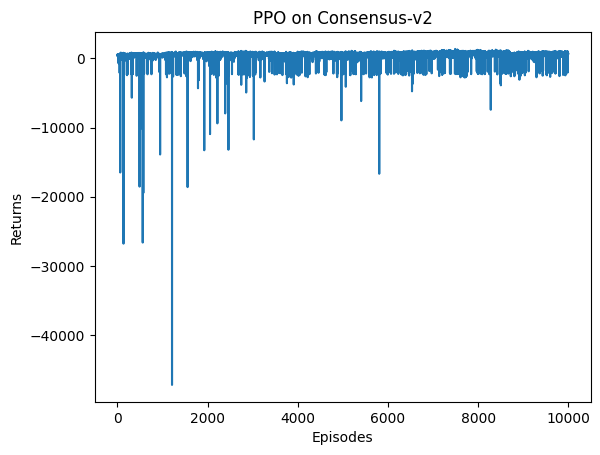

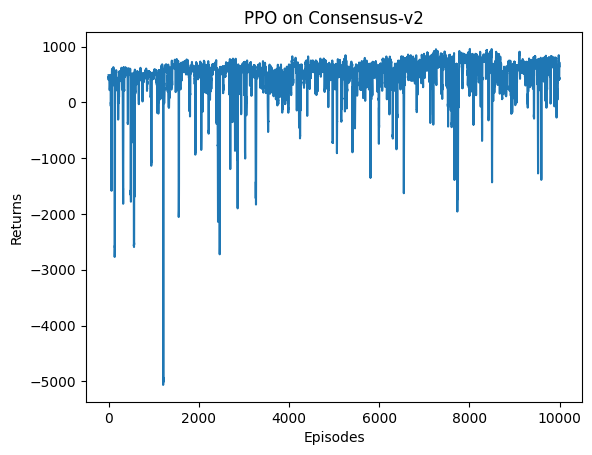

In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1) + 1e-10


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, eps, gamma, device):
        # 创建并初始化策略网络（Actor）和价值网络（Critic）
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        # 定义策略网络和价值网络的优化器，使用Adam优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda   # Generalized Advantage Estimation (GAE)的参数
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device
        

    def take_action(self, state):
        # 将输入状态转换为PyTorch张量，并移动到指定的设备（CPU或GPU）
        state = torch.tensor([state], dtype=torch.float).to(self.device)

        # 通过策略网络（Actor）获取在当前状态下采取每个动作的概率分布
        probs = self.actor(state)

        # 使用Categorical分布对象根据概率分布进行采样，得到选定的动作
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()

        return action.item()

    def update(self, transition_dict):
        # 从传入的transition_dict中获取训练所需的数据
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

         # 计算 TD 目标（Temporal Difference Target）
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)

        # 计算 TD 误差（Temporal Difference Delta）
        td_delta = td_target - self.critic(states)

        # 计算 Advantage（优势函数）
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)

        # 计算旧的动作概率的对数值
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()

        for _ in range(self.epochs):
            # 计算新的动作概率的对数值
            log_probs = torch.log(self.actor(states).gather(1, actions))

            # 计算 PPO 损失函数的比率（Clipped Surrogate Objective）
            ratio = torch.exp(log_probs - old_log_probs)

            # 计算两个截断项（clipping terms）
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断

            # 计算 PPO 损失函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数

            # 计算 Critic 损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 梯度清零
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

            # 反向传播和梯度更新
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 10000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Consensus-v2'  #Consensus-v0
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(1234)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent1(env, agent, num_episodes)

#rl_utils.train_on_policy_agent1(env, agent, 10)

episodes_list = list(range(len(return_list)))

plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [2]:
import rl_utils

mv_return = rl_utils.moving_average(return_list, 33)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

NameError: name 'return_list' is not defined